# TFM in Python

1. Packages
2. Data
3. Filtrado de datos
4. Sky Regions
5. BPT Diagram
6. WHAN Diagram
7. Extinction Correction
8. M-Z Relation
9. Galaxies Classification
10. Metallicities of Filaments, Voids and Tendrils
11. Metallicities of Filaments, Voids and Tendrils with fixed coefficients a,b and c
12. Outliers
13. Stellar Mass/Absolute Magnitude vs Redshift
14. SFR Relation
15. Field Galaxies (control samples)
16. Scale Relations
17. Fundamental Plane
18. Bootstrap
19. Coeficcicient plot
                                                                                                               
Appendix A: Other control sample for tendrils 

## 1. Packages

Introducimos los paquetes necesarios:

In [1]:
# Ejecution Time
import time
a = time.time()

#PAQUETES------------------------------------------------------------------------------------------------------------------
from astropy.io import fits #para importar fits files
from astropy.table import * # trabajar con Tables y QTables
from matplotlib.pyplot import *
from math import * 
from pandas import * #para dataframes
from numpy import *
from uncertainties import * #para propagate error
import uncertainties.unumpy as unumpy #para propagate error
from extinction import *  #para calculo extinciones
from scipy.stats import * #para los density scatter plots
from scipy.optimize import curve_fit #para ajuste polinomial
from seaborn import * #para el marginal histogram
from mpl_toolkits.axes_grid1 import make_axes_locatable #para el marginal histogram
from sklearn.metrics import * #calculo de R^2
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset #zoom en plots
import import_ipynb #importar cuadernos jupyter
import os #guardar plots 
import smplotlib #estilo paper para las gráficas
from tqdm import tqdm as tqdm #muestra barra de progreso
import itertools #unir listas de listas
from statistics import * #estadistica
from mpl_toolkits.mplot3d import Axes3D #plot3d

# %matplotlib tk # (MOSTRAR PLOT EMERGENTE)
# %matplotlib inline # (MOSTAR PLOT EN JUPYTER)
# %matplotlib widget # (ITEREACTVIE PLOT)

## 2. Data

Introducimos los datos del catálogo GAMA Phase 1, en concreto, llamamos como variables a las columnas de datos con las que vamos a trabajar. De esta forma, en la siguiente celda se recogen los nombres de las variables de todos los datos con los que trabajaremos.

Nota: Presentamos previamente un celda con una forma alternativa de leer archivos en .fts. Forma mucho mas eficiente y recomendada puesto que lee mas rápido y es mas fácil de visualizar, además de poder añadir quantities (unidades) a los datos. 

In [2]:
""" 
FORMA ALTERNATIVA (RECOMENDADA) DE LEER TABLAS DE DATOS EN .FITS:

from astropy.table import QTable

DataQTable = QTable.read("./Catalogos/GAMA.fits")
DataQTable

# acceder a columna: DataQTable['nombre_columa']
# acceder a segunda fila : DataQTable[2]
# acceder a un dato concreto: DataQTable['nombre_columna'][2] o DataQTable[2][2]

"""
print()

In [3]:
#Adjuntamos Datos
FITS=fits.open("./Catalogos/GAMA.fits") #lee .fits
GAMA=FITS[1].data #datos de GAMA 
#Buscamos filas haciendo FITS[1].data[1] o columnas FITS[1].data["FLUX_OBS_1"] (e.g)

#COORDENADAS
CATAID=GAMA["CATAID_1"] #cataid
RA=GAMA["RA_1"] #ascensión recta
DEC=GAMA["DEC_1"] #declinación

#LÍNEAS DE EMISIÓN 
Ha=GAMA["FLUX_OBS_Ha"] #flujo 24 (flujo de Halpha)
Hb=GAMA["FLUX_OBS_Hb"] #flujo 15 (flujo de Hbeta)
NII6583=GAMA["FLUX_OBS_NII6583"] #flujo 25 (flujo de NII6583)
OIII5007=GAMA["FLUX_OBS_OIII5007"] #flujo 17 (flujo de OIII5007)

Ha_Error=GAMA["FLUX_ERROR_24"] #error flujo 24 (error flujo de Halpha)
Hb_Error=GAMA["FLUX_ERROR_15"] #error flujo 15 (error flujo de Hbeta)
NII6583_Error=GAMA["FLUX_ERROR_25"] #error flujo 25 (error flujo de NII6583)
OIII5007_Error=GAMA["FLUX_ERROR_17"] #error flujo 17 (error flujo de OIII5007)

#AoN (SEÑAL A RUDIO S/N)
AoN_Ha=GAMA["AON_24"] #S/N Halpha
AoN_Hb=GAMA["AON_15"] #S/N Hbeta
AoN_NII6583=GAMA["AON_25"] #S/N NII6583
AoN_OIII5007=GAMA["AON_17"] #S/N OIII5007

#MASAS
logmstar=GAMA["logmstar"] #masa estelar (masa en estrellas)
dellogmstar=GAMA["dellogmstar"] #error en la masa estelar

#REDSHIFT
redshift=GAMA["Z_TONRY"] #redshift

#EW (ANCHO EQUIVALENTE MEDIDO EN AMSTRONGS) 
EW_Ha=GAMA["EW_24"] #EW Halpha
EW_Hb=GAMA["EW_15"] #EW Hbeta
EW_NII6583=GAMA["EW_25"] #EW NII6583
EW_OIII5007=GAMA["EW_17"] #EW OIII5007

EW_Ha_Error=GAMA["EW_ERROR_24"] #error EW Halpha
EW_Hb_Error=GAMA["EW_15"] #error EW Hbeta
EW_NII6583_Error=GAMA["EW_25"] #error EW NII6583
EW_OIII5007_Error=GAMA["EW_17"] #error EW OIII5007

#MAGNITUDES
M_r=GAMA["M_r"] #magnitud absoluta en banda r
delabsmag_r=GAMA["delabsmag_r"] #error magnitud absoluta en banda r


## 3. Filtrado de datos.

Hacemos previamente un filtrado de datos imponiendo unas condiciones en señal a ruido, lineas de emisión, redshift, etc cogiendo datos coherentes. De esta forma, seleccionaremos aquellas galaxias cuyos datos están "bien medidos".

Nótese que utilizaremos la notación "_ok" para referirnos a flujos u otras magntiudes filtradas. 

In [4]:
CATAID_ok=[] #introducimos coordenadas que cumplan las condiciones
RA_ok=[]
DEC_ok=[]

redshift_ok=[] #introducimos los redshift que cumplan las condiciones

Ha_ok=[] #introducimos flujos que cumplan las condiciones
Hb_ok=[]
NII6583_ok=[]
OIII5007_ok=[]

Ha_ok_Error=[] #introducimos errores de los flujos que cumplan las condiciones
Hb_ok_Error=[]
NII6583_ok_Error=[]
OIII5007_ok_Error=[]

EW_Ha_ok=[] #introducimos EW que cumplen las condiciones

logmstar_ok=[] #introducimos logmstar que cumplan las condiciones
dellogmstar_ok=[] #introducimos errores de logmstar que cumplan las condiciones

AoN_Ha_ok=[] #introducimos AoN que cumplan las condiciones
AoN_Hb_ok=[]
AoN_NII6583_ok=[]
AoN_OIII5007_ok=[]

M_r_ok=[] #introducimos magntiudes absolutas en banda r que cumplan las condiciones
delabsmag_r_ok=[] #introducimos errores de las magntiudes absolutas en banda r que cumplan las condiciones

for i in range(len(Ha)): #condiciones
    if Ha[i]>0 and Ha[i]!=inf and Hb[i]>0 and Hb[i]!=inf and NII6583[i]>0 and NII6583[i]!=inf and OIII5007[i]>0 and OIII5007[i]!=inf and redshift[i]<0.3 and AoN_Ha[i]>3 and AoN_Hb[i]>2 and AoN_OIII5007[i]>3 and AoN_NII6583[i]>2 and Ha_Error[i]>=0 and Ha_Error[i]!=inf and Hb_Error[i]>=0 and Hb_Error[i]!=inf and OIII5007_Error[i]>=0 and OIII5007_Error[i]!=inf and NII6583_Error[i]>=0 and NII6583_Error[i]!=inf: 
    
        CATAID_ok.append(CATAID[i])
        RA_ok.append(RA[i])
        DEC_ok.append(DEC[i])
        
        redshift_ok.append(redshift[i])
        
        Ha_ok.append(Ha[i])
        Hb_ok.append(Hb[i])
        NII6583_ok.append(NII6583[i])
        OIII5007_ok.append(OIII5007[i])

        Ha_ok_Error.append(Ha_Error[i])
        Hb_ok_Error.append(Hb_Error[i])
        NII6583_ok_Error.append(NII6583_Error[i])
        OIII5007_ok_Error.append(OIII5007_Error[i])
        
        EW_Ha_ok.append(EW_Ha[i])

        logmstar_ok.append(logmstar[i])
        dellogmstar_ok.append(dellogmstar[i])
        
        AoN_Ha_ok.append(AoN_Ha[i])
        AoN_Hb_ok.append(AoN_Hb[i])
        AoN_NII6583_ok.append(AoN_NII6583[i])
        AoN_OIII5007_ok.append(AoN_OIII5007[i])
        
        M_r_ok.append(M_r[i])
        delabsmag_r_ok.append(delabsmag_r[i])

De esta forma, el filtrado queda como: 

| Catalogue          | S/N cut             | Redshift cut        | Fluxes cut          | Fluxes error cut    |
|--------------------|---------------------|---------------------|---------------------|---------------------|
| 192.545 galaxies   | 18.637 galaxies     | 17.673 galaxies     | 17.376 galaxies     | 17.371 galaxies     |


## 4. Sky regions

Ploteamos las regiones del espacio en las que se encuentran nuestras galaxias del catálogo GAMA; en concreto de la Phase 1. Primero para todos los datos sin filtrar y luego en 3D para los datos filtrados.

#### Regiones del catálogo GAMA Phase 1 en 2D

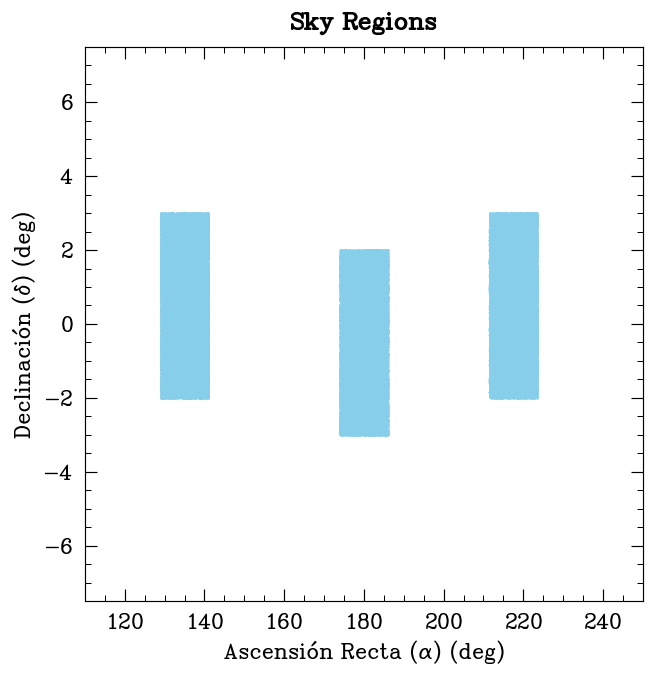

In [5]:
plot(RA,DEC,".",markersize=0.5,color="skyblue")
ylabel("Declinación (\u03B4) (deg)") 
xlabel("Ascensión Recta (\u03B1) (deg)")
title("Sky Regions",weight="bold")
ylim(-7.5,7.5)
xlim(110,250)
show()

#### Regiones del catálogo GAMA Phase 1 en 3D

Añadiendo un degrado en color a medida que aumeta el redshift.

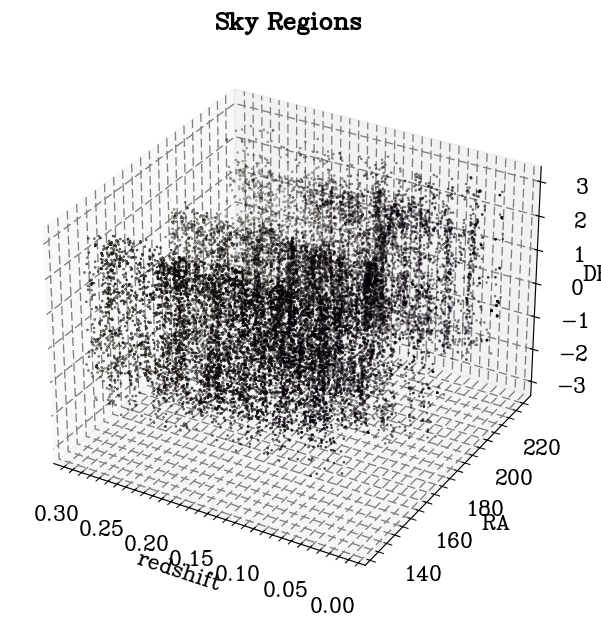

In [6]:
fig=figure()
ax=fig.add_subplot(111,projection="3d")

ax.scatter(redshift_ok,RA_ok,DEC_ok,marker=".",s=1,c=redshift_ok,cmap="plasma")
title("Sky Regions",weight="bold")
ax.set_xlabel("redshift")
ax.invert_xaxis()
ax.set_ylabel("RA")
ax.set_zlabel("DEC")

show()


## 5. Diagrama BPT

Ploteamos el BPT Diagram de las 192.545 galaxias para clasificarlas en SF galaxias (galxias cuyas líneas de emisión provinenen principalmente de estrellas), AGN (galaxias con un núcleo galáctico activo) y Composites (caso intermedio entre SF galaxias y AGNs). Sus ejes son los sigueintes:

$$
x_{\text{BPT}} = \log_{10}\left(\frac{\text{NII6583}}{\text{H$\alpha$}}\right)
$$

$$
y_{\text{BPT}} = \log_{10}\left(\frac{\text{OIII5007}}{\text{H$\beta$}}\right)
$$

Por otro lado, los errores de este diagrama y los posteriores serán calculados por el método de Monte-Carlo utilizando el comando de propagate en R (ver archivo correspondiente).

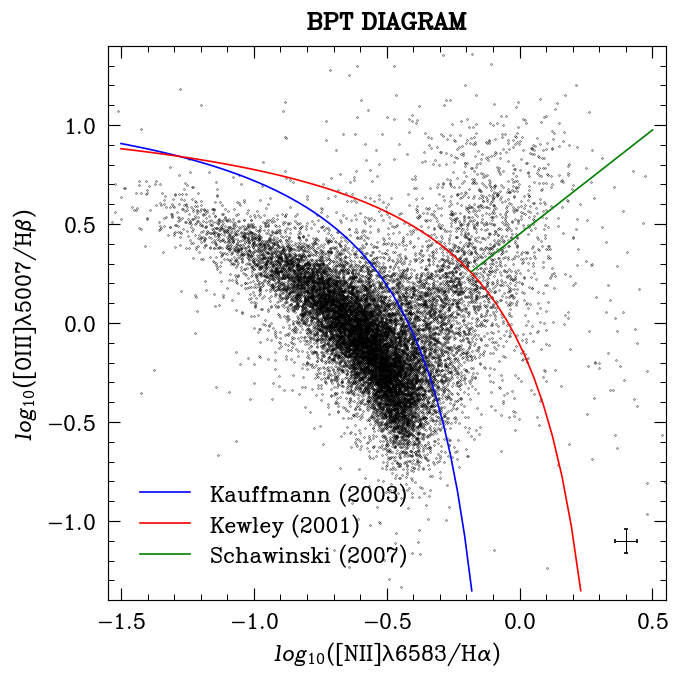

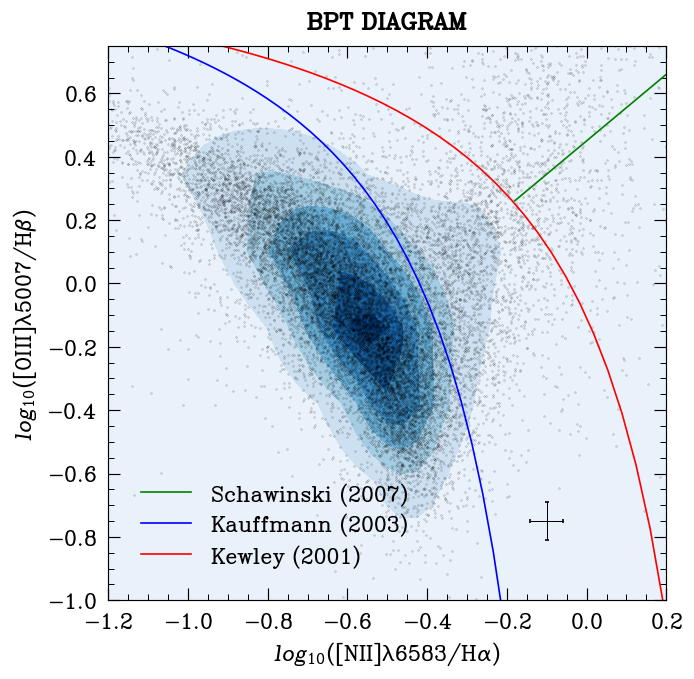

In [7]:
#Ejes del Diagrama BPT
x_BPT=log10(array(NII6583_ok)/array(Ha_ok))
y_BPT=log10(array(OIII5007_ok)/array(Hb_ok))

#Errores
Ha_and_Error=unumpy.uarray(Ha_ok,Ha_ok_Error) #definimos la variable con su error
Hb_and_Error=unumpy.uarray(Hb_ok,Hb_ok_Error)
NII6583_and_Error=unumpy.uarray(NII6583_ok,NII6583_ok_Error)
OIII5007_and_Error=unumpy.uarray(OIII5007_ok,OIII5007_ok_Error)

x_BPT_and_Error=unumpy.log10(array(NII6583_and_Error)/array(Ha_and_Error)) #ejes diagrama BPT en funcion de las variables con su error
y_BPT_and_Error=unumpy.log10(array(OIII5007_and_Error)/array(Hb_and_Error)) 

errx_BPT=unumpy.std_devs(x_BPT_and_Error) #propagate error de x
erry_BPT=unumpy.std_devs(y_BPT_and_Error) #propagate error de y

#Ploteamos BPT y funciones
plot(x_BPT,y_BPT,".",markersize=0.5,color="black")
xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT DIAGRAM",weight="bold")

x_Kauffman=linspace(-1.5,-0.18) #Kauffman
y_Kauffman=(0.61/(x_Kauffman-0.05))+1.3 
plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1)

x_kewley=linspace(-1.5,0.23) #Kewley
y_Kewley=(0.61/(x_kewley-0.47))+1.19 
plot(x_kewley,y_Kewley,color="red",label="Kewley (2001)",linewidth=1)

x_Schawinski=linspace(-0.180,0.5) #Schawinski
y_Schawinski=1.05*x_Schawinski+0.45
plot(x_Schawinski,y_Schawinski,color="green",label="Schawinski (2007)",linewidth=1)

xlim(-1.55,0.55)
ylim(-1.4,1.4)
errorbar(0.4,-1.1,xerr=0.041994829846394,yerr=0.0610989829348798,color="black",elinewidth=0.6,capsize=1.2) #barras de error

legend()

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

#DENSITY SCATTER PLOT------------------------------------------------------------------------------------------------------
#Crea un objeto de densidad de kernel
kdeBPT=gaussian_kde([ravel(x_BPT),ravel(y_BPT)])

#Crea una cuadrícula de valores para el gráfico de contorno
xminBPT,yminBPT=min(x_BPT),min(y_BPT)
xmaxBPT,ymaxBPT=max(x_BPT),max(y_BPT)
xiBPT,yiBPT=mgrid[xminBPT:xmaxBPT:100j,yminBPT:ymaxBPT:100j]
ziBPT=kdeBPT(vstack([xiBPT.flatten(),yiBPT.flatten()]))

#Crea el gráfico de densidad de puntos difuminados
contourf(xiBPT,yiBPT,ziBPT.reshape(xiBPT.shape),cmap="Blues")
scatter(x_BPT,y_BPT,s=0.1,alpha=0.3)

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT DIAGRAM",weight="bold")

xlim(-1.2,0.2)
ylim(-1,0.75)
errorbar(-0.1,-0.75,xerr=0.041994829846394,yerr=0.0610989829348798,color="black",elinewidth=0.6,capsize=1.2) #barras de error

plot(x_Schawinski,y_Schawinski,color="green",label="Schawinski (2007)",linewidth=1)
plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1)
plot(x_kewley,y_Kewley,color="red",label="Kewley (2001)",linewidth=1)

legend()

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

#### BPT Diagram with colors

Nótese que este diagrama BPT está sin corregir por extinción pero su clasificación en SF, Composite y AGN si tiene encuenta esta extinción (por ello sale alguna galaxia Composite en la región AGN, ...). 

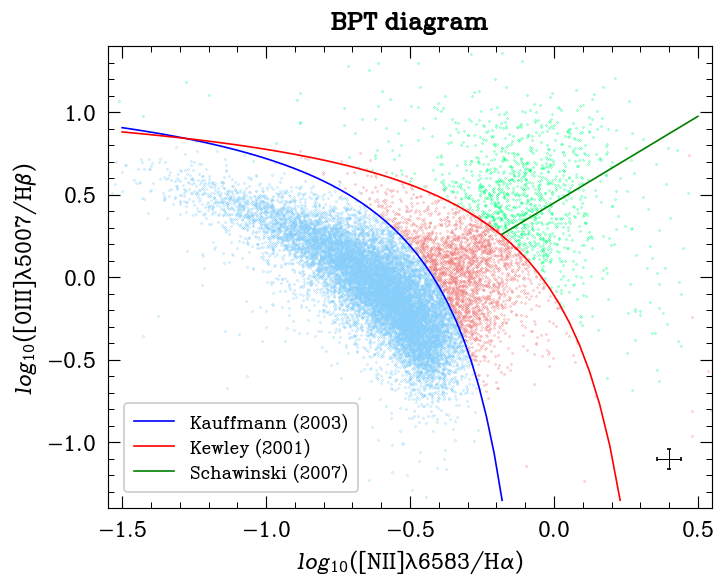

In [8]:
#Función para trazar las líneas Kauffman, Kewley y Schawinski
figure(figsize=(6.5, 5))

def plot_lines():
    x_Kauffman=linspace(-1.5,-0.18) #Kauffman
    y_Kauffman=(0.61/(x_Kauffman-0.05))+1.3 
    plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1)

    x_kewley=linspace(-1.5,0.23) #Kewley
    y_Kewley=(0.61/(x_kewley-0.47))+1.19 
    plot(x_kewley,y_Kewley,color="red",label="Kewley (2001)",linewidth=1)

    x_Schawinski=linspace(-0.180,0.5) #Schawinski
    y_Schawinski=1.05*x_Schawinski+0.45
    plot(x_Schawinski,y_Schawinski,color="green",label="Schawinski (2007)",linewidth=1)

# filtramos los valores de "GALAXY_TYPE" y los ploteamos
mask_S=GAMA["GALAXY_TYPE"]=="SF"
mask_A=GAMA["GALAXY_TYPE"]=="AGN"
mask_C=GAMA["GALAXY_TYPE"]=="Composite"

plot(log10(array(NII6583)[mask_S]/array(Ha)[mask_S]),log10(array(OIII5007)[mask_S]/array(Hb)[mask_S]),".",markersize=0.5,color="lightskyblue")
plot(log10(array(NII6583)[mask_A]/array(Ha)[mask_A]),log10(array(OIII5007)[mask_A]/array(Hb)[mask_A]),".",markersize=0.5,color="springgreen") 
plot(log10(array(NII6583)[mask_C]/array(Ha)[mask_C]),log10(array(OIII5007)[mask_C]/array(Hb)[mask_C]),".",markersize=0.5,color="lightcoral") 

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT diagram",weight="bold")

# trazamos las líneas
plot_lines()

xlim(-1.55,0.55)
ylim(-1.4,1.4)
errorbar(0.4,-1.1,xerr=0.041994829846394,yerr=0.0610989829348798,color="black",elinewidth=0.6,capsize=1.2) #barras de error

legend(fontsize=12, frameon=True)
#GUARDAR PLOT
savefig(os.path.join("./Images","BPT_Diagram.pdf"),bbox_inches="tight") 
show()

#### BPT diagram of SF galaxies

Lo mismo pero sólo para las galaxias SF:

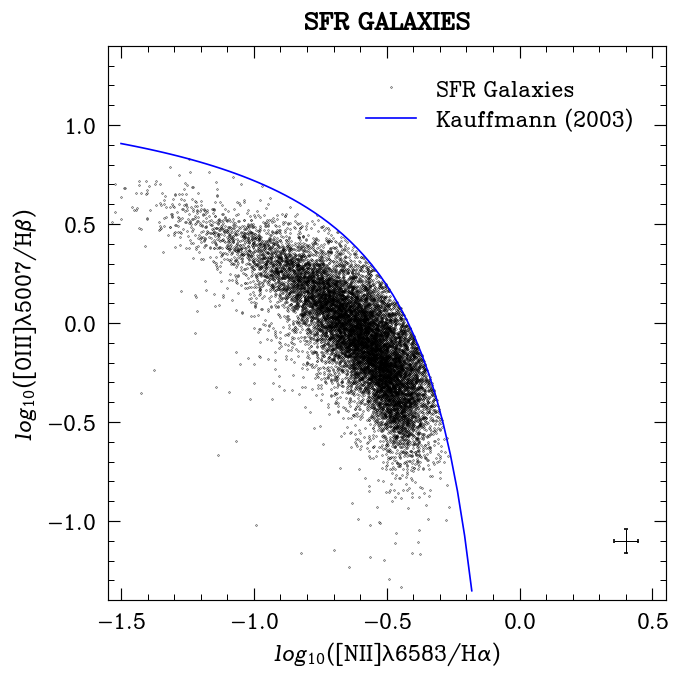

In [9]:
#Seleccionamos galaxias con SFR
y_Kauffman_condition=[] #Kauffman condition
for i in range(len(x_BPT)):
    y_Kauffman_condition.append((0.61/(x_BPT[i]-0.05))+1.3)
    
y_Kewley_condition=[] #Kewley condition
for i in range(len(x_BPT)):
    y_Kewley_condition.append((0.61/(x_BPT[i]-0.47))+1.19)
    
y_Schawinski_condition=[] #Schawinski  condition
for i in range(len(x_BPT)):
    y_Schawinski_condition.append(1.05*x_BPT[i]+0.45)

x_SF=[] #introducimos aquellas galaxias por debajo de Kauffman (SFR)
y_SF=[]

for i in range(len(x_BPT)):
    if y_BPT[i]<=y_Kauffman_condition[i] and x_BPT[i]<=0:
        x_SF.append(x_BPT[i])
        y_SF.append(y_BPT[i])

#Ploteamos SFR Galaxies
plot(x_SF,y_SF,".",markersize=0.5,color="black",label="SFR Galaxies") #SFR Galaxies
plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1) #Kauffman
xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("SFR GALAXIES",weight="bold")

xlim(-1.55,0.55)
ylim(-1.4,1.4)
errorbar(0.4,-1.1,xerr=0.0438891557655868,yerr=0.0606435178760599,color="black",elinewidth=0.6,capsize=1.2) #barras de error

legend()
show()

x_SF2=x_SF

Su clasificación es por tanto: 


| BPT diagram       | SF galaxies        | Composites galaxies  | AGN galaxies         |
|-------------------|--------------------|----------------------|----------------------|
| 17.368 galaxies   | 13.688 galaxies    | 2.382 galaxies       | 1.298 galaxies       |
| (100%)            | (79%)              | (14%)                | (7%)                 |


## 6. WHAN diagram

Ploteamos el WHAN diagram; una alternativa al BPT diagram cuando desconocemos ciertas lineas de emisión.

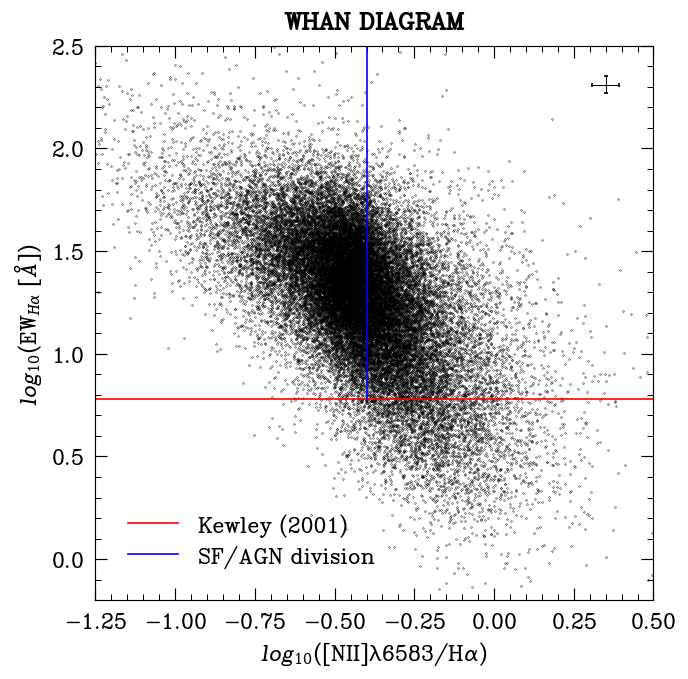

In [10]:
#Condicionales
Ha_ok_WHAN=[] #introducimos los flujos y EW que cumplan las condiciones
NII6583_ok_WHAN=[]
EW_Ha_ok_WHAN=[]

Ha_ok_Error_WHAN=[] #introducimos los errores de flujos y EW que cumplan las condiciones
NII6583_ok_Error_WHAN=[]
EW_Ha_ok_Error_WHAN=[]

for i in range(len(Ha)): #condiciones
    if Ha[i]>0 and Ha[i]!=inf and NII6583[i]>0 and NII6583[i]!=inf and redshift[i]<0.3 and AoN_Ha[i]>3 and AoN_NII6583[i]>2 and Ha_Error[i]>=0 and Ha_Error[i]!=inf and NII6583_Error[i]>=0 and NII6583_Error[i]!=inf and EW_Ha[i]>0 and EW_Ha[i]!=inf and EW_Ha_Error[i]>=0 and EW_Ha_Error[i]!=inf: 
        Ha_ok_WHAN.append(Ha[i])
        NII6583_ok_WHAN.append(NII6583[i])
        EW_Ha_ok_WHAN.append(EW_Ha[i])

        Ha_ok_Error_WHAN.append(Ha_Error[i])
        NII6583_ok_Error_WHAN.append(NII6583_Error[i])
        EW_Ha_ok_Error_WHAN.append(EW_Ha_Error[i])

#Ejes del Diagrama WHAN
x_WHAN=log10(array(NII6583_ok_WHAN)/array(Ha_ok_WHAN))
y_WHAN=log10(array(EW_Ha_ok_WHAN))

#Errores

Ha_and_Error_WHAN=unumpy.uarray(Ha_ok_WHAN,Ha_ok_Error_WHAN) #definimos la variable con su error
NII6583_and_Error_WHAN=unumpy.uarray(NII6583_ok_WHAN,NII6583_ok_Error_WHAN)
EW_Ha_and_Error_WHAN=unumpy.uarray(EW_Ha_ok_WHAN,EW_Ha_ok_Error_WHAN)

x_WHAN_and_Error=unumpy.log10(array(NII6583_and_Error_WHAN)/array(Ha_and_Error_WHAN)) #ejes del diagrama WHAN en función de su variable con su error
y_WHAN_and_Error=unumpy.log10(array(EW_Ha_and_Error_WHAN))

errx_WHAN=unumpy.std_devs(x_WHAN_and_Error) #propagate error de x
erry_WHAN=unumpy.std_devs(y_WHAN_and_Error) #propagate error de y

#Ploteamos
plot(x_WHAN,y_WHAN,".",markersize=0.5,color="black")

xlim(-1.25,0.5)
ylim(-0.2,2.5)

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$(EW$_{H\u03B1}$ [$\AA$])")
title("WHAN DIAGRAM",weight="bold")

errorbar(0.35,2.31,xerr=0.041994829846394,yerr=median(erry_WHAN),color="black",elinewidth=0.6,capsize=1.2) #barras de error

x_kewley=linspace(-1.3,0.5) #Kewley
y_Kewley=log10(6)*x_kewley/x_kewley
plot(x_kewley,y_Kewley,color="red",label="Kewley (2001)",linewidth=1)

y_SFAGN=linspace(log10(6),2.5) #SF/AGN
x_SFAGN=-0.4*y_SFAGN/y_SFAGN
plot(x_SFAGN,y_SFAGN,color="blue",label="SF/AGN division",linewidth=1)

legend()
show()


## 7. Extinction correction

Corregimos por extinción utilizando el modelo de Cardelli (1989) implementado en el paquete extinction de Python. Para más información teórica de las ecuaciones utilizadas, consultar TFG o tesis de Ángel. El módelo es el siguiente:

$$
F(\lambda)_{corr}=F(\lambda)_{obs}\cdot 10^{0.4A_\lambda}
$$

donde 

$$
A_{\lambda}=2.5[f(\lambda)+1]C(H\beta)
$$

siendo 

$$
C(H_\beta)=\frac{1}{f(H\alpha)}\cdot \log\left(\frac{2.86}{\left[\frac{H\alpha}{H\beta}\right]_{obs}}\right)
    \quad\text{and}\quad 
    f(\lambda)=0.858\left(a(x)+\frac{b(x)}{R_V}\right)-1
$$

De esta forma, obtenemos que el flujo corregido viene dado por: 

$$
F(\lambda)_{corr}=F(\lambda)_{obs}\cdot \left(\frac{\left[\frac{H\alpha}{H\beta}\right]_{obs}}{2.86}\right)^{-\left(\frac{f(\lambda) +1}{f(H_\alpha)}\right)}
$$

Nótese que utilizaremo la notación "_corrected" para flujos corregidos por extinción.

#### Correción por extinción del Diagrama BPT

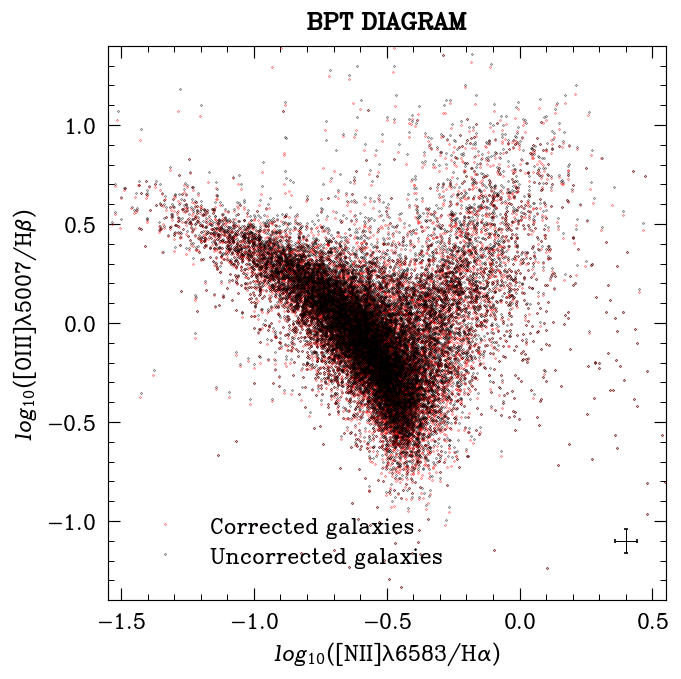

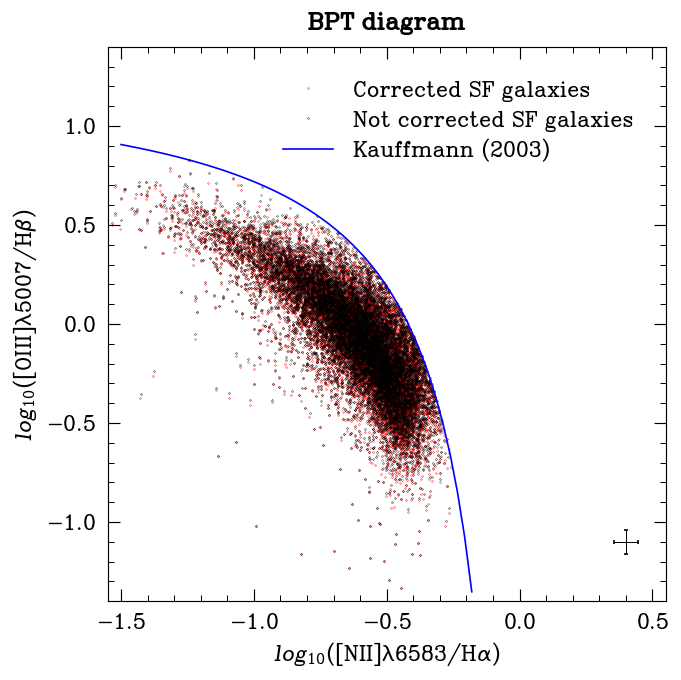

In [11]:
Ha_corrected=[]
Hb_corrected=[]
NII6583_corrected=[]
OIII5007_corrected=[]

#Flujos Corregidos por Cardelli et al. (1989)
for i in range(len(Ha_ok)):

    A_v=2.145*(1/-0.29834690766518845)*log10(2.86/(Ha_ok[i]/Hb_ok[i])) #A_v 

    #remove(A_lambda,flux)=F_corr=F_obs*10^(0,4*A_lambda) donde flux=F_obs y A_lambda=ccm89(wave,A_v,3.1)
 
    Ha_corrected.append(remove(ccm89(array([6562.80]),A_v,3.1),array(Ha_ok[i]))) #Correción flujos
    Hb_corrected.append(remove(ccm89(array([4861.32]),A_v,3.1),array(Hb_ok[i]))) 
    NII6583_corrected.append(remove(ccm89(array([6583.34]),A_v,3.1),array(NII6583_ok[i])))
    OIII5007_corrected.append(remove(ccm89(array([5006.7]),A_v,3.1),array(OIII5007_ok[i])))

#Contamos galaxias SF con flujos observados mayores que los corregidos (strange galaxies SF)
strange_galaxies=0

for i in range(len(Ha_corrected)):
    if y_BPT[i]<=y_Kauffman_condition[i] and x_BPT[i]<=0: 
        if Ha_ok[i]>Ha_corrected[i] or Hb_ok[i]>Hb_corrected[i] or OIII5007_ok[i]>OIII5007_corrected[i] or NII6583_ok[i]>NII6583_corrected[i]:
            strange_galaxies=strange_galaxies+1

#Seleccion de galaxias raras (con flujos observados>flujos corregidos)
for i in range(len(Ha_ok)):
    if Ha_ok[i]>Ha_corrected[i]: 
        Ha_corrected[i]=array([Ha_ok[i]])
    if Hb_ok[i]>Hb_corrected[i]: 
        Hb_corrected[i]=array([Hb_ok[i]])    
    if NII6583_ok[i]>NII6583_corrected[i]:
        NII6583_corrected[i]=array([NII6583_ok[i]])
    if OIII5007_ok[i]>OIII5007_corrected[i]:
        OIII5007_corrected[i]=array([OIII5007_ok[i]])

#Ejes del Diagrama BPT Corregidos por extinción
x_BPT_corrected=log10(array(NII6583_corrected)/array(Ha_corrected))
y_BPT_corrected=log10(array(OIII5007_corrected)/array(Hb_corrected))

#Ploteamos BPT Corregido y No Corregido
plot(x_BPT_corrected,y_BPT_corrected,".",markersize=0.5,color="red",label="Corrected galaxies")
plot(x_BPT,y_BPT,".",markersize=0.5,color="black",label="Uncorrected galaxies")

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT DIAGRAM",weight="bold")

xlim(-1.55,0.55)
ylim(-1.4,1.4)
errorbar(0.4,-1.1,xerr=0.041994829846394,yerr=0.0610989829348798,color="black",elinewidth=0.6,capsize=1.2) #barras de error

legend()
show()

#Ploteamos la correción por extinción sólo para las SF
x_SF_corrected=[] #introducimos aquellas galaxias por debajo de Kauffman (SFR) coon flujos corregidos
y_SF_corrected=[]
for i in range(len(x_BPT_corrected)):
    if y_BPT_corrected[i]<=y_Kauffman_condition[i] and x_BPT_corrected[i]<=0:
        x_SF_corrected.append(x_BPT_corrected[i])
        y_SF_corrected.append(y_BPT_corrected[i])

plot(x_SF_corrected,y_SF_corrected,".",markersize=0.5,color="red",label="Corrected SF galaxies") #SFR Galaxies Corrected
plot(x_SF,y_SF,".",markersize=0.5,color="black",label="Not corrected SF galaxies") #SFR Galaxies

x_Kauffman=linspace(-1.5,-0.18) #Kauffman
y_Kauffman=(0.61/(x_Kauffman-0.05))+1.3 
plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1)

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT diagram",weight="bold")

xlim(-1.55,0.55)
ylim(-1.4,1.4)
errorbar(0.4,-1.1,xerr=0.0438891557655868,yerr=0.0606435178760599,color="black",elinewidth=0.6,capsize=1.2) #barras de error

legend()
#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

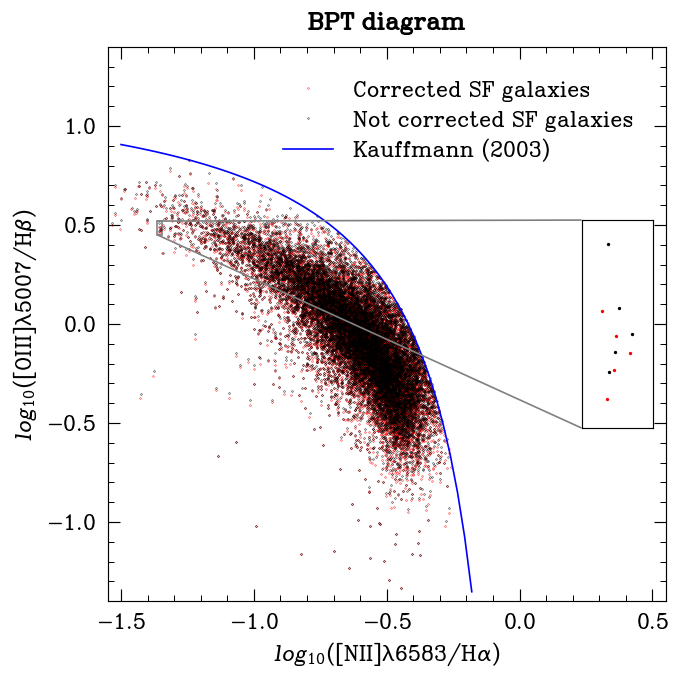

In [12]:
fig=figure()

#Figura principal
ax_main=fig.add_subplot(1,1,1)

#Plot de la figura principal
ax_main.plot(x_SF_corrected,y_SF_corrected,".",markersize=0.5,color="red",label="Corrected SF galaxies")
ax_main.plot(x_SF,y_SF,".",markersize=0.5,color="black",label="Not corrected SF galaxies")
ax_main.plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)", linewidth=1)

ax_main.set_xlabel("$log_{10}$([NII]$\lambda$6583/Hα)")
ax_main.set_ylabel("$log_{10}$([OIII]$\lambda$5007/Hβ)")
ax_main.set_title("BPT diagram", weight="bold")
ax_main.set_xlim(-1.55,0.55)
ax_main.set_ylim(-1.4,1.4)
ax_main.legend()

#Subfigura en una esquina
ax_inset=zoomed_inset_axes(ax_main,zoom=15,loc=7)  #crea el zoomed inset axes

#Plot de la subfigura en una esquina
ax_inset.plot(x_SF_corrected,y_SF_corrected,"o",markersize=1,color="red",label="Corrected SF galaxies")
ax_inset.plot(x_SF,y_SF,"o",markersize=1, color="black",label="Not corrected SF galaxies")

ax_inset.set_xlim(-1.363,-1.345)
ax_inset.set_ylim(0.45,0.52)

ax_inset.set_xticks([])
ax_inset.set_yticks([])

#Marcar el área de zoom en la figura principal
mark_inset(ax_main,ax_inset,loc1=2,loc2=3,fc="none",ec="0.5") 

#GUARDAR PLOT
#savefig("SF_galaxies_corrected.pdf",bbox_inches="tight") 
show()


#### Relaciones lineales entre líneas de emisión extinguidas

In [13]:
#Seleccionamos flujos corregidos y observados de galaxias SF
x_SF_observed=[]
x_SF_corrected2=[]
y_SF_observed=[]
y_SF_corrected2=[]

for i in range(len(GAMA["GALAXY_TYPE"])):
    if GAMA["GALAXY_TYPE"][i]=="SF":
        x_SF_corrected2.append(log10(GAMA["FLUX_CORRECT_NII6583"][i]/GAMA["FLUX_CORRECT_Ha"][i]))
        y_SF_corrected2.append(log10(GAMA["FLUX_CORRECT_OIII5007"][i]/GAMA["FLUX_CORRECT_Hb"][i]))
        x_SF_observed.append(log10(NII6583[i]/Ha[i]))
        y_SF_observed.append(log10(OIII5007[i]/Hb[i]))


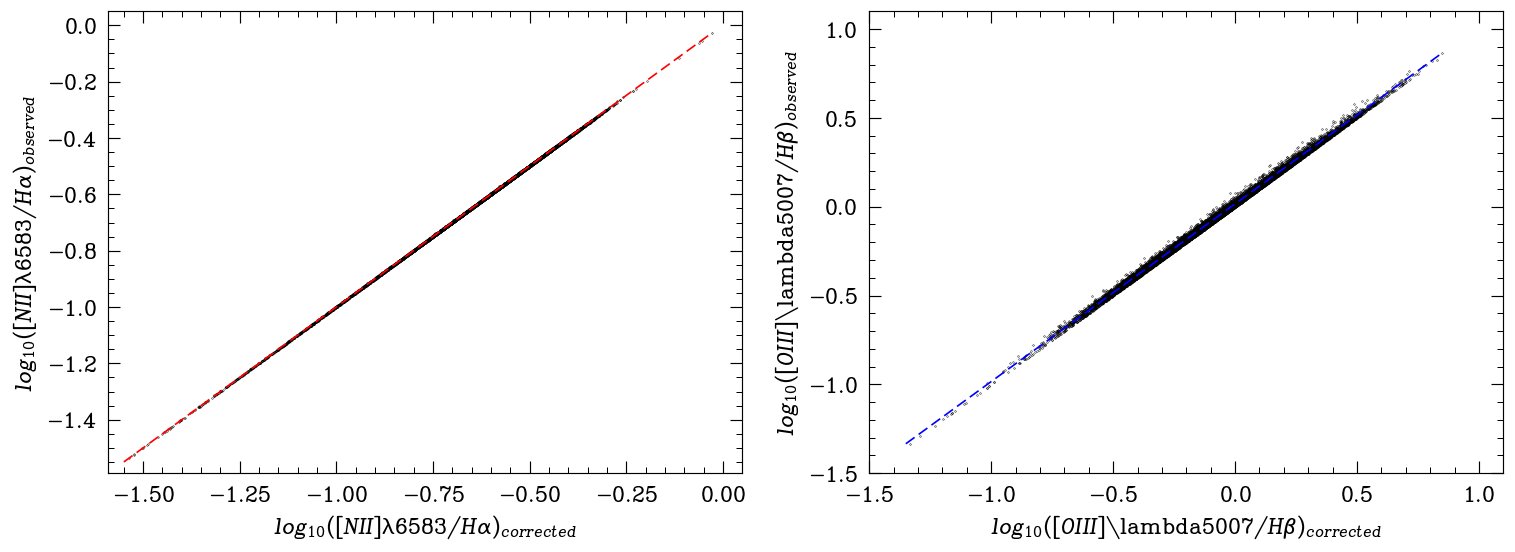

In [14]:
#Comaprativa entre ejes del diagrama BPT obersvados y corregidos
fig,(ax1,ax2)=subplots(1,2,figsize=(15,5))

ax1.plot(x_SF_corrected2,x_SF_observed,".",color="black",markersize=0.5)

ax1.set_xlim(-1.59,0.05)
ax1.set_ylim(-1.59,0.05)

#ax1.set_xlim(-1,-0.2)
#ax1.set_ylim(-1,-0.2)

ax1.set_xlabel("$log_{10}([NII]\lambda6583/H\u03B1)_{corrected}$")
ax1.set_ylabel("$log_{10}([NII]\lambda6583/H\u03B1)_{observed}$")

coefficients1=polyfit(x_SF_corrected2,x_SF_observed,1)
m1=coefficients1[0] 
b1=coefficients1[1] 

x_line1=linspace(-1.55,max(x_SF_corrected2),100)
y_line1=m1*x_line1+b1

ax1.plot(x_line1,y_line1,"--",color="red",linewidth=1)

ax2.plot(y_SF_corrected2,y_SF_observed,".",color="black",markersize=0.5)

coefficients2=polyfit(y_SF_corrected2,y_SF_observed,1)
m2=coefficients2[0] 
b2=coefficients2[1] 

x_line2=linspace(-1.35,max(y_SF_corrected2),100)
y_line2=m2*x_line2+b2

ax2.plot(x_line2,y_line2,"--",color="blue",linewidth=1)

ax2.set_xlim(-1.5,1.1)
ax2.set_ylim(-1.5,1.1)

#ax2.set_xlim(-1,0.8)
#ax2.set_ylim(-1,0.8)

ax2.set_xlabel("$log_{10}([OIII]$\lambda$5007/H\u03B2)_{corrected}$")
ax2.set_ylabel("$log_{10}([OIII]$\lambda$5007/H\u03B2)_{observed}$")

#GUARDAR PLOT
#savefig("comparation_correction.pdf",bbox_inches="tight")
show()

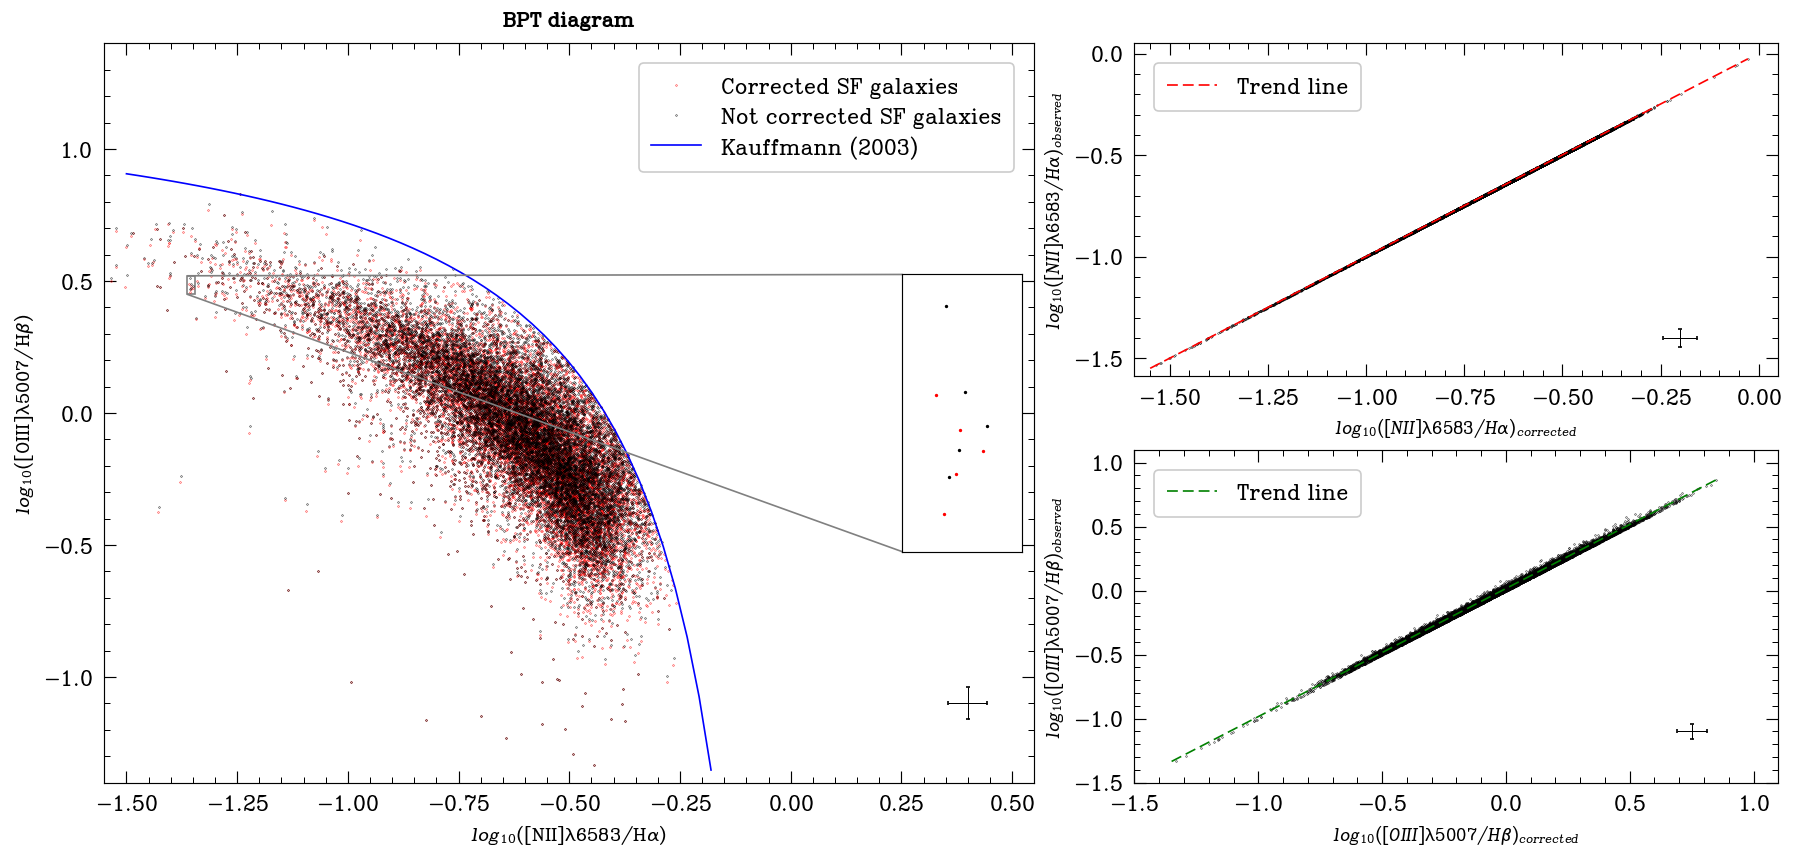

In [15]:
#Figura 1
fig=figure(figsize=(18,8))

#Figura principal
ax_main=fig.add_subplot(2,2,(1,3))
ax_main.plot(x_SF_corrected,y_SF_corrected,".",markersize=0.5,color="red",label="Corrected SF galaxies")
ax_main.plot(x_SF,y_SF, ".",markersize=0.5,color="black",label="Not corrected SF galaxies")
ax_main.plot(x_Kauffman,y_Kauffman,color="blue",label="Kauffmann (2003)",linewidth=1)
ax_main.set_xlabel("$log_{10}$([NII]$\lambda$6583/Hα)",fontsize=13)
ax_main.set_ylabel("$log_{10}$([OIII]$\lambda$5007/Hβ)",fontsize=13)
ax_main.set_title("BPT diagram", weight="bold",fontsize=15)
ax_main.set_xlim(-1.55, 0.55)
ax_main.set_ylim(-1.4, 1.4)
ax_main.legend(frameon=True)
ax_main.errorbar(0.4,-1.1,xerr=0.0438891557655868,yerr=0.0606435178760599,color="black",elinewidth=0.6,capsize=1.2) #barras de error


#Subfigura
ax_inset=zoomed_inset_axes(ax_main, zoom=15, loc=7)
ax_inset.plot(x_SF_corrected,y_SF_corrected,"o", markersize=1,color="red",label="Corrected SF galaxies")
ax_inset.plot(x_SF,y_SF,"o",markersize=1,color="black",label="Not corrected SF galaxies")
ax_inset.set_xlim(-1.363,-1.345)
ax_inset.set_ylim(0.45, 0.52)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
mark_inset(ax_main, ax_inset,loc1=2,loc2=3,fc="none",ec="0.5")

#Figura 2
ax2=fig.add_subplot(2,3,3) #222
ax2.plot(x_SF_corrected2,x_SF_observed,".",color="black",markersize=0.5)
ax2.set_xlim(-1.59,0.05)
ax2.set_ylim(-1.59,0.05)
ax2.set_xlabel("$log_{10}([NII]\lambda6583/Hα)_{corrected}$",fontsize=12)
ax2.set_ylabel("$log_{10}([NII]\lambda6583/Hα)_{observed}$",fontsize=12)
coefficients1 = polyfit(x_SF_corrected2, x_SF_observed,1)
m1=coefficients1[0]
b1=coefficients1[1]
x_line1=linspace(-1.55, max(x_SF_corrected2),100)
y_line1=m1*x_line1+b1
ax2.plot(x_line1, y_line1,"--",color="red",linewidth=1,label="Trend line")
ax2.legend(frameon=True)
ax2.errorbar(-0.2,-1.4,xerr=0.0438891557655868,yerr=0.0438891557655868,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#Figura 3 
ax3=fig.add_subplot(2,3,6) #224
ax3.plot(y_SF_corrected2, y_SF_observed,".",color="black",markersize=0.5)
ax3.set_xlim(-1.5,1.1)
ax3.set_ylim(-1.5,1.1)
ax3.set_xlabel("$log_{10}([OIII]\lambda5007/Hβ)_{corrected}$",fontsize=12)
ax3.set_ylabel("$log_{10}([OIII]\lambda5007/Hβ)_{observed}$",fontsize=12)
coefficients2 = polyfit(y_SF_corrected2,y_SF_observed,1)
m2=coefficients2[0]
b2=coefficients2[1]
x_line2=linspace(-1.35,max(y_SF_corrected2),100)
y_line2=m2*x_line2+b2
ax3.plot(x_line2,y_line2,"--",color="green",linewidth=1,label="Trend line")
ax3.legend(frameon=True)
ax3.errorbar(0.75,-1.1,xerr=0.0606435178760599,yerr=0.0606435178760599,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#Ajustar espaciado
fig.subplots_adjust(wspace=-0.2,hspace=0.22)

#GUARDAR PLOT
savefig("Images/Comparation_correction.pdf",bbox_inches="tight")
show()

##  8. M-Z Relation

Ploteamos la M-Z Relation. Calculamos para ello previamente la metalicidad utilizando la relación de Pattini (2004) dado por: 

$$
12+log(O/H)=8.73-0.32\cdot O3N2
$$

donde

$$
O3N2=log_{10}\left(\frac{[OIII]\lambda5007/H\beta}{[NII]\lambda6583/H\alpha}\right)
$$

In [16]:
#O3N2
O3N2=log10((array(OIII5007_corrected)/array(Hb_corrected))/(array(NII6583_corrected)/array(Ha_corrected)))

#Calibration of Pettini & Pagel (2004)
PPO4=8.73-0.32*O3N2 #PPO4=metal


siendo la metalicidad del sol de 12+log(O/H) $\simeq$ 8.69.

#### Seleccionamos las variables de las SF Galaxies

Seleccionamos en la próxima celda las variables de las galaxias SF denotándolas por "_SF". Para seleccionarlos, partimos del catálogo GAMA de forma que obtenemos 13.689 galaxias SF, habiendo eliminado las masas mal medidas).

In [17]:
PPO4_SF=[] #introducimos el valor de PPO4 de sólo las galaxias SF

Ha_SF=[] #introducimos los flujos corregidos de las galaxias SF
Hb_SF=[]
OIII_SF=[]
NII_SF=[]

Ha_SF_Error=[] #introducimos los erros de los flujos corregidos de las galaxias SF
Hb_SF_Error=[]
OIII_SF_Error=[]
NII_SF_Error=[]

logmstar_SF=[] #introducimos masas y errores de masas de galaxias SF
dellogmstar_SF=[]

AoN_Ha_SF=[] #introducimos los AoN de aquellas galaxias por debajo de Kauffman (SFR)
AoN_Hb_SF=[]
AoN_NII6583_SF=[]
AoN_OIII5007_SF=[]

EW_Ha_ok_SF=[] #introdumis EW de las galaxias SF
M_r_SF=[] #introducimos magntiudes absolutas de las galaxias SF

redshift_SF=[] #introducimos z de las galaxias SF

#SELECCIONAMOS LAS VARIABLES DE LAS GALAXIAS SF Y CON MAS BIEN MEDIDA
for i in range(len(GAMA["GALAXY_TYPE"])):
    if GAMA["GALAXY_TYPE"][i]=="SF" and GAMA["logmstar"][i]!=-99:
        
        Ha_SF.append(GAMA["FLUX_CORRECT_Ha"][i])
        Hb_SF.append(GAMA["FLUX_CORRECT_Hb"][i])
        OIII_SF.append(GAMA["FLUX_CORRECT_OIII5007"][i])
        NII_SF.append(GAMA["FLUX_CORRECT_NII6583"][i])
        
        Ha_SF_Error.append(GAMA["FLUX_ERROR_24"][i])
        Hb_SF_Error.append(GAMA["FLUX_ERROR_15"][i])
        OIII_SF_Error.append(GAMA["FLUX_ERROR_17"][i])
        NII_SF_Error.append(GAMA["FLUX_ERROR_25"][i])
        
        PPO4_SF.append(GAMA["METALLICITY"][i])
        logmstar_SF.append(GAMA["logmstar"][i]) 
        dellogmstar_SF.append(GAMA["dellogmstar"][i])
             
        AoN_Ha_SF.append(GAMA["AON_24"][i])
        AoN_Hb_SF.append(GAMA["AON_15"][i])
        AoN_NII6583_SF.append(GAMA["AON_25"][i])
        AoN_OIII5007_SF.append(GAMA["AON_17"][i])
        
        EW_Ha_ok_SF.append(GAMA["EW_24"][i])
        
        M_r_SF.append(GAMA["M_r"][i])
        
        redshift_SF.append(GAMA["Z_TONRY"][i])
        

Continuamos calculando metalicidades por la expresión de Pattini (PPO4).

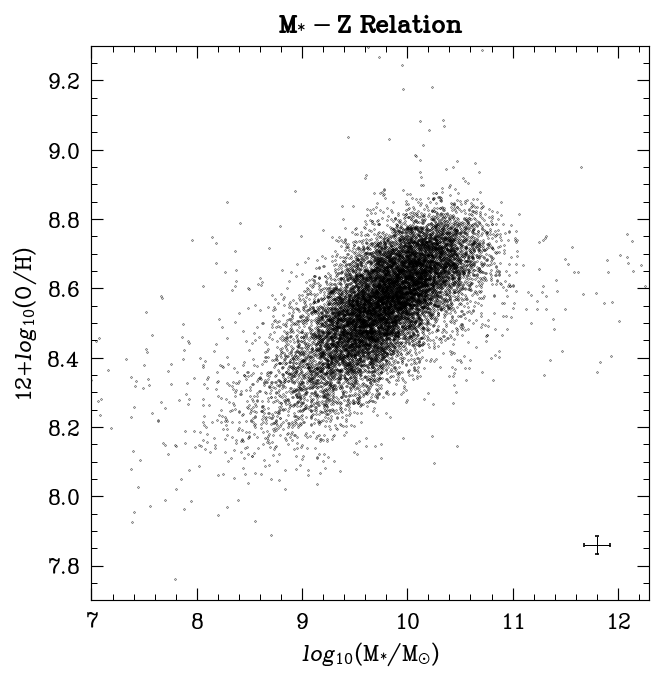

Coeficientes del ajuste: [-1.16349265e-03  1.04329863e-02  3.26303412e-01  5.46767976e+00]


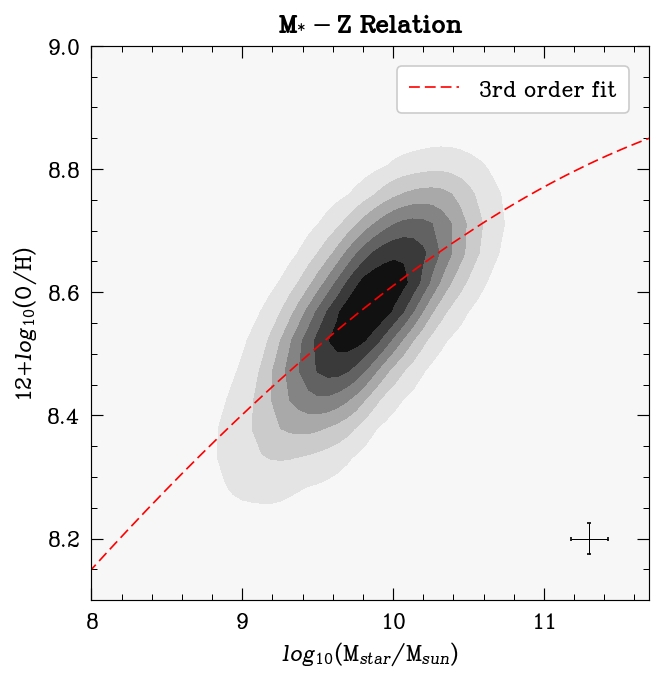

In [18]:
#Ploteamos M-Z Relation 
plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black",label="SF Galaxies")

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS
p=polyfit(ravel(logmstar_SF),ravel(PPO4_SF),3) #calcula coeficientes del polinomio de orden 3
y_fit=polyval(p,ravel(logmstar_SF)) #crea función polinómica con los coeficientes obtenidos

#Calculamos pesos (necesarios para el ajuste polinomial)
w=[]
resid=[]
for m in range(len(y_fit)):
    resid.append(PPO4_SF[m]-y_fit[m])
    w.append(1/resid[m]**2)

#Ajuste por polinomios con w
p_w=polyfit(ravel(logmstar_SF),ravel(PPO4_SF),3,w=ravel(w)) #calcula coeficientes del polinomio de orden 3 con pesos (w)
y_fit_w=polyval(p_w,ravel(logmstar_SF)) #crea función polinómica con los coeficientes obtenidos con pesos (w)

#plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit",linewidth=1) #ajuste polinomial con pesos (w)
#legend()

#GUARDAR PLOT
savefig("./Images/M_Z_Relation.pdf",bbox_inches="tight") 
show()

print("Coeficientes del ajuste:",p_w)

#DENSITY SCATTER PLOT
#Crea un objeto de densidad de kernel
kdeZ=gaussian_kde([ravel(logmstar_SF),ravel(PPO4_SF)])

#Crea una cuadrícula de valores para el gráfico de contorno
xminZ,yminZ=min(logmstar_SF),min(PPO4_SF)
xmaxZ,ymaxZ=max(logmstar_SF),max(PPO4_SF)
xiZ,yiZ=mgrid[xminZ:xmaxZ:100j,yminZ:ymaxZ:100j]
ziZ=kdeZ(vstack([xiZ.flatten(),yiZ.flatten()]))

#Crea el gráfico de densidad de puntos difuminados
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(8,11.7)
ylim(8.1,9)

errorbar(11.3,8.2,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="red",label="3rd order fit",linewidth=1) #ajuste polinomial

legend(frameon=True)
#GUARDAR PLOT
#savefig("test2.pdf",bbox_inches="tight") 
show()

Hemos hecho un ajuste polinomial de tercer orden (no de segundo para ver mejor la tendencia) teniendo encuenta los residuos. Vemos que, en general, a mayor masa, mayor metalicidad. Lo ploteamos ahora como un marginal histogram y diagrama de densidades utilizando un par de paquetes de Python introducidos en la sección 1. 

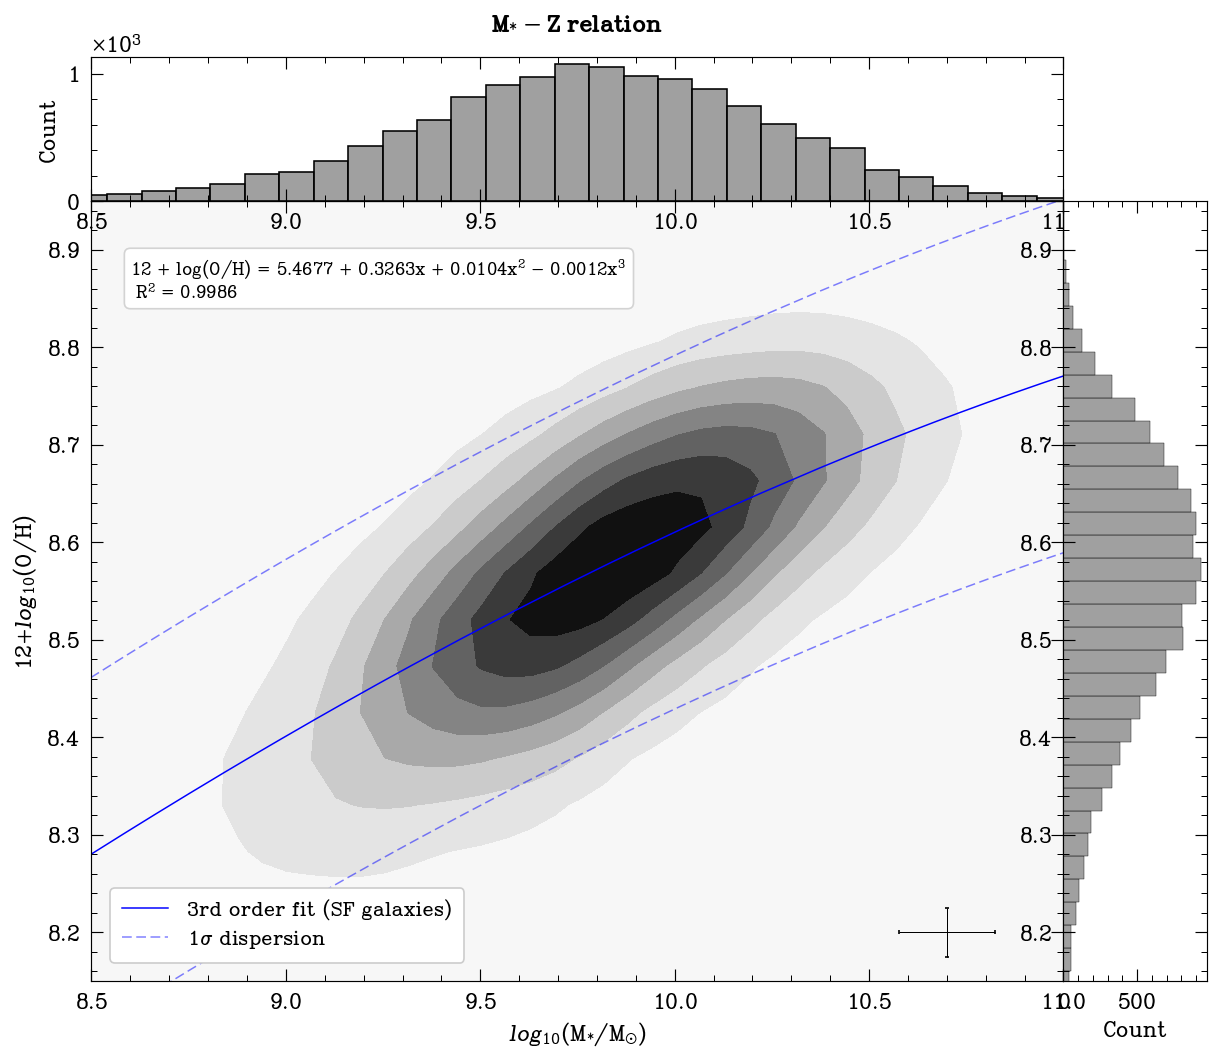

In [19]:
#Crear el subplot principal y los subplots marginales usando make_axes_locatable
fig, ax=subplots(figsize=(12,10))
divider=make_axes_locatable(ax)
ax_histx=divider.append_axes("top",size=1.2,pad=0,sharex=ax)
ax_histy=divider.append_axes("right",size=1.2,pad=0,sharey=ax)

#Ploteamos M-Z Relation
kdeZ=gaussian_kde([ravel(logmstar_SF),ravel(PPO4_SF)])

xminZ,yminZ=min(logmstar_SF),min(PPO4_SF)
xmaxZ,ymaxZ=max(logmstar_SF),max(PPO4_SF)
xiZ,yiZ=mgrid[xminZ:xmaxZ:100j,yminZ:ymaxZ:100j]
ziZ=kdeZ(vstack([xiZ.flatten(),yiZ.flatten()]))

#Crea el gráfico de densidad de puntos difuminados
ax.contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys")

#Ajuste polinomial con pesos (w)
ax.plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"-",color="blue",label="3rd order fit (SF galaxies)",linewidth=0.9) 

#Dispersion del ajuste
dispersion=std(resid)
y_upper=y_fit_w+dispersion
y_lower=y_fit_w-dispersion

ax.plot(sorted(ravel(logmstar_SF)),sorted(y_upper),"--",color="blue",linewidth=0.9,alpha=0.5) 
ax.plot(sorted(ravel(logmstar_SF)),sorted(y_lower),"--",color="blue",label="1$\sigma$ dispersion",linewidth=0.9,alpha=0.5) 

#Crea los histogramas marginales
histplot(x=ravel(logmstar_SF),ax=ax_histx,bins=70,color="gray")
histplot(y=ravel(PPO4_SF),ax=ax_histy,bins=200,orientation="horizontal",color="gray")

#Ajusta los límites de los subplots principales
ax.set_xlim(8.5,11)
ax.set_ylim(8.15,8.95)

#Ajusta las etiquetas de los subplots principales
ax.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=15)
ax.set_ylabel("12+$log_{10}$(O/H)",fontsize=15)
ax.set_title("M$_{*}-$Z relation",weight="bold",y=1.2,fontsize=17)

ax.errorbar(10.7,8.2,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

ax.text(8.6,8.85,"12 + log(O/H) = 5.4677 + 0.3263x + 0.0104x$^2$ − 0.0012x$^3$ \n R$^2$ = 0.9986",fontsize=12, bbox = dict(boxstyle="round,pad=0.3",fc="white",ec="lightgray",lw=1))

ax.legend(loc="lower left",fontsize=14,frameon=True)
#GUARDAR PLOT
savefig("Images/M_Z_Relation_MH.png",bbox_inches="tight") 
show()

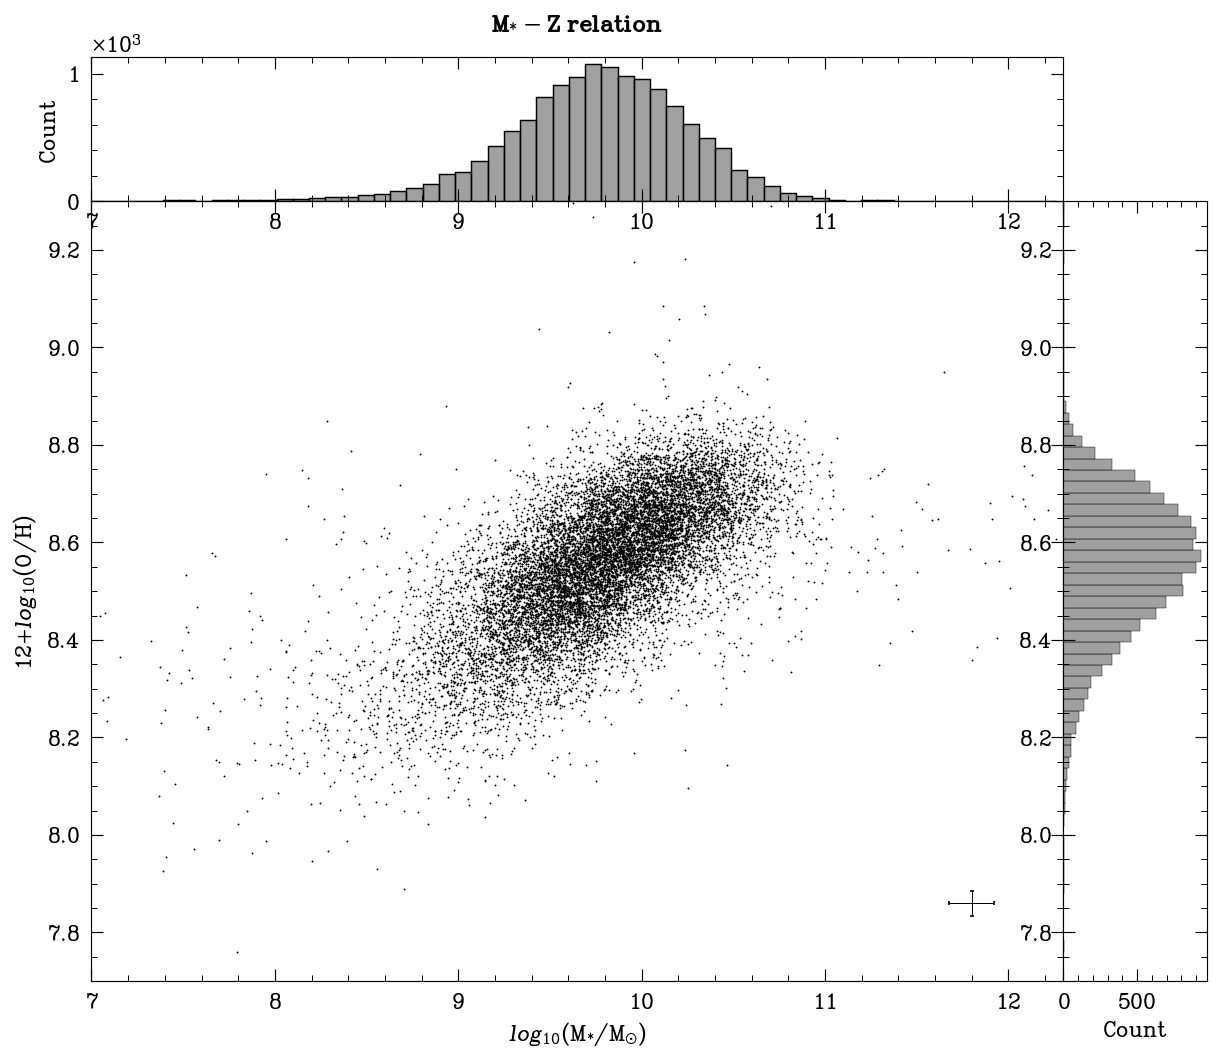

In [20]:
#Crear el subplot principal y los subplots marginales usando make_axes_locatable
fig, ax=subplots(figsize=(12,10))
divider=make_axes_locatable(ax)
ax_histx=divider.append_axes("top",size=1.2,pad=0,sharex=ax)
ax_histy=divider.append_axes("right",size=1.2,pad=0,sharey=ax)

#Ploteamos M-Z Relation
scatterplot(x=ravel(logmstar_SF),y=ravel(PPO4_SF),ax=ax,s=1,color="black",edgecolor="black")

#Ajuste polinomial con pesos (w)
#ax.plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"-",color="blue",label="3rd order fit (SF galaxies)",linewidth=0.9) 

#Dispersion del ajuste
dispersion=std(resid)
y_upper=y_fit_w+dispersion
y_lower=y_fit_w-dispersion

#ax.plot(sorted(ravel(logmstar_SF)),sorted(y_upper),"--",color="blue",linewidth=0.9,alpha=0.5) 
#ax.plot(sorted(ravel(logmstar_SF)),sorted(y_lower),"--",color="blue",label="1$\sigma$ dispersion",linewidth=0.9,alpha=0.5) 

# Crea los histogramas marginales
histplot(x=ravel(logmstar_SF), ax=ax_histx, bins=70, color="gray")
histplot(y=ravel(PPO4_SF),ax=ax_histy,bins=200, orientation="horizontal",color="gray")

# Ajusta los límites de los subplots principales
ax.set_xlim(7,12.3)
ax.set_ylim(7.7,9.3)

# Ajusta las etiquetas de los subplots principales
ax.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=15)
ax.set_ylabel("12+$log_{10}$(O/H)",fontsize=15)
ax.set_title("M$_{*}-$Z relation",weight="bold",y=1.2,fontsize=17)

ax.errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#ax.text(7.25,9.1,"12+log(O/H)=5.4677+0.3263x+0.0104x$^2$−0.0012x$^3$ \n R$^2$=0.9986",fontsize=12)

#ax.legend(loc="lower left",fontsize=14)
#GUARDAR PLOT
savefig("Images/Metallicity_marginal_histogram.pdf",bbox_inches="tight") 
show()

## 9. Galaxies Classification

Clasificamos las galaxias del catálogo GAMA según lo dicho en el diagrama BPT para trabajar fácilmente con ellas. Así, podremos seleccionar de forma mas sencillas las galaxias SF si nos fuese necesario. 

In [21]:
#selected_galaxies=[]
#galaxy_type=[]
#FLUX_CORRECT_Ha=[]
#FLUX_CORRECT_Hb=[]
#FLUX_CORRECT_NII6583=[]
#FLUX_CORRECT_OIII5007=[]
#metal_PPO4=[]

#for i in range(len(Ha)): #condiciones de filtrado
    #if Ha[i]>0 and Ha[i]!=inf and Hb[i]>0 and Hb[i]!=inf and NII6583[i]>0 and NII6583[i]!=inf and OIII5007[i]>0 and OIII5007[i]!=inf and redshift[i]<0.3 and AoN_Ha[i]>3 and AoN_Hb[i]>2 and AoN_OIII5007[i]>3 and AoN_NII6583[i]>2 and Ha_Error[i]>=0 and Ha_Error[i]!=inf and Hb_Error[i]>=0 and Hb_Error[i]!=inf and OIII5007_Error[i]>=0 and OIII5007_Error[i]!=inf and NII6583_Error[i]>=0 and NII6583_Error[i]!=inf:  
        
        #Clasificadas
        #selected_galaxies.append(1)
        
        #if y_BPT_corrected[i-selected_galaxies.count(0)]<=y_Kauffman_condition[i-selected_galaxies.count(0)] and x_BPT_corrected[i-selected_galaxies.count(0)]<=0:
            
            #galaxy_type.append("SF") #Clasificamos SF
            
            #FLUX_CORRECT_Ha.append(Ha_corrected[i-selected_galaxies.count(0)]) #añadimos flujos corregidos por extinción a las SF
            #FLUX_CORRECT_Hb.append(Hb_corrected[i-selected_galaxies.count(0)])
            #FLUX_CORRECT_NII6583.append(NII6583_corrected[i-selected_galaxies.count(0)])
            #FLUX_CORRECT_OIII5007.append(OIII5007_corrected[i-selected_galaxies.count(0)])
            
            #metal_PPO4.append(PPO4[i-selected_galaxies.count(0)]) #añadimos metalicidades calculadas a las SF
            
        #elif y_BPT_corrected[i-selected_galaxies.count(0)]<=y_Kewley_condition[i-selected_galaxies.count(0)] and y_BPT_corrected[i-selected_galaxies.count(0)]>y_Kauffman_condition[i-selected_galaxies.count(0)]:
            
            #galaxy_type.append("Composite") #clasificamos Composites
            
            #FLUX_CORRECT_Ha.append(None) #Asignamos -999 a los flujos corregido de las galaxias que no son SF
            #FLUX_CORRECT_Hb.append(None) 
            #FLUX_CORRECT_NII6583.append(None)
            #FLUX_CORRECT_OIII5007.append(None)
            
            #metal_PPO4.append(None) #Asignamos a las metalicidades de las galaxias que no son SF
            
        #elif y_BPT_corrected[i-selected_galaxies.count(0)]>y_Kewley_condition[i-selected_galaxies.count(0)]:
            
            #galaxy_type.append("AGN") #Clasificamos AGN
            
            #FLUX_CORRECT_Ha.append(None) #Asignamos -999 a los flujos corregido de las galaxias que no son SF
            #FLUX_CORRECT_Hb.append(None) 
            #FLUX_CORRECT_NII6583.append(None)
            #FLUX_CORRECT_OIII5007.append(None)
            
            #metal_PPO4.append(None) #Asignamos a las metalicidades de las galaxias que no son SF
            
        #else:
            #galaxy_type.append("Composite") #Clasificiamos las restantes como Composites
            
            #FLUX_CORRECT_Ha.append(None) #Asignamos -999 a los flujos corregido de las galaxias que no son SF
            #FLUX_CORRECT_Hb.append(None) 
            #FLUX_CORRECT_NII6583.append(None)
            #FLUX_CORRECT_OIII5007.append(None)
            
            #metal_PPO4.append(None) #Asignamos a las metalicidades de las galaxias que no son SF
            
    #else:
        
        #No clasificadas
        #selected_galaxies.append(0) #Asignamos 0 a las galaxias que no pasaron el filtro
        
        #galaxy_type.append("") #Asignamos 0 al tipo de galaxias que no pasaron el filtro
        
        #FLUX_CORRECT_Ha.append(None) #Asignamos -999 a los flujos corregidos de las galaxias que no pasaron el filtro
        #FLUX_CORRECT_Hb.append(None) 
        #FLUX_CORRECT_NII6583.append(None)
        #FLUX_CORRECT_OIII5007.append(None)
        
        #metal_PPO4.append(None) #Asignamos -999 a las metalicidades de las galaxias que no pasaron el filtro        

#Para transformar todos los elementos de estas listas que sean ndarray a numeros (para que se impriman bien)
#FLUX_CORRECT_Ha=[elemento[0] if isinstance(elemento,ndarray) else elemento for elemento in FLUX_CORRECT_Ha]
#FLUX_CORRECT_Hb=[elemento[0] if isinstance(elemento,ndarray) else elemento for elemento in FLUX_CORRECT_Hb]
#LUX_CORRECT_NII6583=[elemento[0] if isinstance(elemento,ndarray) else elemento for elemento in FLUX_CORRECT_NII6583]
#FLUX_CORRECT_OIII5007=[elemento[0] if isinstance(elemento,ndarray) else elemento for elemento in FLUX_CORRECT_OIII5007]
#metal_PPO4=[elemento[0] if isinstance(elemento,ndarray) else elemento for elemento in metal_PPO4]      
        
#print("Selected Galaxies:             ",selected_galaxies[145:150],len(selected_galaxies))
#print("Galaxy Type:                   ",galaxy_type[145:150],len(galaxy_type))
#print("Flux Correct Ha Galaxies:      ",FLUX_CORRECT_Ha[145:150],len(FLUX_CORRECT_Ha))
#print("Metallicities Galaxies:        ",metal_PPO4[145:150],len(metal_PPO4))


#### Add columns to our .fit data file

Añadimos la clasificación realizada al archivo .fits siguiendo el siguiente procedimiento: 

In [22]:
#Abrir el archivo FITS
#with fits.open("./Catálogos/GANDALF_MASAS_COORDENADAS_ORIGINAL3.fits",mode="update") as hdul:
    # Definir los datos de las nuevas columnas
    #col1_data=galaxy_type #tipos de galaxias (A->AGN; S->SFR; C->Composites ;N->Not Classified)
    #col2_data=array(FLUX_CORRECT_Ha,dtype=float64)  #flujos corregidos por extinción
    #col3_data=array(FLUX_CORRECT_Hb,dtype=float64)  
    #col4_data=array(FLUX_CORRECT_NII6583,dtype=float64)  
    #col5_data=array(FLUX_CORRECT_OIII5007,dtype=float64)  
    #col6_data=array(metal_PPO4,dtype=float64)   #metalicidades (método Patini PP4)
    
    #Crear objetos fits.ColDefs para las nuevas columnas (A->flotante con signo; D->caracteres ASCII)
    #col1=fits.ColDefs([fits.Column(name="GALAXY_TYPE",format="20A",array=col1_data)])
    #col2=fits.ColDefs([fits.Column(name="FLUX_CORRECT_Ha",format="D",array=col2_data)])
    #col3=fits.ColDefs([fits.Column(name="FLUX_CORRECT_Hb",format="D",array=col3_data)])
    #col4=fits.ColDefs([fits.Column(name="FLUX_CORRECT_NII6583",format="D",array=col4_data)])
    #col5=fits.ColDefs([fits.Column(name="FLUX_CORRECT_OIII5007",format="D",array=col5_data)])
    #col6=fits.ColDefs([fits.Column(name="METALLICITY",format="D",array=col6_data)])
    
    #Crear un nuevo objeto fits.BinTableHDU que contenga las nuevas columnas
    #new_hdu=fits.BinTableHDU.from_columns(hdul[1].columns+col1+col2+col3+col4+col5+col6)
    
    #Agregar el nuevo objeto fits.BinTableHDU al archivo FITS
    #hdul[1]=new_hdu
    
    #Guardar los cambios en el archivo FITS
    #hdul.flush()


#### We print columns names with our new columns

Comprobamos que se han añadido los nuevos datos visualizando el nombre de las columnas:

In [23]:
#Comprobamos columnas
print(GAMA.columns.names)

['FILENAME', 'CATAID_1', 'RA_1', 'DEC_1', 'FLUX_1', 'FLUX_2', 'FLUX_3', 'FLUX_4', 'FLUX_5', 'FLUX_6', 'FLUX_7', 'FLUX_8', 'FLUX_9', 'FLUX_10', 'FLUX_11', 'FLUX_12', 'FLUX_13', 'FLUX_14', 'FLUX_15', 'FLUX_16', 'FLUX_17', 'FLUX_18', 'FLUX_19', 'FLUX_20', 'FLUX_21', 'FLUX_22', 'FLUX_23', 'FLUX_24', 'FLUX_25', 'FLUX_26', 'FLUX_27', 'FLUX_ERROR_1', 'FLUX_ERROR_2', 'FLUX_ERROR_3', 'FLUX_ERROR_4', 'FLUX_ERROR_5', 'FLUX_ERROR_6', 'FLUX_ERROR_7', 'FLUX_ERROR_8', 'FLUX_ERROR_9', 'FLUX_ERROR_10', 'FLUX_ERROR_11', 'FLUX_ERROR_12', 'FLUX_ERROR_13', 'FLUX_ERROR_14', 'FLUX_ERROR_15', 'FLUX_ERROR_16', 'FLUX_ERROR_17', 'FLUX_ERROR_18', 'FLUX_ERROR_19', 'FLUX_ERROR_20', 'FLUX_ERROR_21', 'FLUX_ERROR_22', 'FLUX_ERROR_23', 'FLUX_ERROR_24', 'FLUX_ERROR_25', 'FLUX_ERROR_26', 'FLUX_ERROR_27', 'FLUX_OBS_1', 'FLUX_OBS_2', 'FLUX_OBS_3', 'FLUX_OBS_4', 'FLUX_OBS_5', 'FLUX_OBS_6', 'FLUX_OBS_7', 'FLUX_OBS_8', 'FLUX_OBS_9', 'FLUX_OBS_10', 'FLUX_OBS_11', 'FLUX_OBS_12', 'FLUX_OBS_13', 'FLUX_OBS_14', 'FLUX_OBS_Hb', 'FLU

#### Exporting some data to a DataFrame to work with it in R

En el próximo código vamos a exportar los datos que necesitamos para usar propagate en R. En concreto vamos a exportar las lineas de emisión corregidas de Ha, Hb, OIII y NII junto a logmstar como un DataFrame y luego a formato .txt para postriormente llamarlo con read.table() desde R. 

Importante no ejecutar el código de abajo repetidas veces ya que guarda los datos en .txt concretado cada vez que lo ejecutas!


In [24]:
#DIAGRAMA BPT
#data_frame_BPT=DataFrame(Ha_corrected,columns=["Ha"]) #DataFrame BPT con sólo datos de Ha
#data_frame_BPT["Ha_Error"]=DataFrame(Ha_ok_Error) #añadimos errores Ha al DataFrame BPT

#data_frame_BPT["Hb"]=DataFrame(Hb_corrected) #añadimos Hb al DataFrame BPT
#data_frame_BPT["Hb_Error"]=DataFrame(Hb_ok_Error) #añadimos errores Hb al DataFrame BPT

#data_frame_BPT["NII6583"]=DataFrame(NII6583_corrected) #añadimos NII6583 al DataFrame BPT
#data_frame_BPT["NII6583_Error"]=DataFrame(NII6583_ok_Error) #añadimos errores NII6583 al DataFrame BPT

#data_frame_BPT["OIII5007"]=DataFrame(OIII5007_corrected) #añadimos OIII5007 al DataFrame BPT
#data_frame_BPT["OIII5007_Error"]=DataFrame(OIII5007_ok_Error) #añadimos errores OIII5007 al DataFrame BPT

#EXPORTAMOS el DataFrame a .txt (SÓLO UNA VEZ)
#path=r"C:\Users\juana\OneDrive\Escritorio\Juanan\UCM\TFG\MyJob\data_frame_BPT.txt" #donde lo exportamos

#with open(path,"a") as f: #exportación
    #data_frame_BPT_string=data_frame_BPT.to_string(header=False, index=False)
    #f.write(data_frame_BPT_string)

In [25]:
#GALAXIAS SF
#data_frame_SF=DataFrame(Ha_SF,columns=["Ha"]) #DataFrame SF con sólo datos de Ha
#data_frame_SF["Ha_Error"]=DataFrame(Ha_SF_Error) #añadimos errores Ha al DataFrame BPT

#data_frame_SF["Hb"]=DataFrame(Hb_SF) #añadimos Hb al DataFrame BPT
#data_frame_SF["Hb_Error"]=DataFrame(Hb_SF_Error) #añadimos errores Hb al DataFrame BPT

#data_frame_SF["NII6583"]=DataFrame(NII_SF) #añadimos NII6583 al DataFrame BPT
#data_frame_SF["NII6583_Error"]=DataFrame(NII_SF_Error) #añadimos errores NII6583 al DataFrame BPT

#data_frame_SF["OIII5007"]=DataFrame(OIII_SF) #añadimos OIII5007 al DataFrame BPT
#data_frame_SF["OIII5007_Error"]=DataFrame(OIII_SF_Error) #añadimos errores OIII5007 al DataFrame BPT

#EXPORTAMOS el DataFrame a .txt (SÓLO UNA VEZ)
#path=r"C:\Users\juana\OneDrive\Escritorio\Juanan\Estudios\Máster en Astrofísica\TFM\MyJob\DataFrames_and_Tables\data_frame_SF.txt" #donde lo exportamos

#with open(path,"a") as f: #exportación
    #data_frame_SF_string=data_frame_SF.to_string(header=False, index=False)
    #f.write(data_frame_SF_string)

## 10. Metallicities of Filaments, Voids and Tendrils

Nuestro obejtivo es ahora calcular la M-Z Relation para galaxias en filamentos, void y tendrils siguiendo el procedimiento anterior.

#### We attach data Filaments, Void and Tendrils

Ahora procedemos a trabajar con el catágolo anterior "matcheado" con el de FilGroups (galaxy in filaments), FilVoid (voids) y Tendrils (tendrils)

In [26]:
#Adjuntamos Datos de galaxias en FILAMENTOS
FITS=fits.open("./Catalogos/GAMA_FilGals.fits") #lee .fits
fil=FITS[1].data #datos FilGals 

#Adjuntamos Datos de VOID galaxies
FITS=fits.open("./Catalogos/GAMA_VoidGals.fits") #lee .fits
void=FITS[1].data #datos VoidGals

#Adjuntamos Datos de TENDRILS galaxies
FITS=fits.open("./Catalogos/GAMA_TendrilGals.fits") #lee .fits
tendril=FITS[1].data #datos TendrilGals


quedando la clasificación como:

| SF galaxies          | Galaxies in filaments   | Tendril galaxies        | Void galaxies           |
|----------------------|-------------------------|-------------------------|-------------------------|
| 13.689 galaxies      | 258 galaxies (<2%)      | 1.498 galaxies (11%)    | 192 galaxies (<2%)      |


#### Void Metallicities

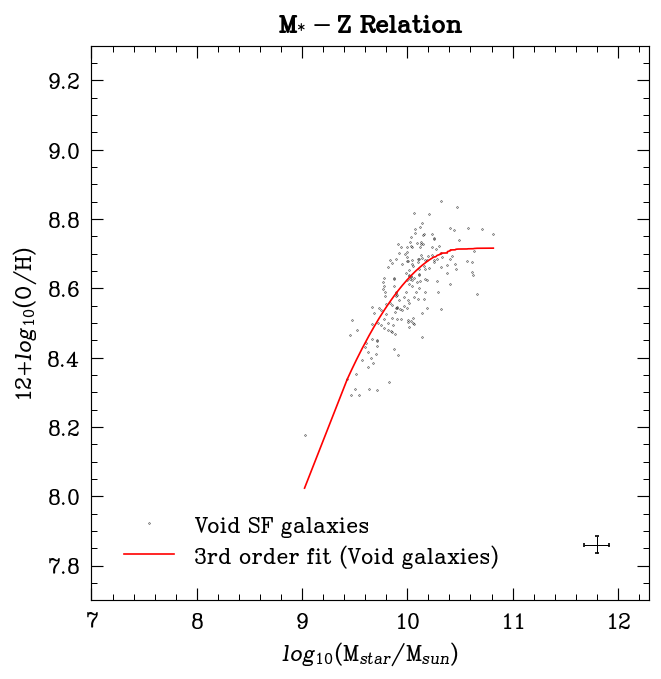

Coeficientes del ajuste: [-0.01541886  0.16076369  1.74681787 -9.50047776]


In [27]:
#O3N2
O3N2_void=log10((array(void["FLUX_CORRECT_OIII5007"])/array(void["FLUX_CORRECT_Hb"]))/(array(void["FLUX_CORRECT_NII6583"])/array(void["FLUX_CORRECT_Ha"])))

#Calibration of Pettini & Pagel (2004)
PPO4_void=8.73-0.32*O3N2_void

#Seleccionamos el valor de PPO4 de sólo las galaxias SF
PPO4_SF_void=[]
logmstar_SF_void=[]
dellogmstar_SF_void=[]

Ha_SF_void=[]
Ha_SF_Error_void=[]
Hb_SF_void=[]
Hb_SF_Error_void=[]
OIII_SF_void=[]
OIII_SF_Error_void=[]
NII_SF_void=[]
NII_SF_Error_void=[]

EW_Ha_SF_void=[]
EW_Ha_SF_Error_void=[]

z_SF_void=[]
M_r_SF_void=[]

for i in range(len(void["FLUX_CORRECT_Ha"])):
    if void["GALAXY_TYPE"][i]=="SF" and void["logmstar"][i]!=-99:
        
        PPO4_SF_void.append(PPO4_void[i])
        logmstar_SF_void.append(void["logmstar"][i]) 
        dellogmstar_SF_void.append(void["dellogmstar"][i])
        
        Ha_SF_void.append(void["FLUX_CORRECT_Ha"][i])
        Ha_SF_Error_void.append(void["FLUX_ERROR_24"][i])
        Hb_SF_void.append(void["FLUX_CORRECT_Hb"][i])
        Hb_SF_Error_void.append(void["FLUX_ERROR_15"][i])
        OIII_SF_void.append(void["FLUX_CORRECT_OIII5007"][i])
        OIII_SF_Error_void.append(void["FLUX_ERROR_17"][i])
        NII_SF_void.append(void["FLUX_CORRECT_NII6583"][i])
        NII_SF_Error_void.append(void["FLUX_ERROR_25"][i])

        EW_Ha_SF_void.append(void["EW_24"][i])
        EW_Ha_SF_Error_void.append(void["EW_ERROR_24"][i])
        
        z_SF_void.append(void["Z_TONRY"][i])
        M_r_SF_void.append(void["M_r"][i])

#Ploteamos M-Z Relation 
plot(logmstar_SF_void,PPO4_SF_void,".",markersize=0.5,color="black",label="Void SF galaxies")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_void),yerr=0.0248389164321768,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS
p_void=polyfit(ravel(logmstar_SF_void),ravel(PPO4_SF_void),3) #calcula coeficientes del polinomio de orden 3
y_fit_void=polyval(p_void,ravel(logmstar_SF_void)) #crea función polinómica con los coeficientes obtenidos

#Calculamos pesos (necesarios para el ajuste polinomial)
w_void=[]
resid_void=[]
for m in range(len(y_fit_void)):
    resid_void.append(PPO4_SF_void[m]-y_fit_void[m])
    w_void.append(1/resid_void[m]**2)

#Ajuste por polinomios con w
p_w_void=polyfit(ravel(logmstar_SF_void),ravel(PPO4_SF_void),3,w=ravel(w_void)) #calcula coeficientes del polinomio de orden 3 con pesos (w)
y_fit_w_void=polyval(p_w_void,ravel(logmstar_SF_void)) #crea función polinómica con los coeficientes obtenidos con pesos (w)

plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"-",color="red",label="3rd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
legend()
#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

print("Coeficientes del ajuste:",p_w_void)


#### Filaments Metallicities

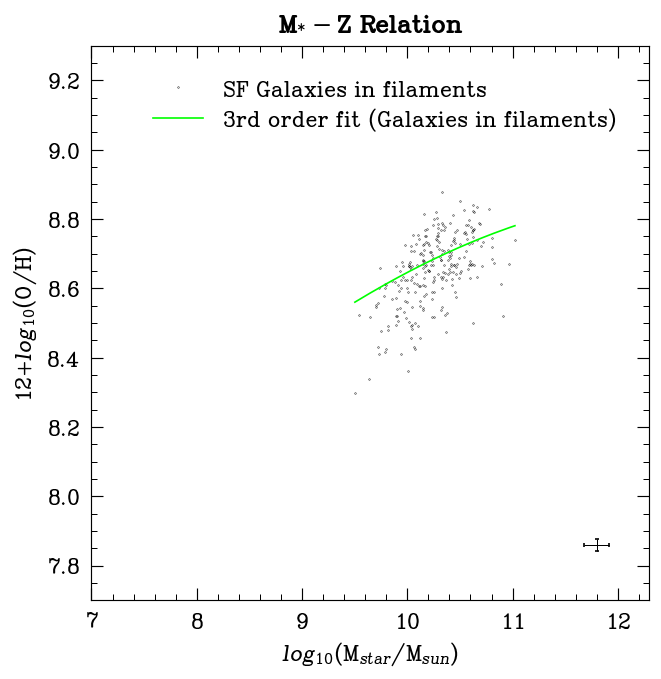

Coeficientes del ajuste: [-1.17900558e-03  9.53372131e-03  3.22585635e-01  5.64577326e+00]


In [28]:
#O3N2
O3N2_fil=log10((array(fil["FLUX_CORRECT_OIII5007"])/array(fil["FLUX_CORRECT_Hb"]))/(array(fil["FLUX_CORRECT_NII6583"])/array(fil["FLUX_CORRECT_Ha"])))

#Calibration of Pettini & Pagel (2004)
PPO4_fil=8.73-0.32*O3N2_fil

#Seleccionamos el valor de PPO4 de sólo las galaxias SF
PPO4_SF_fil=[]
logmstar_SF_fil=[]
dellogmstar_SF_fil=[]

Ha_SF_fil=[]
Ha_SF_Error_fil=[]
Hb_SF_fil=[]
Hb_SF_Error_fil=[]
OIII_SF_fil=[]
OIII_SF_Error_fil=[]
NII_SF_fil=[]
NII_SF_Error_fil=[]

EW_Ha_SF_fil=[]
EW_Ha_SF_Error_fil=[]

z_SF_fil=[]
M_r_SF_fil=[]

for i in range(len(fil["FLUX_CORRECT_Ha"])):
    if fil["GALAXY_TYPE"][i]=="SF" and fil["logmstar"][i]!=-99:
        PPO4_SF_fil.append(PPO4_fil[i])
        logmstar_SF_fil.append(fil["logmstar"][i]) 
        dellogmstar_SF_fil.append(fil["dellogmstar"][i])
        
        Ha_SF_fil.append(fil["FLUX_CORRECT_Ha"][i])
        Ha_SF_Error_fil.append(fil["FLUX_ERROR_24"][i])
        Hb_SF_fil.append(fil["FLUX_CORRECT_Hb"][i])
        Hb_SF_Error_fil.append(fil["FLUX_ERROR_15"][i])
        OIII_SF_fil.append(fil["FLUX_CORRECT_OIII5007"][i])
        OIII_SF_Error_fil.append(fil["FLUX_ERROR_17"][i])
        NII_SF_fil.append(fil["FLUX_CORRECT_NII6583"][i])
        NII_SF_Error_fil.append(fil["FLUX_ERROR_25"][i])
        
        EW_Ha_SF_fil.append(fil["EW_24"][i])
        EW_Ha_SF_Error_fil.append(fil["EW_ERROR_24"][i])
        
        z_SF_fil.append(fil["Z_TONRY"][i])
        M_r_SF_fil.append(fil["M_r"][i])

#Ploteamos M-Z Relation 
plot(logmstar_SF_fil,PPO4_SF_fil,".",markersize=0.5,color="black",label="SF Galaxies in filaments")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_fil),yerr=0.0175045433154089,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS
p_fil=polyfit(ravel(logmstar_SF_fil),ravel(PPO4_SF_fil),3) #calcula coeficientes del polinomio de orden 3
y_fit_fil=polyval(p_fil,ravel(logmstar_SF_fil)) #crea función polinómica con los coeficientes obtenidos

#Calculamos pesos (necesarios para el ajuste polinomial)
w_fil=[]
resid_fil=[]
for m in range(len(y_fit_fil)):
    resid_fil.append(PPO4_SF_fil[m]-y_fit_fil[m])
    w_fil.append(1/resid_fil[m]**2)

#Ajuste por polinomios con w
p_w_fil=polyfit(ravel(logmstar_SF_fil),ravel(PPO4_SF_fil),3,w=ravel(w_fil)) #calcula coeficientes del polinomio de orden 3 con pesos (w)
y_fit_w_fil=polyval(p_w_fil,ravel(logmstar_SF_fil)) #crea función polinómica con los coeficientes obtenidos con pesos (w)

plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"-",color="lime",label="3rd order fit (Galaxies in filaments)",linewidth=1) #ajuste polinomial con pesos (w)
legend()

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

print("Coeficientes del ajuste:",p_w_fil)

#### Tendrils Metallicities

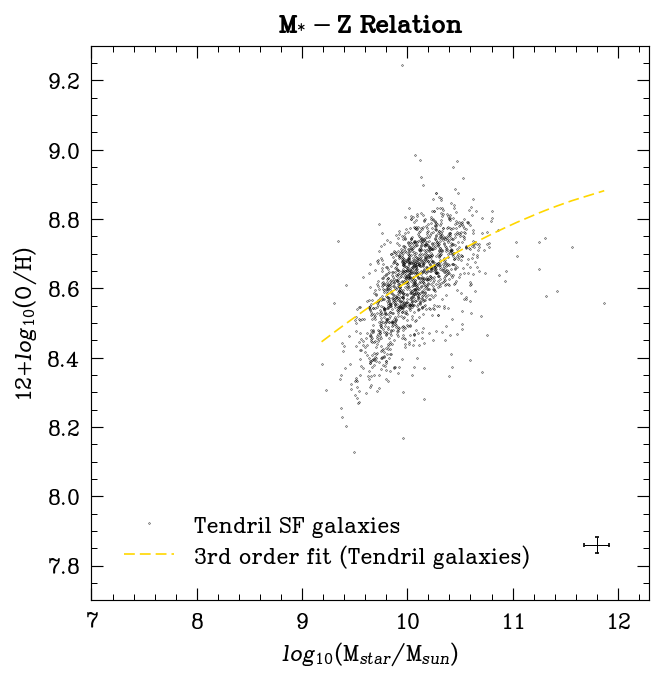

Coeficientes del ajuste: [-1.23848750e-03  1.14924632e-02  3.34458802e-01  5.36384903e+00]


In [29]:
#O3N2
O3N2_tendril=log10((array(tendril["FLUX_CORRECT_OIII5007"])/array(tendril["FLUX_CORRECT_Hb"]))/(array(tendril["FLUX_CORRECT_NII6583"])/array(tendril["FLUX_CORRECT_Ha"])))

#Calibration of Pettini & Pagel (2004)
PPO4_tendril=8.73-0.32*O3N2_tendril

#Seleccionamos el valor de PPO4 de sólo las galaxias SF
PPO4_SF_tendril=[]
logmstar_SF_tendril=[]
dellogmstar_SF_tendril=[]

Ha_SF_tendril=[]
Ha_SF_Error_tendril=[]
Hb_SF_tendril=[]
Hb_SF_Error_tendril=[]
OIII_SF_tendril=[]
OIII_SF_Error_tendril=[]
NII_SF_tendril=[]
NII_SF_Error_tendril=[]

EW_Ha_SF_tendril=[]
EW_Ha_SF_Error_tendril=[]

z_SF_tendril=[]
M_r_SF_tendril=[]

for i in range(len(tendril["FLUX_CORRECT_Ha"])):
    if tendril["GALAXY_TYPE"][i]=="SF" and tendril["logmstar"][i]!=-99:
        PPO4_SF_tendril.append(PPO4_tendril[i])
        logmstar_SF_tendril.append(tendril["logmstar"][i]) 
        dellogmstar_SF_tendril.append(tendril["dellogmstar"][i])
        
        Ha_SF_tendril.append(tendril["FLUX_CORRECT_Ha"][i])
        Ha_SF_Error_tendril.append(tendril["FLUX_ERROR_24"][i])
        Hb_SF_tendril.append(tendril["FLUX_CORRECT_Hb"][i])
        Hb_SF_Error_tendril.append(tendril["FLUX_ERROR_15"][i])
        OIII_SF_tendril.append(tendril["FLUX_CORRECT_OIII5007"][i])
        OIII_SF_Error_tendril.append(tendril["FLUX_ERROR_17"][i])
        NII_SF_tendril.append(tendril["FLUX_CORRECT_NII6583"][i])
        NII_SF_Error_tendril.append(tendril["FLUX_ERROR_25"][i])       
        
        EW_Ha_SF_tendril.append(tendril["EW_24"][i])
        EW_Ha_SF_Error_tendril.append(tendril["EW_ERROR_24"][i])
        
        z_SF_tendril.append(tendril["Z_TONRY"][i])
        M_r_SF_tendril.append(tendril["M_r"][i])

#Ploteamos M-Z Relation 
plot(logmstar_SF_tendril,PPO4_SF_tendril,".",markersize=0.5,color="black",label="Tendril SF galaxies")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_tendril),yerr=0.0232942981804439,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS
p_tendril=polyfit(ravel(logmstar_SF_tendril),ravel(PPO4_SF_tendril),3) #calcula coeficientes del polinomio de orden 3
y_fit_tendril=polyval(p_tendril,ravel(logmstar_SF_tendril)) #crea función polinómica con los coeficientes obtenidos

#Calculamos pesos (necesarios para el ajuste polinomial)
w_tendril=[]
resid_tendril=[]
for m in range(len(y_fit_tendril)):
    resid_tendril.append(PPO4_SF_tendril[m]-y_fit_tendril[m])
    w_tendril.append(1/resid_tendril[m]**2)

#Ajuste por polinomios con w
p_w_tendril=polyfit(ravel(logmstar_SF_tendril),ravel(PPO4_SF_tendril),3,w=ravel(w_tendril)) #calcula coeficientes del polinomio de orden 3 con pesos (w)
y_fit_w_tendril=polyval(p_w_tendril,ravel(logmstar_SF_tendril)) #crea función polinómica con los coeficientes obtenidos con pesos (w)

plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="gold",label="3rd order fit (Tendril galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
legend()

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

print("Coeficientes del ajuste:",p_w_tendril)

#### All the metallicities with their fits

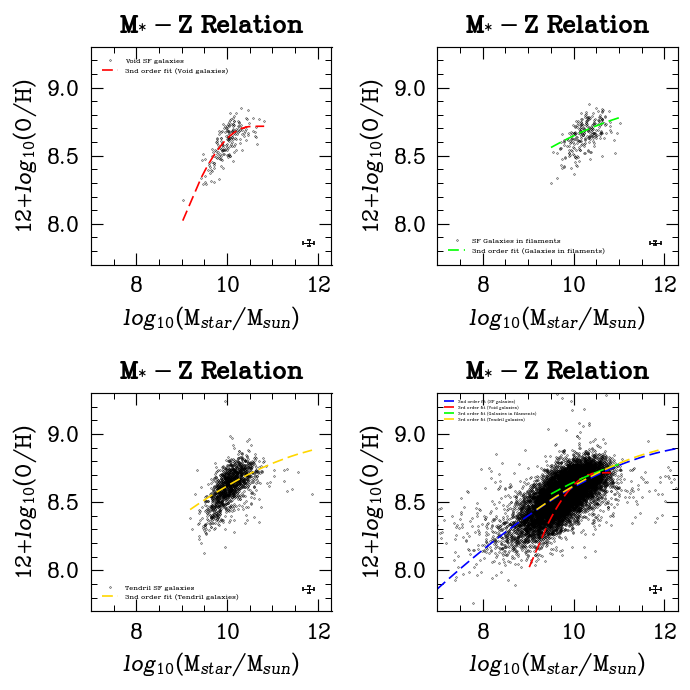

In [30]:
fig,axs=subplots(2,2) #juntar grafiguras en una figura

#Ploteamos M-Z Relation (VOID GALAXIES)
axs[0,0].plot(logmstar_SF_void,PPO4_SF_void,".",markersize=0.5,color="black",label="Void SF galaxies")

axs[0,0].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[0,0].set_ylabel("12+$log_{10}$(O/H)")
axs[0,0].set_title("M$_{*}-$Z Relation",weight="bold")

axs[0,0].set_xlim(7,12.3)
axs[0,0].set_ylim(7.7,9.3)

axs[0,0].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_void),yerr=0.0248389164321768,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[0,0].plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"--",color="red",label="3nd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[0,0].legend(fontsize=5)

#Ploteamos M-Z Relation (TEDNRIL GALAXIES)
axs[1,0].plot(logmstar_SF_tendril,PPO4_SF_tendril,".",markersize=0.5,color="black",label="Tendril SF galaxies")

axs[1,0].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[1,0].set_ylabel("12+$log_{10}$(O/H)")
axs[1,0].set_title("M$_{*}-$Z Relation",weight="bold")

axs[1,0].set_xlim(7,12.3)
axs[1,0].set_ylim(7.7,9.3)

axs[1,0].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_tendril),yerr=0.0232942981804439,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[1,0].plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="gold",label="3nd order fit (Tendril galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,0].legend(fontsize=5)

#Ploteamos M-Z Relation (GALAXIES IN FILAMENTS)
axs[0,1].plot(logmstar_SF_fil,PPO4_SF_fil,".",markersize=0.5,color="black",label="SF Galaxies in filaments")

axs[0,1].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[0,1].set_ylabel("12+$log_{10}$(O/H)")
axs[0,1].set_title("M$_{*}-$Z Relation",weight="bold")

axs[0,1].set_xlim(7,12.3)
axs[0,1].set_ylim(7.7,9.3)

axs[0,1].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_fil),yerr=0.0175045433154089,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[0,1].plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"--",color="lime",label="3nd order fit (Galaxies in filaments)",linewidth=1) #ajuste polinomial con pesos (w)
axs[0,1].legend(fontsize=5)

#Ploteamos M-Z Relation (SF GALAXIES)
axs[1,1].plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black")

axs[1,1].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[1,1].set_ylabel("12+$log_{10}$(O/H)")
axs[1,1].set_title("M$_{*}-$Z Relation",weight="bold")

axs[1,1].set_xlim(7,12.3)
axs[1,1].set_ylim(7.7,9.3)

axs[1,1].errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[1,1].plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3nd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,1].plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"--",color="red",label="3rd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,1].plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"--",color="lime",label="3rd order fit (Galaxies in filaments)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,1].plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="gold",label="3rd order fit (Tendril galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,1].legend(fontsize=3)

fig.tight_layout() #ajustar figuras

#GUARDAR PLOT
#savefig("metalicidades.pdf",bbox_inches="tight") 
show()


#### All Metallicities

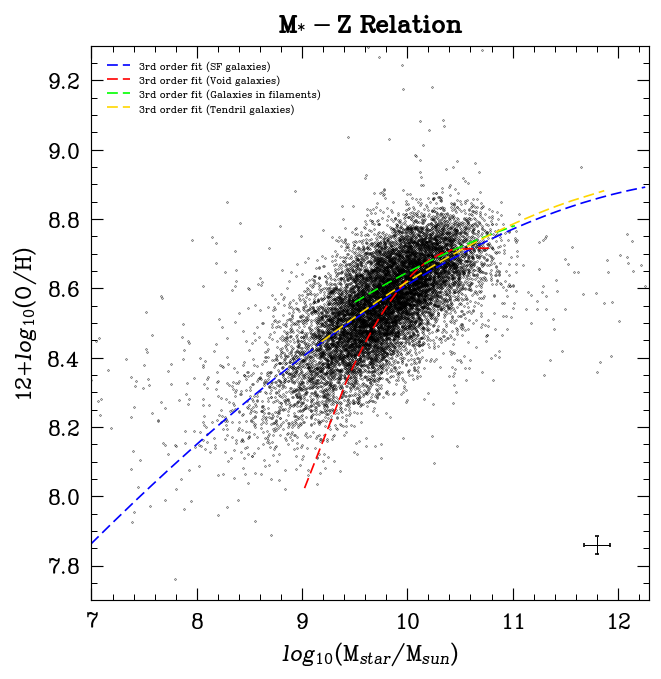

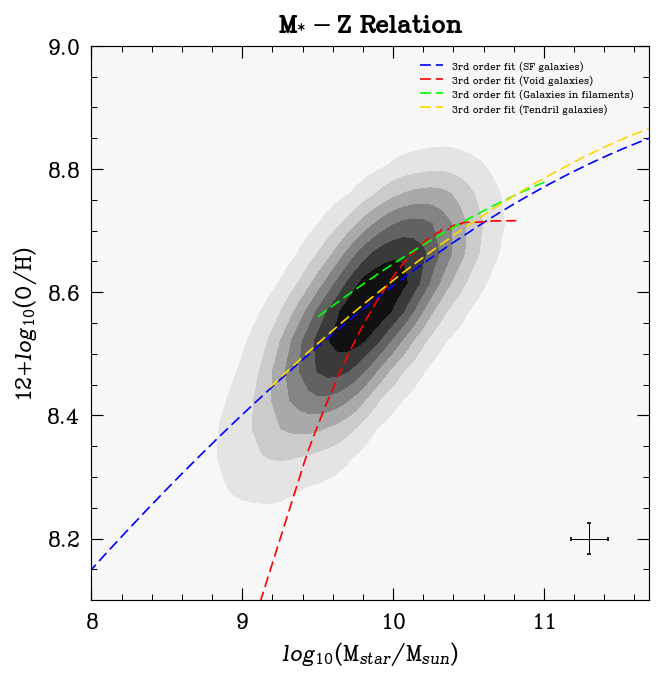

In [31]:
#Ploteamos M-Z Relation 
plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"--",color="red",label="3rd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"--",color="lime",label="3rd order fit (Galaxies in filaments)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="gold",label="3rd order fit (Tendril galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
legend(fontsize=7)

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

#Crea el gráfico de densidad de puntos difuminados
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(8,11.7)
ylim(8.1,9)

errorbar(11.3,8.2,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"--",color="red",label="3rd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"--",color="lime",label="3rd order fit (Galaxies in filaments)",linewidth=1) #ajuste polinomial con pesos (w)
plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="gold",label="3rd order fit (Tendril galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
legend(fontsize=7)

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

Por tanto, sus coeficientes de orden 0 son: 

|                      | SF galaxies           | Galaxies in filaments  | Tendril galaxies       | Void galaxies          |
|----------------------|-----------------------|------------------------|------------------------|------------------------|
| Coeff.               | 5.4677 dex            | 5.4733 dex             | 5.4766 dex             | 5.4640 dex             |


#### Residuals

Calculamos los reisudos para comprobar la robustez de los ajustes:

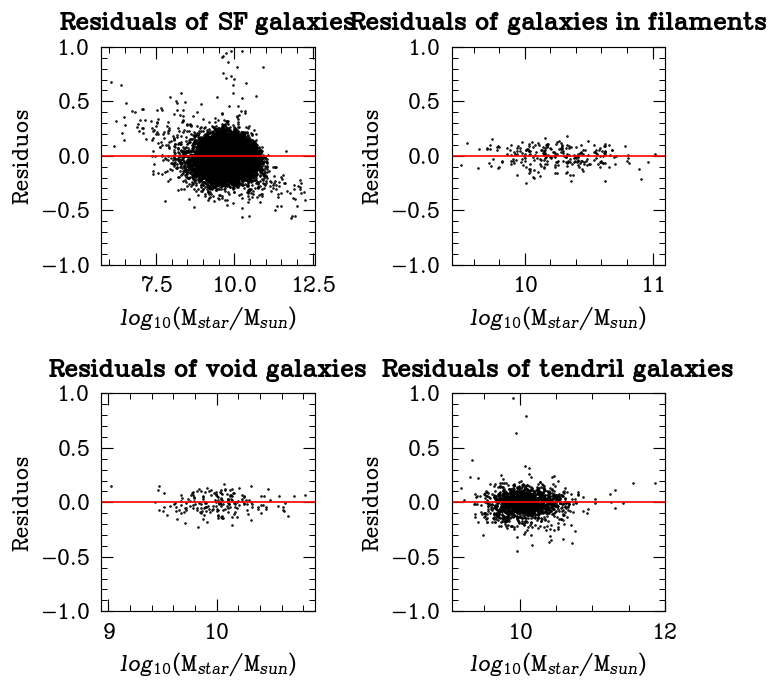

In [32]:
fig,axs=subplots(2,2) #juntar grafiguras en una figura

#Residuos Galaxias SF
axs[0,0].scatter(ravel(logmstar_SF),resid,s=0.3,color="black")
axs[0,0].axhline(y=0,color="red",linestyle="-",linewidth=1)
axs[0,0].set_title("Residuals of SF galaxies",weight="bold")
axs[0,0].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[0,0].set_ylabel("Residuos")
axs[0,0].set_ylim(-1,1)

#Residuos Void Galaxies
axs[1,0].scatter(ravel(logmstar_SF_void),resid_void,s=0.3,color="black")
axs[1,0].axhline(y=0,color="red",linestyle="-",linewidth=1)
axs[1,0].set_title("Residuals of void galaxies",weight="bold")
axs[1,0].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[1,0].set_ylabel("Residuos")
axs[1,0].set_ylim(-1,1)

#Residuos Galaxies in Filaments
axs[0,1].scatter(ravel(logmstar_SF_fil),resid_fil,s=0.3,color="black")
axs[0,1].axhline(y=0,color="red",linestyle="-",linewidth=1)
axs[0,1].set_title("Residuals of galaxies in filaments",weight="bold")
axs[0,1].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[0,1].set_ylabel("Residuos")
axs[0,1].set_ylim(-1,1)

#Reisudos Tendril Galaxies
axs[1,1].scatter(ravel(logmstar_SF_tendril),resid_tendril,s=0.3,color="black")
axs[1,1].axhline(y=0,color="red",linestyle="-",linewidth=1)
axs[1,1].set_title("Residuals of tendril galaxies",weight="bold")
axs[1,1].set_xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
axs[1,1].set_ylabel("Residuos")
axs[1,1].set_ylim(-1,1)

fig.tight_layout() #ajustar figuras

#GUARDAR PLOT
#savefig("residuals.pdf",bbox_inches="tight") 
show()

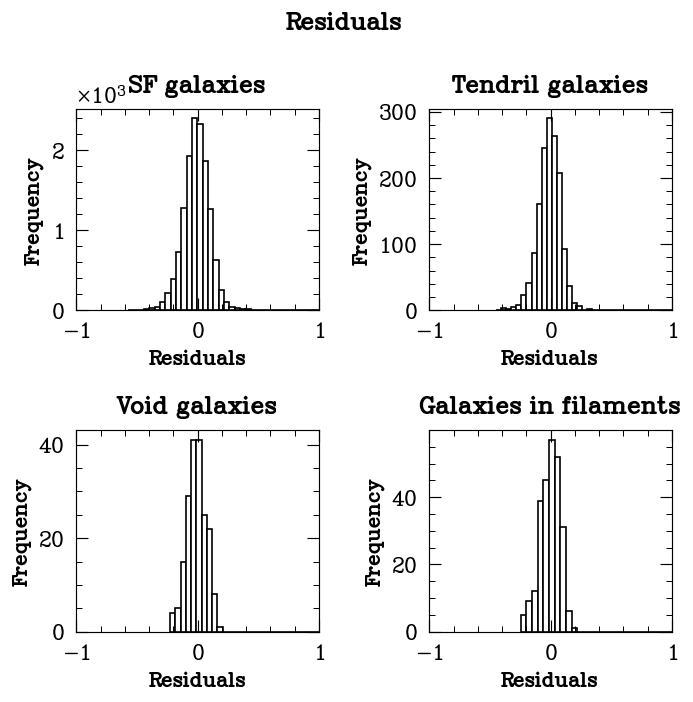

In [33]:
fig,axs=subplots(2,2) #juntar grafiguras en una figura
fig.suptitle("Residuals",weight="bold")
#fig=figure(figsize=(3.6,4))

#Residuos Galaxias SF
axs[0,0].hist(ravel(resid),bins=100,density=False,edgecolor="black",color="white")
axs[0,0].set_title("SF galaxies",weight="bold")
axs[0,0].set_xlabel("Residuals",weight="bold")
axs[0,0].set_ylabel("Frequency",weight="bold")
axs[0,0].set_xlim(-1,1)

#Residuos Tendril Galaxias 
axs[0,1].hist(ravel(resid_tendril),bins=100,density=False,edgecolor="black",color="white")
axs[0,1].set_title("Tendril galaxies",weight="bold")
axs[0,1].set_xlabel("Residuals",weight="bold")
axs[0,1].set_ylabel("Frequency",weight="bold")
axs[0,1].set_xlim(-1,1)

#Residuos Void Galaxies
axs[1,0].hist(ravel(resid_void),bins=40,density=False,edgecolor="black",color="white")
axs[1,0].set_title("Void galaxies",weight="bold")
axs[1,0].set_xlabel("Residuals",weight="bold")
axs[1,0].set_ylabel("Frequency",weight="bold")
axs[1,0].set_xlim(-1,1)

#Residuos Galaxias in Filaments
axs[1,1].hist(ravel(resid_fil),bins=35,density=False,edgecolor="black",color="white")
axs[1,1].set_title("Galaxies in filaments",weight="bold")
axs[1,1].set_xlabel("Residuals",weight="bold")
axs[1,1].set_ylabel("Frequency",weight="bold")
axs[1,1].set_xlim(-1,1)

fig.tight_layout() #ajustar figuras

#GUARDAR PLOT
#savefig("Residuals.pdf",bbox_inches="tight") 
show()

#### We add the CATAID of the outlier galaxies in a DataFrame

In [34]:
#CATAID_rare=[] #adjuntamos el CATAID de las galaxias con algún AoN>200 (no son todas las outliers necesariamente)

#for i in range(len(AoN_Ha)):
    #if GAMA["SELECTED_GALAXIES"][i]==1:
        #if GAMA["AON_24"][i]>200 or GAMA["AON_15"][i]>200 or GAMA["AON_25"][i]>200 or GAMA["AON_17"][i]>200:
            #CATAID_rare.append(GAMA["CATAID_1"][i])

#data_frame_CATAID_outliers=DataFrame(CATAID_rare,columns=["outliers galaxies"]) #DataFrame BPT con CATAID de los outliers

#EXPORTAMOS el DataFrame a .txt (SÓLO UNA VEZ)
#path=r"C:\Users\juana\OneDrive\Escritorio\Juanan\UCM\TFG\MyJob\data_frame_CATAID_outliers.txt" #donde lo exportamos

#with open(path,"a") as f: #exportación
    #data_frame_CATAID_outliers_string=data_frame_CATAID_outliers.to_string(header=False,index=False)
    #f.write(data_frame_CATAID_outliers_string)

## 11. Metallicities of Filaments, Void and Tendrils with fixed coefficientes a, b and c

Volvemos a calcular la M-Z Relation para galaxias en filamentos, voids y tendrils pero ahora por el método del ajuste por punto cero. Esto nos perimitirá comparar los diferentes ajustes maneteniendo la pendiente y coeficientes de orden superior constantes. De esta forma, nos interesará ver las diferencias en los coeficientes de orden cero de los dieferentes ajustes (Ellison et al 2008).

#### Metallicities Voids with fixed coefficients a, b, and c

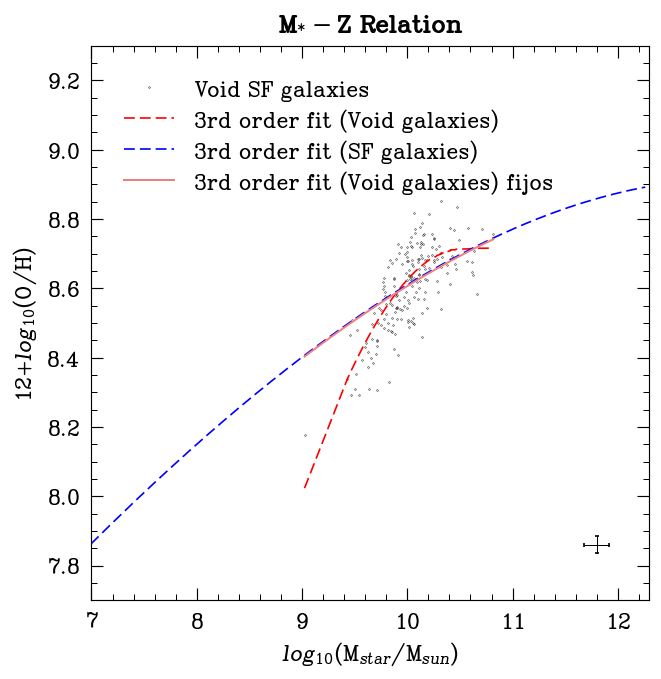

Coeficientes SF:  [-1.16349265e-03  1.04329863e-02  3.26303412e-01  5.46767976e+00]
Coeficientes Void:  [-0.01541886  0.16076369  1.74681787 -9.50047776]
Coeficiente d Void Fijos:  [5.4639791]


In [35]:
#PLOTEAMOS M-Z RELATION VOIDS
plot(logmstar_SF_void,PPO4_SF_void,".",markersize=0.5,color="black",label="Void SF galaxies")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_void),yerr=0.0248389164321768,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS CON W VOID
plot(sorted(ravel(logmstar_SF_void)),sorted(y_fit_w_void),"--",color="red",label="3rd order fit (Void galaxies)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS CON W DE LAS SF
plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS FIJANDO LOS COEFICEINTES a,b y c
a,b,c=p_w[0],p_w[1],p_w[2]
d_0_void=p_w_void[3]

#Modelo con a,b y c fijos
def model_void(x_void,d_void):
    return a*x_void**3+b*x_void**2+c*x_void+d_void

#Ajuste con a,b y c fijos
coef_void,cov_void=curve_fit(model_void,ravel(logmstar_SF_void),ravel(PPO4_SF_void),p0=[d_0_void])

x_modelo_void=linspace(min(logmstar_SF_void),max(logmstar_SF_void),100)
y_modelo_void=model_void(x_modelo_void,coef_void[0])

plot(x_modelo_void,y_modelo_void,color="lightcoral",label="3rd order fit (Void galaxies) fijos") #ajuste polinomial con pesos (w) y a,b y c fijos
legend()
show()

print("Coeficientes SF: ",p_w)
print("Coeficientes Void: ",p_w_void)
print("Coeficiente d Void Fijos: ",coef_void)

#### Metallicities Filaments with fixed coefficients a, b, and c

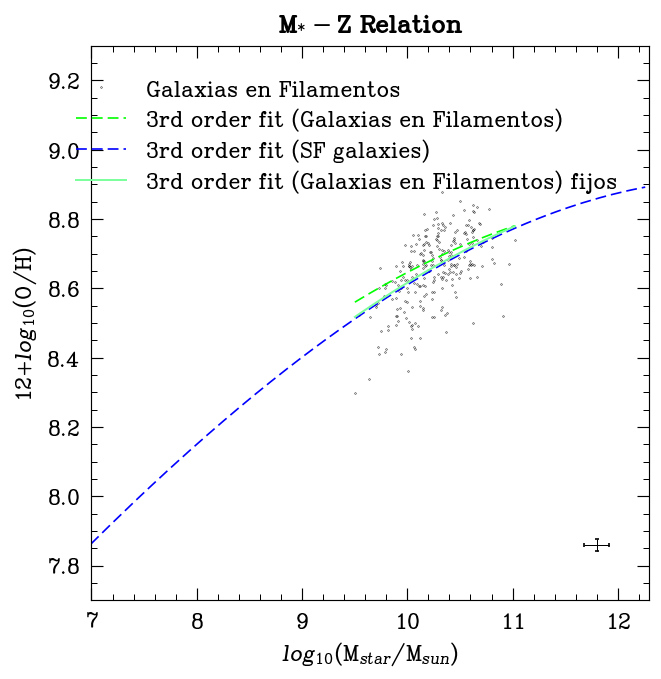

Coeficientes SF:  [-1.16349265e-03  1.04329863e-02  3.26303412e-01  5.46767976e+00]
Coeficientes Filamentos:  [-1.17900558e-03  9.53372131e-03  3.22585635e-01  5.64577326e+00]
Coeficientes d Filamentos Fijos:  [5.4732876]


In [36]:
#PLOTEAMOS M-Z RELATION FILAMENTOS
plot(logmstar_SF_fil,PPO4_SF_fil,".",markersize=0.5,color="black",label="Galaxias en Filamentos")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_fil),yerr=0.0175045433154089,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS CON W FILAMENTOS
plot(sorted(ravel(logmstar_SF_fil)),sorted(y_fit_w_fil),"--",color="lime",label="3rd order fit (Galaxias en Filamentos)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS CON W DE LAS SF
plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS FIJANDO LOS COEFICEINTES a,b y c
a,b,c=p_w[0],p_w[1],p_w[2]
d_0_fil=p_w_fil[3]

#Modelo con a,b y c fijos
def model_fil(x_fil,d_fil):
    return a*x_fil**3+b*x_fil**2+c*x_fil+d_fil

#Ajuste con a,b y c fijos
coef_fil,cov_fil=curve_fit(model_fil,ravel(logmstar_SF_fil),ravel(PPO4_SF_fil),p0=[d_0_fil])

x_modelo_fil=linspace(min(logmstar_SF_fil),max(logmstar_SF_fil),100)
y_modelo_fil=model_fil(x_modelo_fil,coef_fil[0])

plot(x_modelo_fil,y_modelo_fil,color="#7eff9e",label="3rd order fit (Galaxias en Filamentos) fijos") #ajuste polinomial con pesos (w) y a,b y c fijos
legend()
show()

print("Coeficientes SF: ",p_w)
print("Coeficientes Filamentos: ",p_w_fil)
print("Coeficientes d Filamentos Fijos: ",coef_fil)

#### Metallicities Tendrils with fixed coefficients a, b, and c

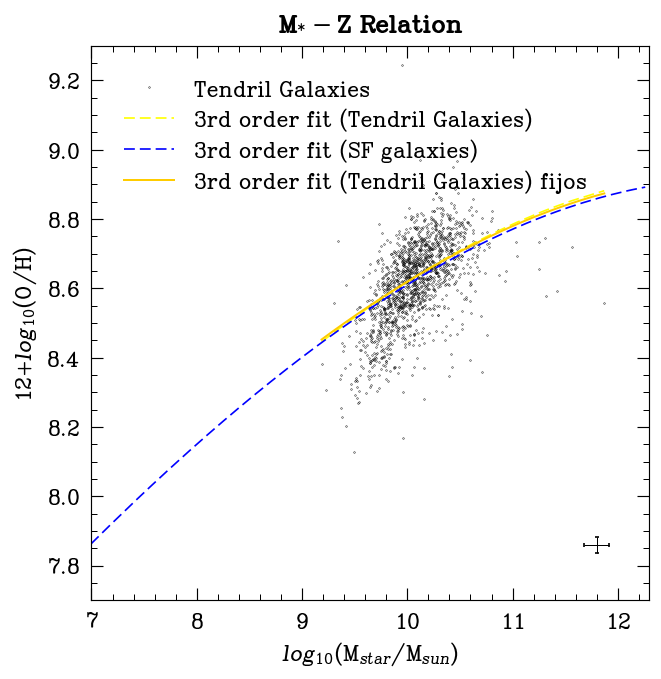

Coeficientes SF:  [-1.16349265e-03  1.04329863e-02  3.26303412e-01  5.46767976e+00]
Coeficientes Tendril:  [-1.23848750e-03  1.14924632e-02  3.34458802e-01  5.36384903e+00]
Coeficientes d Tendril Fijos:  [5.4766407]


In [37]:
#PLOTEAMOS M-Z RELATION TENDRILS
plot(logmstar_SF_tendril,PPO4_SF_tendril,".",markersize=0.5,color="black",label="Tendril Galaxies")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

xlim(7,12.3)
ylim(7.7,9.3)

errorbar(11.8,7.86,xerr=median(dellogmstar_SF_tendril),yerr=0.0232942981804439,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#AJUSTE POR POLINOMIOS CON W FILAMENTOS
plot(sorted(ravel(logmstar_SF_tendril)),sorted(y_fit_w_tendril),"--",color="yellow",label="3rd order fit (Tendril Galaxies)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS CON W DE LAS SF
plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)

#AJUSTE POR POLINOMIOS FIJANDO LOS COEFICEINTES a,b y c
a,b,c=p_w[0],p_w[1],p_w[2]
d_0_tendril=p_w_tendril[3]

#Modelo con a,b y c fijos
def model_tendril(x_tendril,d_tendril):
    return a*x_tendril**3+b*x_tendril**2+c*x_tendril+d_tendril

#Ajuste con a,b y c fijos
coef_tendril,cov_tendril=curve_fit(model_tendril,ravel(logmstar_SF_tendril),ravel(PPO4_SF_tendril),p0=[d_0_tendril])

x_modelo_tendril=linspace(min(logmstar_SF_tendril),max(logmstar_SF_tendril),100)
y_modelo_tendril=model_tendril(x_modelo_tendril,coef_tendril[0])

plot(x_modelo_tendril,y_modelo_tendril,color="#FFCC00",label="3rd order fit (Tendril Galaxies) fijos") #ajuste polinomial con pesos (w) y a,b y c fijos
legend()
show()

print("Coeficientes SF: ",p_w)
print("Coeficientes Tendril: ",p_w_tendril)
print("Coeficientes d Tendril Fijos: ",coef_tendril)

#### All metallicities with fixed coefficients a, b, and c

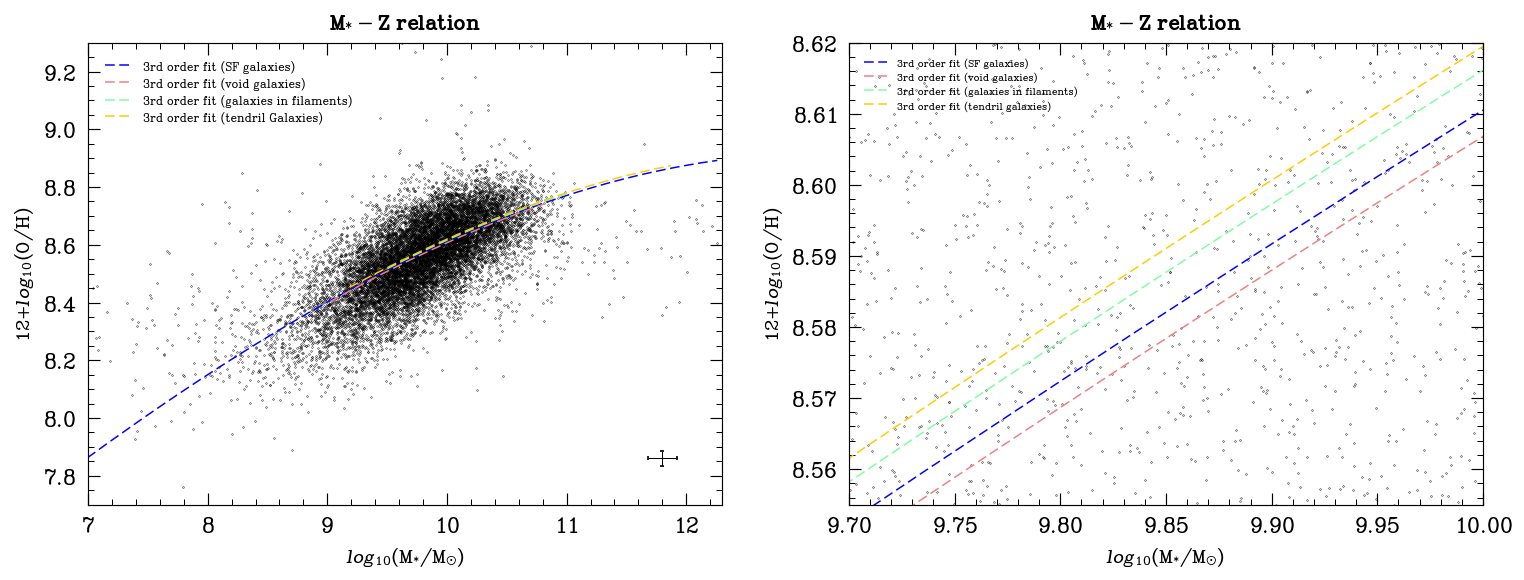

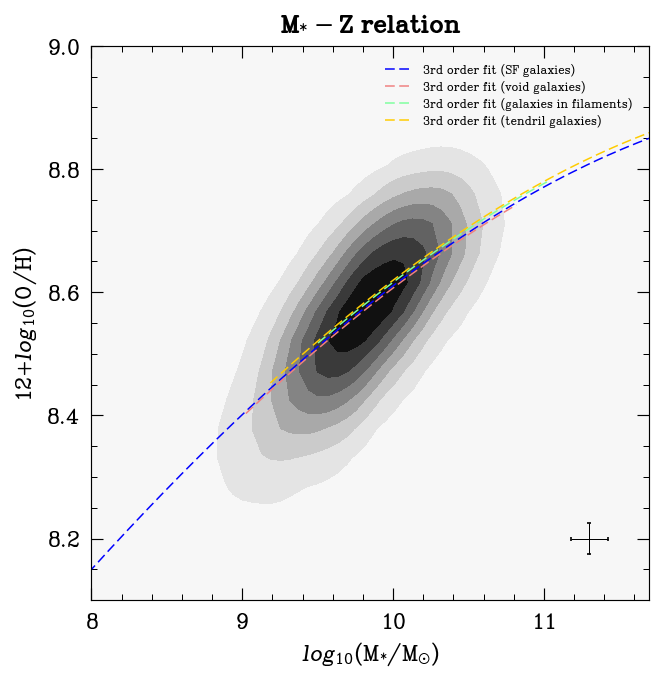

In [38]:
fig,(ax1,ax2)=subplots(1,2,figsize=(15,5))

#Ploteamos M-Z Relation SIN a,b,c FIJOS
ax1.plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black")

ax1.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=13)
ax1.set_ylabel("12+$log_{10}$(O/H)",fontsize=13)
ax1.set_title("M$_{*}-$Z relation",weight="bold",fontsize=15)

ax1.set_xlim(7,12.3)
ax1.set_ylim(7.7,9.3)

ax1.errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

ax1.plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w)
ax1.plot(x_modelo_void,y_modelo_void,"--",color="lightcoral",label="3rd order fit (void galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax1.plot(x_modelo_fil,y_modelo_fil,"--",color="#7eff9e",label="3rd order fit (galaxies in filaments)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax1.plot(x_modelo_tendril,y_modelo_tendril,"--",color="#FFCC00",label="3rd order fit (tendril Galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax1.legend(fontsize=8)

#Ploteamos M-Z Relation CON a,b,c FIJOS
ax2.plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black")

ax2.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=13)
ax2.set_ylabel("12+$log_{10}$(O/H)",fontsize=13)
ax2.set_title("M$_{*}-$Z relation",weight="bold",fontsize=15)

ax2.set_xlim(9.7,10)
ax2.set_ylim(8.555,8.62)

ax2.errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

ax2.plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w)
ax2.plot(x_modelo_void,y_modelo_void,"--",color="lightcoral",label="3rd order fit (void galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax2.plot(x_modelo_fil,y_modelo_fil,"--",color="#7eff9e",label="3rd order fit (galaxies in filaments)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax2.plot(x_modelo_tendril,y_modelo_tendril,"--",color="#FFCC00",label="3rd order fit (tendril galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
ax2.legend(fontsize=7)

#GUARDAR PLOT
#savefig("Metallicites_fits.pdf",bbox_inches="tight") 
show()

#Crea el gráfico de densidad de puntos difuminados
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys")

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z relation",weight="bold")

xlim(8,11.7)
ylim(8.1,9)

errorbar(11.3,8.2,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w)
plot(x_modelo_void,y_modelo_void,"--",color="lightcoral",label="3rd order fit (void galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
plot(x_modelo_fil,y_modelo_fil,"--",color="#7eff9e",label="3rd order fit (galaxies in filaments)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
plot(x_modelo_tendril,y_modelo_tendril,"--",color="#FFCC00",label="3rd order fit (tendril galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
legend(fontsize=8)

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()


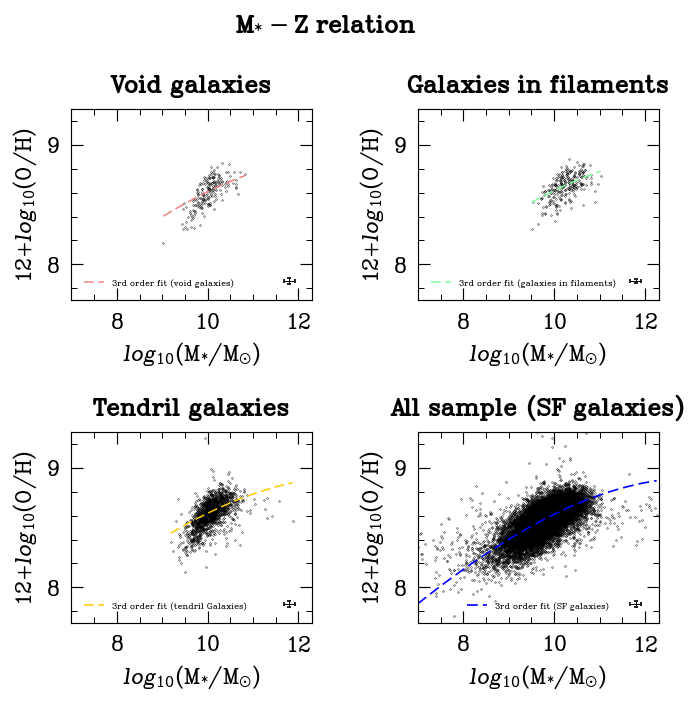

In [39]:
fig,axs=subplots(2,2) #juntar grafiguras en una figura
fig.suptitle("M$_{*}-$Z relation",weight="bold")

#Ploteamos M-Z Relation (VOID GALAXIES)
axs[0,0].plot(logmstar_SF_void,PPO4_SF_void,".",markersize=0.5,color="black")

axs[0,0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[0,0].set_ylabel("12+$log_{10}$(O/H)")
axs[0,0].set_title("Void galaxies",weight="bold")

axs[0,0].set_xlim(7,12.3)
axs[0,0].set_ylim(7.7,9.3)

axs[0,0].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_void),yerr=0.0248389164321768,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[0,0].plot(x_modelo_void,y_modelo_void,"--",color="lightcoral",label="3rd order fit (void galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos

axs[0,0].legend(fontsize=6)

#Ploteamos M-Z Relation (TENDRIL GALAXIES)
axs[1,0].plot(logmstar_SF_tendril,PPO4_SF_tendril,".",markersize=0.5,color="black")

axs[1,0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[1,0].set_ylabel("12+$log_{10}$(O/H)")
axs[1,0].set_title("Tendril galaxies",weight="bold")

axs[1,0].set_xlim(7,12.3)
axs[1,0].set_ylim(7.7,9.3)

axs[1,0].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_tendril),yerr=0.0232942981804439,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[1,0].plot(x_modelo_tendril,y_modelo_tendril,"--",color="#FFCC00",label="3rd order fit (tendril Galaxies)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos
axs[1,0].legend(fontsize=6)

#Ploteamos M-Z Relation (GALAXIES IN FILAMENTS)
axs[0,1].plot(logmstar_SF_fil,PPO4_SF_fil,".",markersize=0.5,color="black")

axs[0,1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[0,1].set_ylabel("12+$log_{10}$(O/H)")
axs[0,1].set_title("Galaxies in filaments",weight="bold")

axs[0,1].set_xlim(7,12.3)
axs[0,1].set_ylim(7.7,9.3)

axs[0,1].errorbar(11.8,7.86,xerr=median(dellogmstar_SF_fil),yerr=0.0175045433154089,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[0,1].plot(x_modelo_fil,y_modelo_fil,"--",color="#7eff9e",label="3rd order fit (galaxies in filaments)",linewidth=0.9) #ajuste polinomial con pesos (w) y a,b y c fijos

axs[0,1].legend(fontsize=6)

#Ploteamos M-Z Relation (SF GALAXIES)
axs[1,1].plot(logmstar_SF,PPO4_SF,".",markersize=0.5,color="black")

axs[1,1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[1,1].set_ylabel("12+$log_{10}$(O/H)")
axs[1,1].set_title("All sample (SF galaxies)",weight="bold")

axs[1,1].set_xlim(7,12.3)
axs[1,1].set_ylim(7.7,9.3)

axs[1,1].errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

axs[1,1].plot(sorted(ravel(logmstar_SF)),sorted(y_fit_w),"--",color="blue",label="3rd order fit (SF galaxies)",linewidth=1) #ajuste polinomial con pesos (w)
axs[1,1].legend(fontsize=6)

fig.tight_layout() #ajustar figuras

#GUARDAR PLOT
#savefig("Metallicities_comparation.pdf",bbox_inches="tight") 
show()

Por tanto, la diferencia entre sus coefientes son: 

|                           | Galaxies in filaments  | Tendril galaxies       | Void galaxies          |
|---------------------------|------------------------|------------------------|------------------------|
| Coeff. differences        | -0.0056 dex            | -0.0090 dex            | 0.0037 dex             |
| Coeff. differences (\%)   | 0.1026%                | 0.1639%                | -0.0677%               |


#### Histogram of Filaments, Voids, Tendrils and SF galaxies

Histogramas de las metalicidades para ver como se distribuyen:

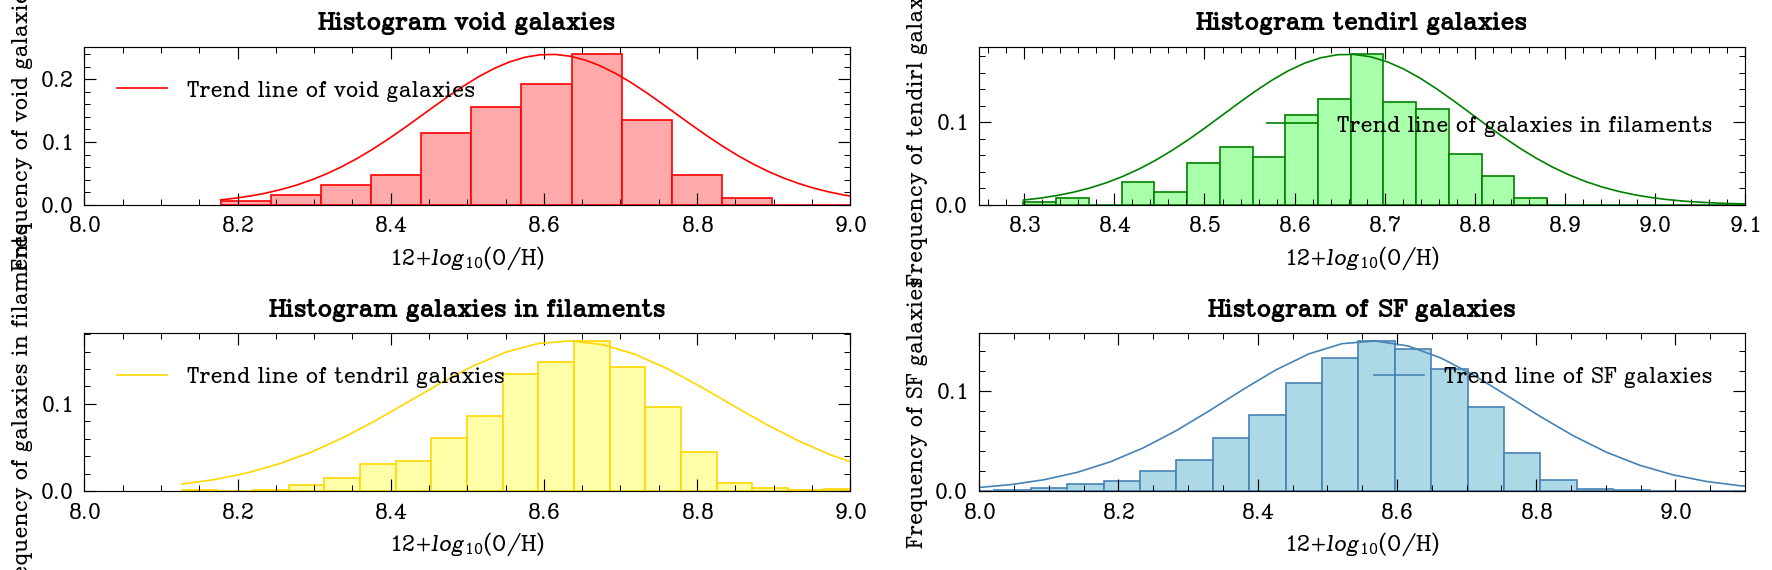

In [40]:
#fig,(ax1,ax2,ax3,ax4)=subplots(2,2)
fig,((ax1,ax2),(ax3,ax4))=subplots(2,2,figsize=(15,5))

#PPO4_SF_void
n_void,bins_void,patches_void=ax1.hist(PPO4_SF_void,bins=30,color="#FFAAAA",edgecolor="red",weights=ones(len(PPO4_SF_void))/len(PPO4_SF_void))

#ajuste de la línea de densidad
mu_void,sigma_void=mean(PPO4_SF_void),std(PPO4_SF_void)
x_void=linspace(min(PPO4_SF_void),max(PPO4_SF_void),100)
y_void=1/(sigma_void*sqrt(2*pi))*exp(-(x_void-mu_void)**2/(2*sigma_void**2))
scale_factor_void=max(n_void)/max(y_void) # factor de escala para ajustar la línea de densidad
ax1.plot(x_void,y_void*scale_factor_void,color="red",linestyle="-",linewidth=1,label="Trend line of void galaxies")

#ajuste de la altura de las barras
for i in range(len(patches_void)):
    patches_void[i].set_height(n_void[i])

#etiquetas y título
ax1.set_title("Histogram void galaxies", weight="bold")
ax1.set_xlabel("12+$log_{10}$(O/H)")
ax1.set_ylabel("Frequency of void galaxies")
ax1.set_xlim(8,9)
ax1.legend()

#PPO4_SF_fil
n_fil,bins_fil,patches_fil=ax2.hist(PPO4_SF_fil,bins=50,color="#AAFFAA",edgecolor="green",weights=ones(len(ravel(PPO4_SF_fil)))/len(ravel(PPO4_SF_fil)))

#ajuste de la línea de densidad
mu_fil,sigma_fil=mean(PPO4_SF_fil),std(PPO4_SF_fil)
x_fil=linspace(min(PPO4_SF_fil),max(PPO4_SF_fil),100)
y_fil=1/(sigma_fil*sqrt(2*pi))*exp(-(x_fil-mu_fil)**2/(2*sigma_fil**2))
scale_factor_fil=max(n_fil)/max(y_fil) # factor de escala para ajustar la línea de densidad
ax2.plot(x_fil,y_fil*scale_factor_fil,color="green",linestyle="-",linewidth=1,label="Trend line of galaxies in filaments")

#ajuste de la altura de las barras
for i in range(len(patches_fil)):
    patches_fil[i].set_height(n_fil[i])

#etiquetas y título
ax2.set_title("Histogram tendirl galaxies", weight="bold")
ax2.set_xlabel("12+$log_{10}$(O/H)")
ax2.set_ylabel("Frequency of tendirl galaxies")
ax2.set_xlim(8.25,9.1)
ax2.legend()

#PPO4_SF_tendril
n_tendril,bins_tendril,patches_tendril=ax3.hist(PPO4_SF_tendril,bins=90,color="#FFFFAA",edgecolor="gold",weights=ones(len(ravel(PPO4_SF_tendril)))/len(ravel(PPO4_SF_tendril)))

#ajuste de la línea de densidad
mu_tendril,sigma_tendril=mean(PPO4_SF_tendril),std(PPO4_SF_tendril)
x_tendril=linspace(min(PPO4_SF_tendril),max(PPO4_SF_tendril),100)
y_tendril=1/(sigma_tendril*sqrt(2*pi))*exp(-(x_tendril-mu_tendril)**2/(2*sigma_tendril**2))
scale_factor_tendril=max(n_tendril)/max(y_tendril) # factor de escala para ajustar la línea de densidad
ax3.plot(x_tendril,y_tendril*scale_factor_tendril,color="gold",linestyle="-",linewidth=1,label="Trend line of tendril galaxies")

#ajuste de la altura de las barras
for i in range(len(patches_tendril)):
    patches_tendril[i].set_height(n_tendril[i])

#etiquetas y título
ax3.set_title("Histogram galaxies in filaments",weight="bold")
ax3.set_xlabel("12+$log_{10}$(O/H)")
ax3.set_ylabel("Frequency of galaxies in filaments")
ax3.set_xlim(8,9)
ax3.legend()


#PPO4_SF
n_SF,bins_SF,patches_SF=ax4.hist(ravel(PPO4_SF),bins=90,color="#ADD8E6",edgecolor="#4682B4",weights=ones(len(ravel(PPO4_SF)))/len(ravel(PPO4_SF)))

#ajuste de la línea de densidad
mu_SF,sigma_SF=mean(PPO4_SF),std(PPO4_SF)
x_SF=linspace(min(PPO4_SF),max(PPO4_SF),100)
y_SF=1/(sigma_SF*sqrt(2*pi))*exp(-(x_SF-mu_SF)**2/(2*sigma_SF**2))
scale_factor_SF=max(n_SF)/max(y_SF) # factor de escala para ajustar la línea de densidad
ax4.plot(x_SF,y_SF*scale_factor_SF,color="#4682B4",linestyle="-",linewidth=1,label="Trend line of SF galaxies")

#ajuste de la altura de las barras
for i in range(len(patches_SF)):
    patches_SF[i].set_height(n_SF[i])

#etiquetas y título
ax4.set_title("Histogram of SF galaxies",weight="bold")
ax4.set_xlabel("12+$log_{10}$(O/H)")
ax4.set_ylabel("Frequency of SF galaxies")
ax4.set_xlim(8,9.1)
ax4.legend()

fig.tight_layout() #ajustar figuras

#GUARDAR PLOT
#savefig("test4.pdf",bbox_inches="tight") 

show()


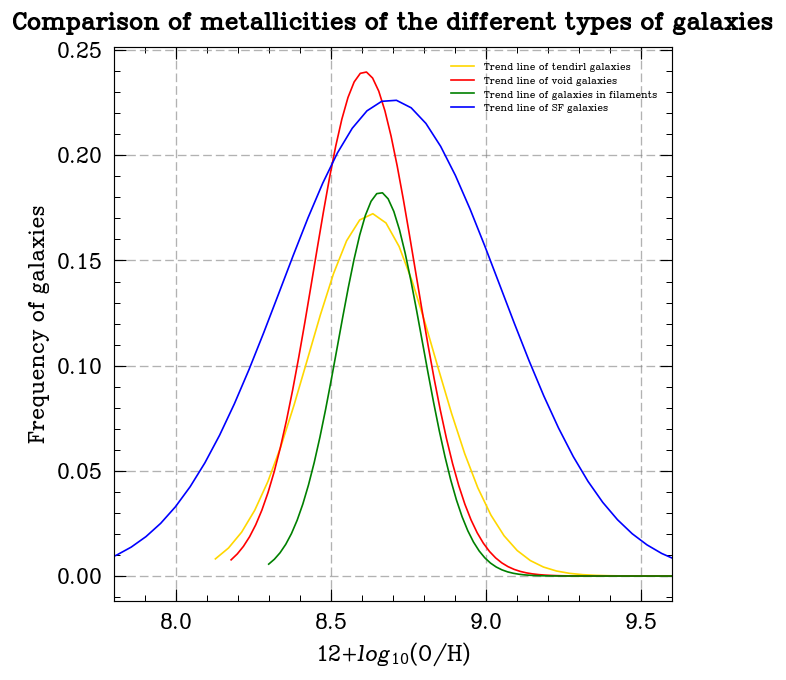

In [41]:
plot(x_tendril,y_tendril*scale_factor_tendril,color="gold",linestyle="-",linewidth=1,label="Trend line of tendirl galaxies")
#axvline(x=mean(PPO4_SF_tendril),linestyle="--",color="gold",label="Mean of tendril galaxies")
plot(x_void,y_void*scale_factor_void,color="red",linestyle="-",linewidth=1,label="Trend line of void galaxies")
#axvline(x=mean(PPO4_SF_void),linestyle="--",color="red",label="Mean of void galaxies")
plot(x_fil,y_fil*scale_factor_fil,color="green",linestyle="-",linewidth=1,label="Trend line of galaxies in filaments")
#axvline(x=mean(PPO4_SF_fil),linestyle="--",color="green",label="Mean of galaxies in filaments")
plot(x_SF,y_fil*scale_factor_SF,color="blue",linestyle="-",linewidth=1,label="Trend line of SF galaxies")
#axvline(x=mean(ravel(PPO4_SF)),linestyle="--",color="blue",label="Mean of SF galaxies")

title("Comparison of metallicities of the different types of galaxies",weight="bold")
xlabel("12+$log_{10}$(O/H)")
ylabel("Frequency of galaxies")
xlim(7.8,9.6)
legend(loc="upper right",fontsize=7)
grid(True)

#GUARDAR PLOT
#savefig("test3.pdf",bbox_inches="tight") 
show()


#### Determinations coefficients R$^2$

Coeficientes de determinación para comprobar la robustez de los ajustes:

In [42]:
r2=r2_score(ravel(PPO4_SF),y_fit_w,sample_weight=w)
r2_void=r2_score(ravel(PPO4_SF_void),y_fit_w_void,sample_weight=w_void)
r2_fil=r2_score(ravel(PPO4_SF_fil),y_fit_w_fil,sample_weight=w_fil)
r2_tendril=r2_score(ravel(PPO4_SF_tendril),y_fit_w_tendril,sample_weight=w_tendril)

print(r2_fil)
print(r2_tendril)
print(r2_void)
print(r2)

0.8549562006075475
0.8745254663230215
0.9996270131329479
0.9985803208130357


## 12. Outliers

Seleccionamos los outliers (galaxias raras) para trabajar con ellas mas adelante. Para ello, imponemos unas condiciones en la señal a ruido (AoN) para seleccionarlas.

#### We plot in red the galaxies with high S/N (outliers)

100%|███████████████████████████████████| 17342/17342 [00:09<00:00, 1743.62it/s]


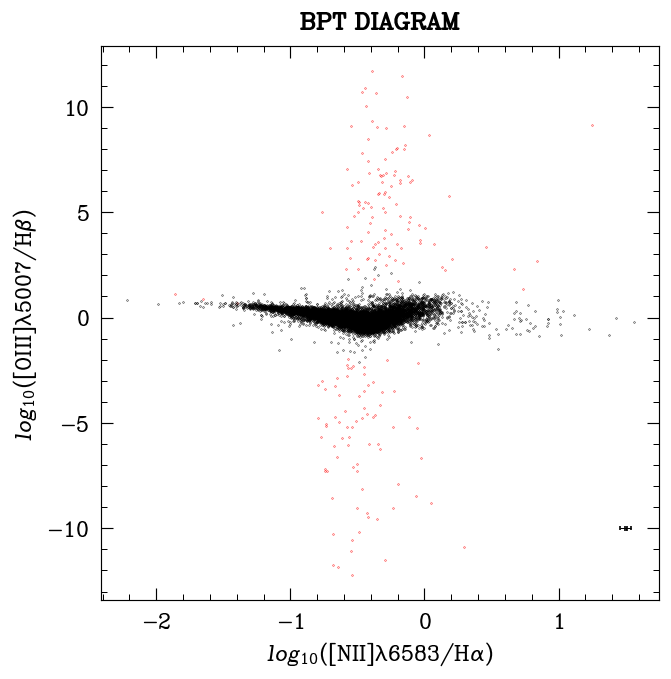

In [43]:
len_x_BPT=len(x_BPT)

for i in tqdm(range(len_x_BPT)):
    if AoN_Ha_ok[i]>1000 or AoN_Hb_ok[i]>1000 or AoN_NII6583_ok[i]>1000 or AoN_OIII5007_ok[i]>1000: #5 para mejor aprox
        plot(x_BPT[i],y_BPT[i],".",markersize=0.5,color="red")
        
    else:
        plot(x_BPT[i],y_BPT[i],".",markersize=0.5,color="black")

xlabel("$log_{10}$([NII]$\lambda$6583/H\u03B1)")
ylabel("$log_{10}$([OIII]$\lambda$5007/H\u03B2)")
title("BPT DIAGRAM",weight="bold")

#xlim(-1.2,0.2)
#ylim(-1,0.75)
errorbar(1.5,-10,xerr=0.041994829846394,yerr=0.0610989829348798,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#GUARDAR PLOT
#savefig("test.pdf",bbox_inches="tight") 
show()

100%|███████████████████████████████████| 13689/13689 [00:08<00:00, 1689.33it/s]


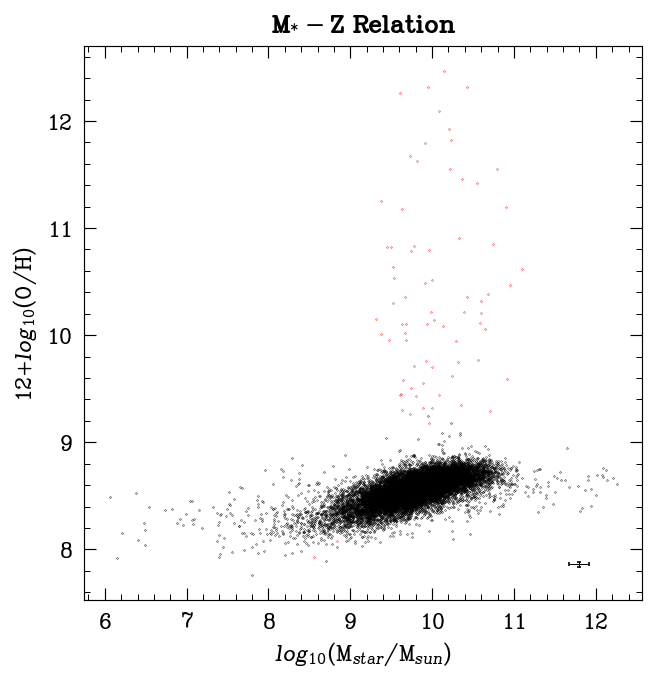

In [44]:
len_logmstar_SF=len(logmstar_SF)

for i in tqdm(range(len_logmstar_SF)):
    if AoN_Ha_SF[i]>1000 or AoN_Hb_SF[i]>1000 or AoN_NII6583_SF[i]>1000 or AoN_OIII5007_SF[i]>1000:
        plot(logmstar_SF[i],PPO4_SF[i],".",markersize=0.5,color="red")
    else:
        plot(logmstar_SF[i],PPO4_SF[i],".",markersize=0.5,color="black")

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

errorbar(11.8,7.86,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error

#GUARDAR PLOT
#savefig("test3.pdf",bbox_inches="tight") 
show()

#### Añadimos una columna al catálogo indicando si es outlier

In [45]:
#outlier=[]

#for i in range(len(Ha)): #condiciones
    #if Ha[i]>0 and Ha[i]!=inf and Hb[i]>0 and Hb[i]!=inf and NII6583[i]>0 and NII6583[i]!=inf and OIII5007[i]>0 and OIII5007[i]!=inf and redshift[i]<0.3 and AoN_Ha[i]>3 and AoN_Hb[i]>2 and AoN_OIII5007[i]>3 and AoN_NII6583[i]>2 and Ha_Error[i]>=0 and Ha_Error[i]!=inf and Hb_Error[i]>=0 and Hb_Error[i]!=inf and OIII5007_Error[i]>=0 and OIII5007_Error[i]!=inf and NII6583_Error[i]>=0 and NII6583_Error[i]!=inf: 
        #if AoN_Ha[i]>1000 or AoN_Hb[i]>1000 or AoN_OIII5007[i]>1000 or AoN_NII6583[i]>1000:
            #outlier.append("Outlier")
        #else:
            #outlier.append("")
    #else:
        #outlier.append("")

In [46]:
#Abrir el archivo FITS
#with fits.open("./Catálogos/GAMA _expansion.fits",mode="update") as hdul:
    # Definir los datos de las nuevas columnas
    #col1_data=array(outlier)  #outliers
    
    #Crear objetos fits.ColDefs para las nuevas columnas (A->flotante con signo; D->caracteres ASCII)
    #col1=fits.ColDefs([fits.Column(name="OUTLIERS",format="20A",array=col1_data)])
    
    #Crear un nuevo objeto fits.BinTableHDU que contenga las nuevas columnas
    #new_hdu=fits.BinTableHDU.from_columns(hdul[1].columns+col1)
    
    #Agregar el nuevo objeto fits.BinTableHDU al archivo FITS
    #hdul[1]=new_hdu
    
    #Guardar los cambios en el archivo FITS
    #hdul.flush()

#### Cantidades de tipos de galaxias

En esta pequeña subsección reunimos el número de galaxias de cada clase:

In [47]:
print("El número de galaxias del catálogo GAMA es de:",len(CATAID))
print("")
print("El número de galaxias del diagrama BPT (o lo que es lo mismo, tras el filtrado) es de:",len(CATAID_ok))
print("")
print("El número de galaxias SF es de:",len(x_SF2)-2)
print("El número de galaxias SF tras la correción por extinción es de:",len(x_SF_corrected)-2)
print("El número de galaxias SF tras la correción por extinción y eliminando masas mal medidas es de:",len(PPO4_SF))
print("")
print("El número de galaxias en filamentos es de:",len(PPO4_SF_fil))
print("El número de tendril galaxies es de:",len(PPO4_SF_tendril))
print("El número de void galaxies es de:",len(PPO4_SF_void))

El número de galaxias del catálogo GAMA es de: 192545

El número de galaxias del diagrama BPT (o lo que es lo mismo, tras el filtrado) es de: 17342

El número de galaxias SF es de: 13670
El número de galaxias SF tras la correción por extinción es de: 13756
El número de galaxias SF tras la correción por extinción y eliminando masas mal medidas es de: 13689

El número de galaxias en filamentos es de: 258
El número de tendril galaxies es de: 1498
El número de void galaxies es de: 192


## 13. Stellar Mass/Absolute Magnitude vs Redshift

#### Stellar Mass vs Redshift

Ploteamos stellar mass versus redshift con le objetivo de comprobar el sesgo por luminosidad/masa. Primero para las 192.545 galaxias del catálogo GAMA:

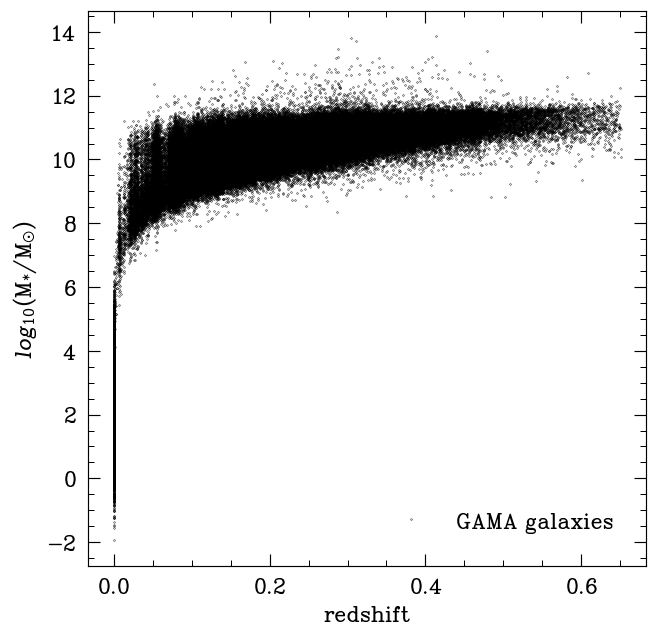

In [48]:
logmstar_OK2=[] #masas de TODAS las galaxias (las 192.545 galaxias menos las de masas mal medidas)
redshift_OK2=[] #redshifts de TODAS las galaxias (las 192.545 galaxias menos las de masas mal medidas)

for l in range(len(redshift)):
    if logmstar[l]!=-99:
        logmstar_OK2.append(logmstar[l])
        redshift_OK2.append(redshift[l])


plot(redshift_OK2,logmstar_OK2,".",color="black",markersize=0.5,label="GAMA galaxies")
xlabel("redshift")
ylabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
legend()
show()

Y luego para las 17.368 galaxias del diagrama BPT

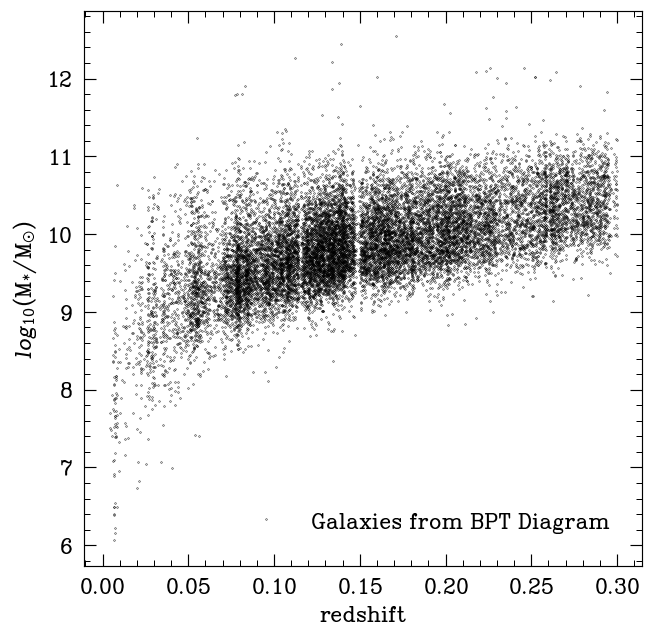

In [49]:
logmstar_OK=[] #masas de galaxias correctas (las 17.368 galaxias menos las de masas mal medidas)
redshift_OK=[] #redshifts de galaxias correctas (las 17.368 galaxias menos las de masas mal medidas)

for l in range(len(redshift_ok)):
    if logmstar_ok[l]!=-99:
        logmstar_OK.append(logmstar_ok[l])
        redshift_OK.append(redshift_ok[l])


plot(redshift_OK,logmstar_OK,".",color="black",markersize=0.5,label="Galaxies from BPT Diagram")
xlabel("redshift")
ylabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
legend()
show()

#### Stellar Mass vs Redshift con colores

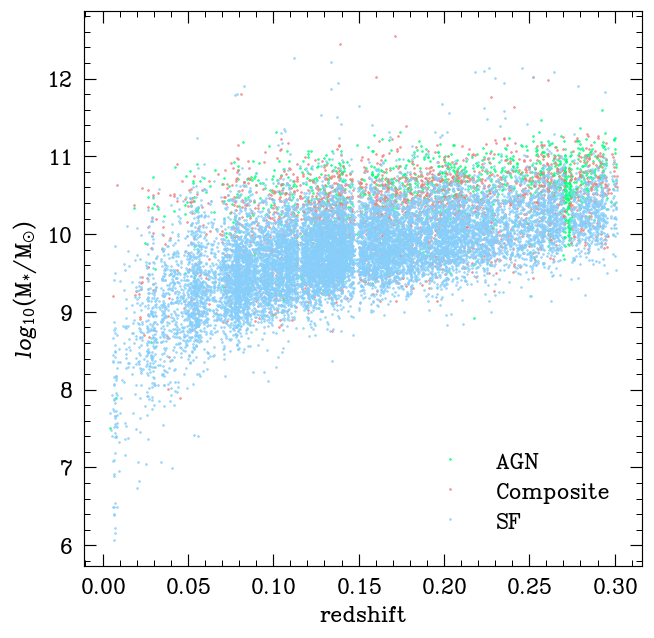

In [50]:
logmstar_SF=[] #masas de galaxias SF correctas (las 17.368 galaxias menos las de masas mal medidas)
redshift_SF=[] #redshifts de galaxias SF correctas (las 17.368 galaxias menos las de masas mal medidas)
logmstar_AGN=[] #...
redshift_AGN=[]
logmstar_Composite=[]
redshift_Composite=[]

for l in range(len(GAMA["GALAXY_TYPE"])):
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="SF":
        logmstar_SF.append(logmstar[l])
        redshift_SF.append(redshift[l])
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="Composite":
        logmstar_Composite.append(logmstar[l])
        redshift_Composite.append(redshift[l])
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="AGN":
        logmstar_AGN.append(logmstar[l])
        redshift_AGN.append(redshift[l])
        
plot(redshift_AGN,logmstar_AGN,".",color="springgreen",markersize=1,label="AGN")
plot(redshift_Composite,logmstar_Composite,".",color="lightcoral",markersize=1,label="Composite")
plot(redshift_SF,logmstar_SF,".",color="lightskyblue",markersize=1,label="SF")
xlabel("redshift")
ylabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
legend()
show()

####  Absolute Magntiude vs Redshift

Ploteamos magnitud absoluta en banda r de petrosian frente al redshift con le objetivo de comprobar el sesgo por luminosidad/masa. Primero para las 192.545 galaxias del catálogo GAMA:

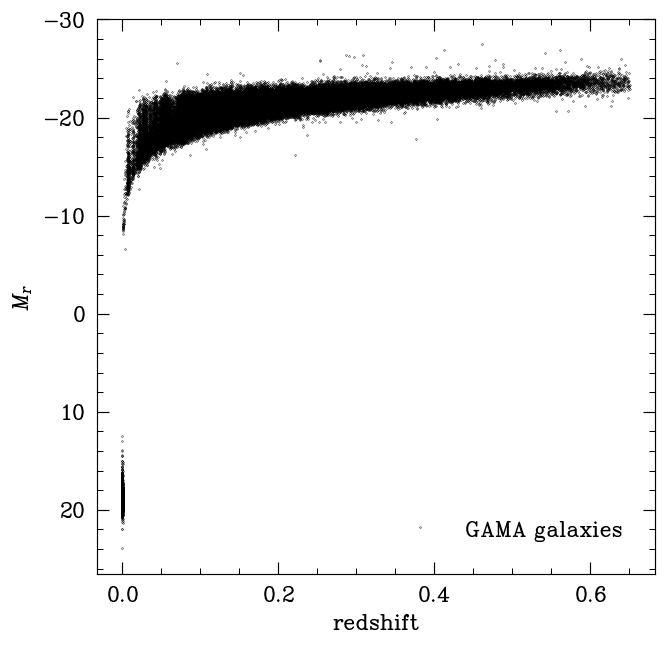

In [51]:
absmag_r_OK2=[] #magnitudes de TODAS las galaxias (las 192.545 galaxias menos las de masas mal medidas)
redshift_OK2=[] #redshifts de TODAS las galaxias (las 192.545 galaxias menos las de masas mal medidas)

for l in range(len(redshift)):
    if M_r[l]!=-99:
        absmag_r_OK2.append(M_r[l])
        redshift_OK2.append(redshift[l])

plot(redshift_OK2,absmag_r_OK2,".",color="black",markersize=0.5,label="GAMA galaxies")
xlabel("redshift")
ylabel("$M_r$")
gca().invert_yaxis()
legend()
show()

Y luego para las 17.368 del diagrama BPT

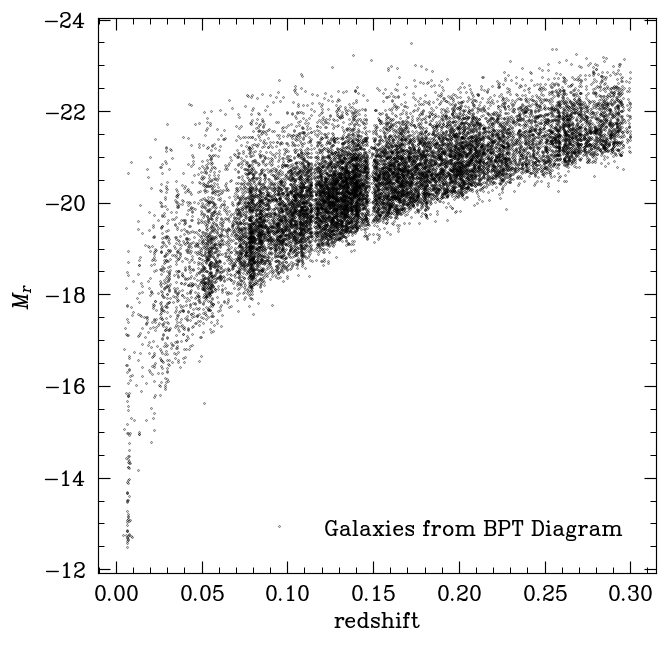

In [52]:
M_r_OK=[] #magnitudes de galaxias correctas (las 17.368 galaxias menos las de masas mal medidas)
redshift_OK=[] #redshifts de galaxias correctas (las 17.368 galaxias menos las de masas mal medidas)

for l in range(len(redshift_ok)):
    if M_r_ok[l]!=-99:
        M_r_OK.append(M_r_ok[l])
        redshift_OK.append(redshift_ok[l])      

plot(redshift_OK,M_r_OK,".",color="black",markersize=0.5,label="Galaxies from BPT Diagram")
xlabel("redshift")
ylabel("$M_r$")
gca().invert_yaxis()
legend()
show()

#### Absolute Magnitude vs Redshift con colores

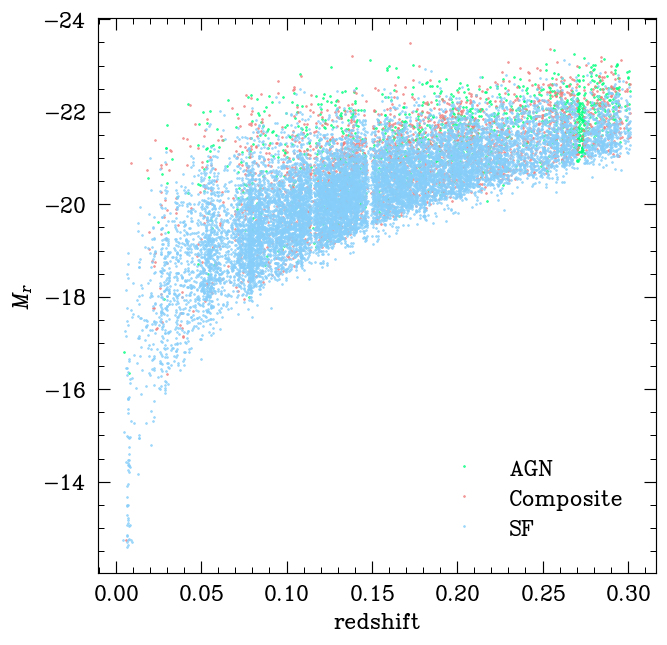

In [53]:
M_r_SF=[] #masas de galaxias SF correctas (las 17.368 galaxias menos las de masas mal medidas)
redshift_SF=[] #redshifts de galaxias SF correctas (las 17.368 galaxias menos las de masas mal medidas)
M_r_AGN=[] #...
redshift_AGN=[]
M_r_Composite=[]
redshift_Composite=[]

for l in range(len(GAMA["GALAXY_TYPE"])):
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="SF":
        M_r_SF.append(M_r[l])
        redshift_SF.append(redshift[l])
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="Composite":
        M_r_Composite.append(M_r[l])
        redshift_Composite.append(redshift[l])
    if logmstar[l]!=-99 and GAMA["GALAXY_TYPE"][l]=="AGN":
        M_r_AGN.append(M_r[l])
        redshift_AGN.append(redshift[l])
        
plot(redshift_AGN,M_r_AGN,".",color="springgreen",markersize=1,label="AGN")
plot(redshift_Composite,M_r_Composite,".",color="lightcoral",markersize=1,label="Composite")
plot(redshift_SF,M_r_SF,".",color="lightskyblue",markersize=1,label="SF")
xlabel("redshift")
gca().invert_yaxis()
ylabel("$M_r$")
legend()
show()

#### Clasificación de redshift y logmstar según el tipo de galaxia: SF, AGN or Composite

Clasificamos el redhsift, logmstar y M_r según SF, AGN o Composites para trabajar posteriormente con ellos: 

In [54]:
redshift_SF=[] #añadimos redshift de SF
redshift_Composite=[] #...
redshift_AGN=[]

logmstar_SF=[] #añadimos logmstar de SF
logmstar_Composite=[] #...
logmstar_AGN=[]

M_r_SF=[] #añadimos M_r de SF
M_r_Composite=[] #...
M_r_AGN=[]

for i in range(len(GAMA["GALAXY_TYPE"])):
    if GAMA["GALAXY_TYPE"][i]=="SF" and GAMA["logmstar"][i]!=-99:
        redshift_SF.append(redshift[i])
        logmstar_SF.append(logmstar[i])
        M_r_SF.append(M_r[i])
    if GAMA["GALAXY_TYPE"][i]=="Composite" and GAMA["logmstar"][i]!=-99:
        redshift_Composite.append(redshift[i])
        logmstar_Composite.append(logmstar[i])
        M_r_Composite.append(M_r[i])
    if GAMA["GALAXY_TYPE"][i]=="AGN" and GAMA["logmstar"][i]!=-99:
        redshift_AGN.append(redshift[i])
        logmstar_AGN.append(logmstar[i])
        M_r_AGN.append(M_r[i])
        
print("La media en redshift de las AGN es de:", mean(redshift_AGN))
print("La media en redshift de las Composite es de:", mean(redshift_Composite))
print("La media en redshift de las SF es de:", mean(redshift_SF))
print("")
print("La media en logmstar de las AGN es de:", mean(logmstar_AGN))
print("La media en logmstar de las Composite es de:", mean(logmstar_Composite))
print("La media en logmstar de las SF es de:", mean(logmstar_SF))
print("")
print("La media en M_r de las AGN es de:", mean(M_r_AGN))
print("La media en M_r de las Composite es de:", mean(M_r_Composite))
print("La media en M_r de las SF es de:", mean(M_r_SF))

La media en redshift de las AGN es de: 0.19609374
La media en redshift de las Composite es de: 0.17380527
La media en redshift de las SF es de: 0.14614195

La media en logmstar de las AGN es de: 10.518878
La media en logmstar de las Composite es de: 10.229049
La media en logmstar de las SF es de: 9.759522

La media en M_r de las AGN es de: -21.454624
La media en M_r de las Composite es de: -20.945621
La media en M_r de las SF es de: -20.23006


## 14. SFR Relation

Calculamos la tasa de formación estelar (SFR) a partir de la expresión propuesta por Hopkins,

$$
\mathrm{SFR}_{\mathrm{Hopkins}}=\frac{L_{\mathrm{H} \alpha}}{1.27 \times 10^{34}}
$$

donde 

$$
\begin{aligned}
L_{\mathrm{H} \alpha}= & \left(\mathrm{EW}_{\mathrm{H} \alpha}+\mathrm{EW}_c\right) \times 10^{-0.4\left(M_r-34.10\right)} \times \frac{3 \times 10^{18}}{[6564.61(1+z)]^2} \\
& \times\left(\frac{F(\mathrm{H} \alpha)_{\mathrm{obs}} / F(\mathrm{H} \beta)_{\mathrm{obs}}}{2.86}\right)^{2.36}
\end{aligned}
$$

Nótese que $M_r$ es la magnitud absoluta en la banda r (o R) de Petrosian. Esta magnitud no se encontraba en nuestro catálogo corregida y la hemos tenido que corregir desde TOPCAT haciendo M_r = PETROMAG_R-A_R-KCORR_R-D_70_30_70.

Seleccionamos primero las variables de las galaxias SF,

In [55]:
#SELECCIONAMOS LAS VARIABLES DE LAS GALAXIAS SF Y CON MAS BIEN MEDIDA
EW_Ha_SF=[]
EW_Ha_SF_Error=[]
M_r_SF=[]
Ha_obs_SF=[]
Ha_obs_SF_Error=[]
Hb_obs_SF_Error=[]
Hb_obs_SF=[]
z_SF=[]
logmstar_SF=[]

for i in range(len(GAMA["GALAXY_TYPE"])):
    if GAMA["GALAXY_TYPE"][i]=="SF" and GAMA["logmstar"][i]!=-99:
        EW_Ha_SF.append(GAMA["EW_24"][i])
        EW_Ha_SF_Error.append(GAMA["EW_ERROR_24"][i])
        M_r_SF.append(GAMA["M_r"][i])
        Ha_obs_SF.append(GAMA["FLUX_OBS_Ha"][i])
        Ha_obs_SF_Error.append(GAMA["FLUX_ERROR_24"][i])
        Hb_obs_SF.append(GAMA["FLUX_OBS_Hb"][i])
        Hb_obs_SF_Error.append(GAMA["FLUX_ERROR_15"][i])
        z_SF.append(GAMA["Z_TONRY"][i])
        logmstar_SF.append(GAMA["logmstar"][i])


para luego plotear la relación masa-SFR.

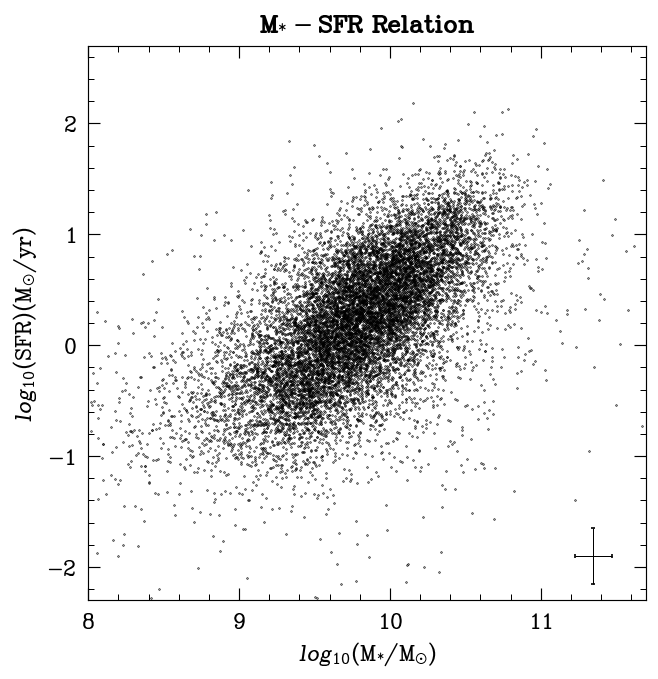

In [56]:
Lhalpha_SF=[]
SFR_SF=[]
EW_c=0 #EW_c=0.7 antes

for i in range(len(z_SF)):

    Lhalpha_SF.append((EW_Ha_SF[i]+EW_c)*10**(-0.4*(M_r_SF[i]-34.10))*(3*10**18)/(6564.61*(1+z_SF[i]))**2*((Ha_obs_SF[i]/Hb_obs_SF[i])/2.86)**2.36)
    SFR_SF.append(Lhalpha_SF[i]/(1.27*10**34))
    
plot(logmstar_SF,log10(SFR_SF),".",color="black",markersize=0.7)

xlim(8,11.7)
ylim(-2.3,2.7)

errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
title("M$_{*}-$SFR Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_SF) == False)[0] #filtramos los datos para eliminar SFR = inf
SFR_SF_isfinite = delete(SFR_SF, inf_indices)
logmstar_SF_isfinite = delete(logmstar_SF, inf_indices)

p_SFRfil_all = polyfit(logmstar_SF_isfinite, log10(SFR_SF_isfinite), 1) 
y_SFRfit_all = polyval(p_SFRfil_all,logmstar_SF_isfinite)

# Pesos w
w_SFRfil_all=[]
resid_SFRfil_all=[]
for m in range(len(y_SFRfit_all)):
    resid_SFRfil_all.append((log10(SFR_SF_isfinite))[m]-y_SFRfit_all[m])
    w_SFRfil_all.append(1/resid_SFRfil_all[m]**2)

#Ajuste por polinomios con w
p_w_SFRfil_all = polyfit(logmstar_SF_isfinite, log10(SFR_SF_isfinite),1, w = w_SFRfil_all) 
y_fit_w_SFRfil_all = polyval(p_w_SFRfil_all,logmstar_SF_isfinite) 

#plot(sorted(logmstar_SF_isfinite),sorted(y_fit_w_SFRfil_all),"--",color="red",label="1st order fit (GAMA)",linewidth = 0.9)

#GUARDAR PLOT
savefig(os.path.join("./Images","SFR_Relation.pdf"),bbox_inches="tight") 
show()

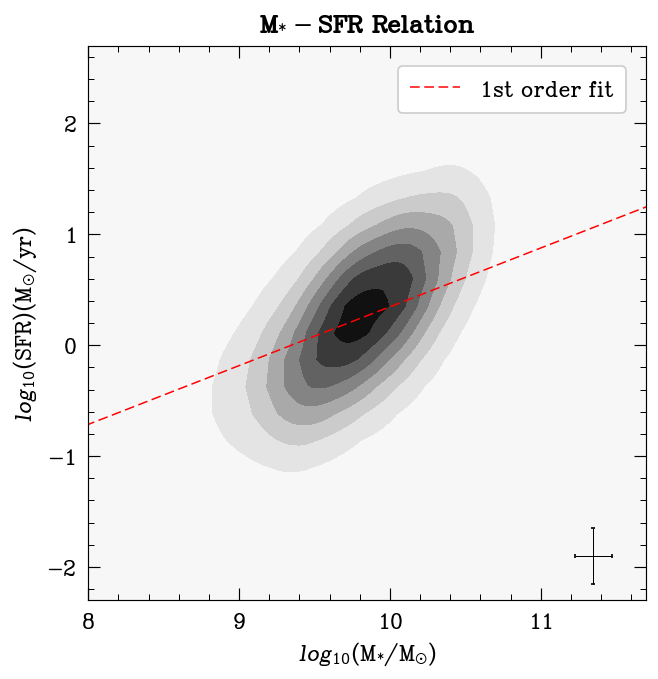

In [57]:
#DENSITY SCATTER PLOT
#Crea un objeto de densidad de kernel
inf_indices = where(isfinite(SFR_SF) == False)[0] #filtramos los datos para eliminar log10(SFR) = inf
SFR_isfinite = delete(SFR_SF, inf_indices)
logmstar_SF_isfinite = delete(logmstar_SF, inf_indices)

kdeSF=gaussian_kde([ravel(logmstar_SF_isfinite),ravel(log10(SFR_isfinite))])

#Crea una cuadrícula de valores para el gráfico de contorno
xminSFR,yminSFR=min(logmstar_SF_isfinite),min(log10(SFR_isfinite))
xmaxSFR,ymaxSFR=max(logmstar_SF_isfinite),max(log10(SFR_isfinite))
xiSFR,yiSFR=mgrid[xminSFR:xmaxSFR:200j,yminSFR:ymaxSFR:200j]
ziSFR=kdeSF(vstack([xiSFR.flatten(),yiSFR.flatten()]))

#Crea el gráfico de densidad de puntos difuminados
contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys")

xlim(8,11.7)
ylim(-2.3,2.7)

plot(sorted(logmstar_SF_isfinite),sorted(y_fit_w_SFRfil_all),"--",color="red",label="1st order fit",linewidth = 0.9)

errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
title("M$_{*}-$SFR Relation",weight="bold")

legend(frameon=True)
show()

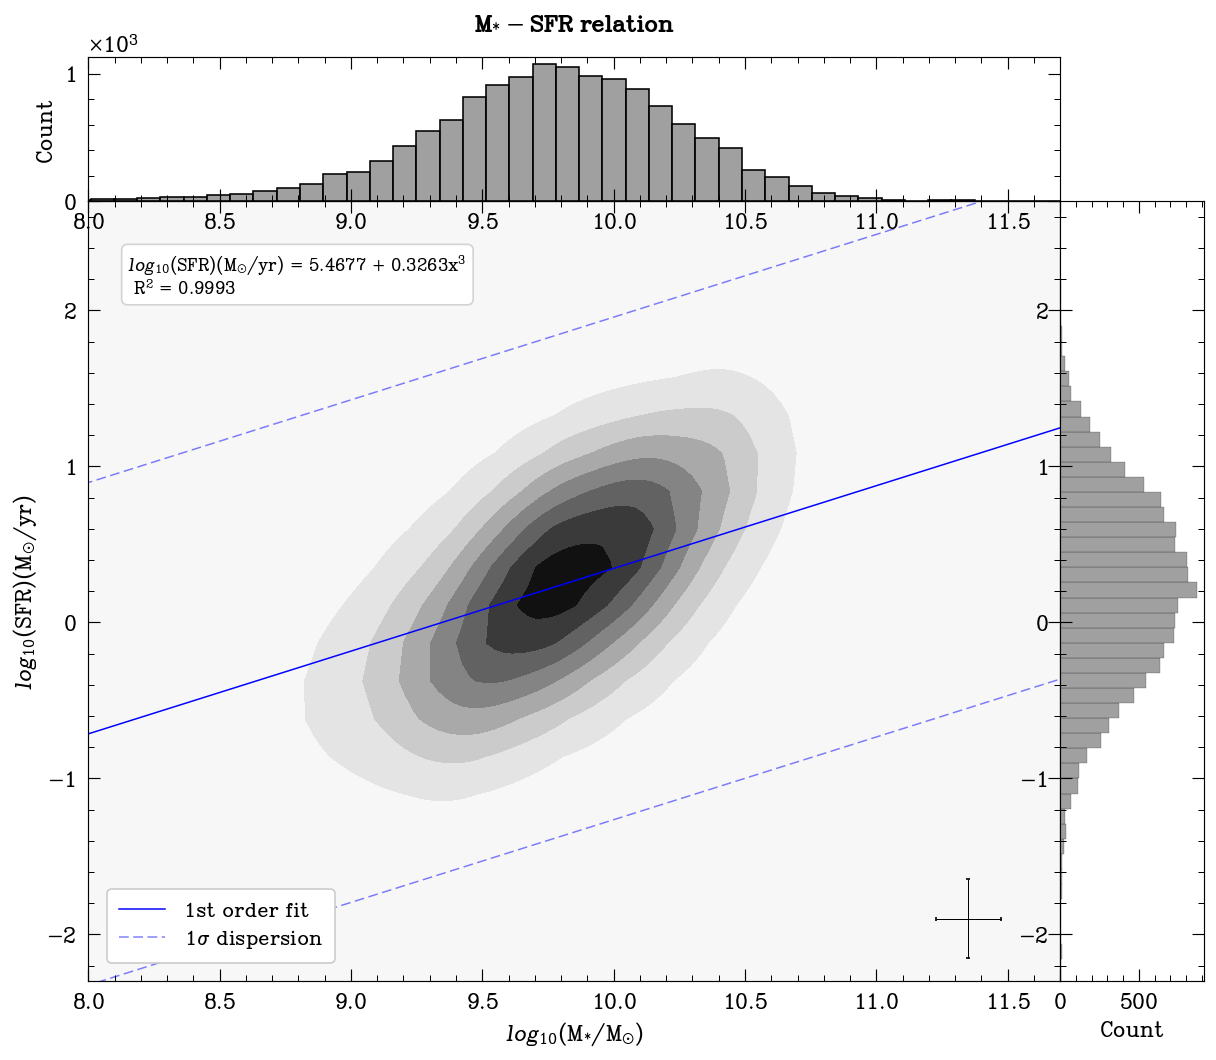

In [58]:
#Crear el subplot principal y los subplots marginales usando make_axes_locatable
fig, ax=subplots(figsize=(12,10))
divider=make_axes_locatable(ax)
ax_histx=divider.append_axes("top",size=1.2,pad=0,sharex=ax)
ax_histy=divider.append_axes("right",size=1.2,pad=0,sharey=ax)

ax.contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys")

#Ajuste polinomial con pesos (w)
ax.plot(sorted(logmstar_SF_isfinite),sorted(y_fit_w_SFRfil_all),"-",color="blue",label="1st order fit",linewidth = 0.9)

#Dispersion del ajuste
dispersion=std(resid_SFRfil_all)
y_upper=y_fit_w_SFRfil_all+dispersion
y_lower=y_fit_w_SFRfil_all-dispersion

ax.plot(sorted(ravel(logmstar_SF_isfinite)),sorted(y_upper),"--",color="blue",linewidth=0.9,alpha=0.5) 
ax.plot(sorted(ravel(logmstar_SF_isfinite)),sorted(y_lower),"--",color="blue",label="1$\sigma$ dispersion",linewidth=0.9,alpha=0.5) 

#Crea los histogramas marginales
histplot(x=ravel(logmstar_SF),ax=ax_histx,bins=70,color="gray")
histplot(y=ravel(log10(SFR_SF)),ax=ax_histy,bins=500,orientation="horizontal",color="gray")

#Ajusta los límites de los subplots principales
ax.set_xlim(8,11.7)
ax.set_ylim(-2.3,2.7)

#Ajusta las etiquetas de los subplots principales
ax.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=15)
ax.set_ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)",fontsize=15)
ax.set_title("M$_{*}-$SFR relation",weight="bold",y=1.2,fontsize=17)

ax.errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error

ax.text(8.15,2.1,"$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr) = 5.4677 + 0.3263x$^3$ \n R$^2$ = 0.9993",fontsize=12, bbox = dict(boxstyle="round,pad=0.3",fc="white",ec="lightgray",lw=1))

ax.legend(loc="lower left",fontsize=14,frameon=True)
#GUARDAR PLOT
savefig("Images/SFR_Relation_MH.png",bbox_inches="tight") 
show()

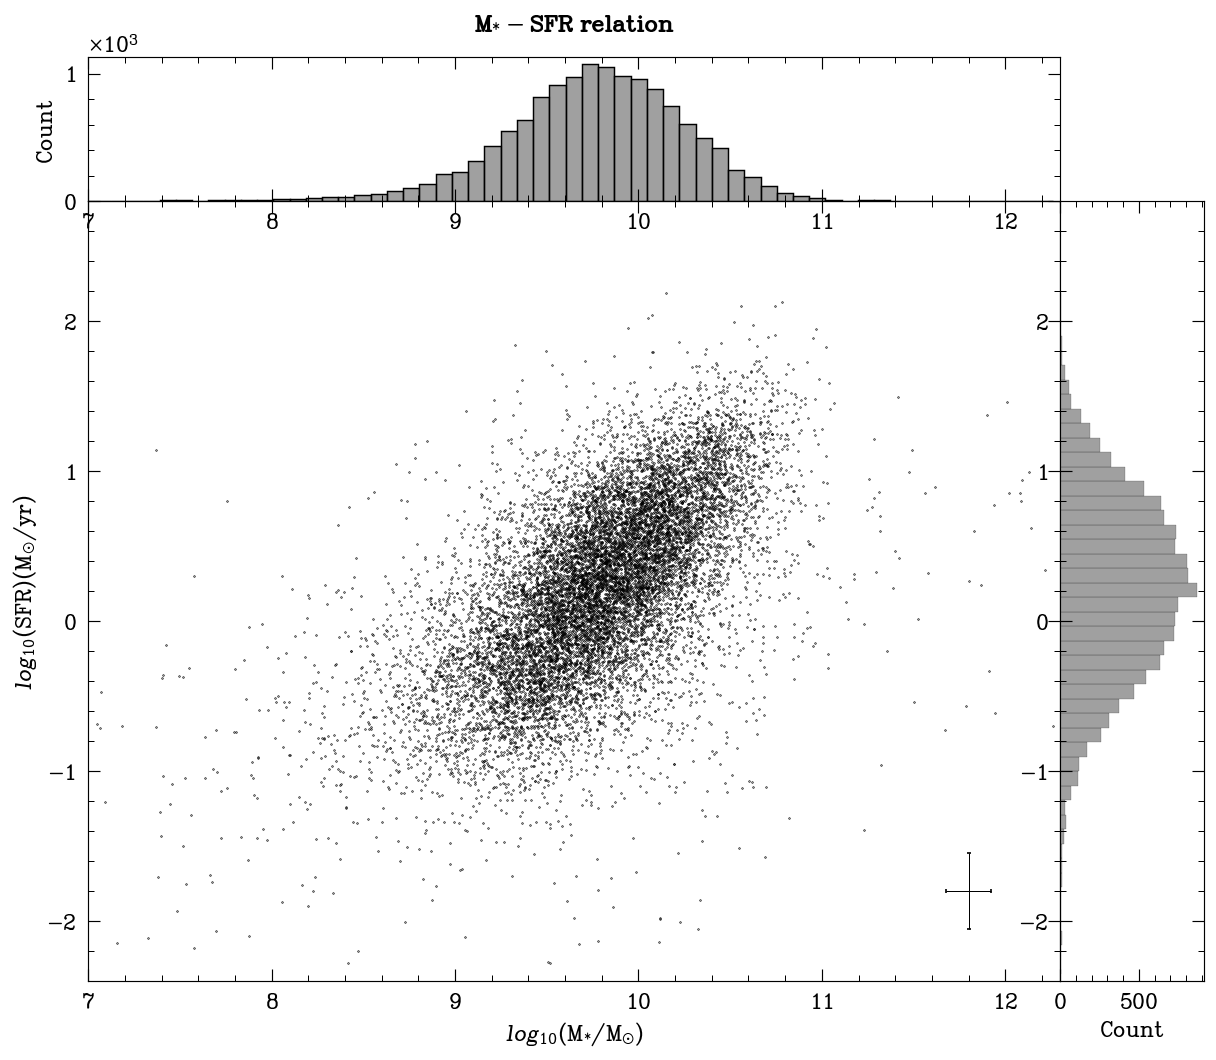

In [59]:
#Crear el subplot principal y los subplots marginales usando make_axes_locatable
fig, ax=subplots(figsize=(12,10))
divider=make_axes_locatable(ax)
ax_histx=divider.append_axes("top",size=1.2,pad=0,sharex=ax)
ax_histy=divider.append_axes("right",size=1.2,pad=0,sharey=ax)

ax.plot(logmstar_SF,log10(SFR_SF),".",color="black",markersize=0.7)

#Ajuste polinomial con pesos (w)
#ax.plot(sorted(logmstar_SF_isfinite),sorted(y_fit_w_SFRfil_all),"-",color="blue",label="1st order fit",linewidth = 0.9)

#Dispersion del ajuste
dispersion=std(resid_SFRfil_all)
y_upper=y_fit_w_SFRfil_all+dispersion
y_lower=y_fit_w_SFRfil_all-dispersion

#ax.plot(sorted(ravel(logmstar_SF_isfinite)),sorted(y_upper),"--",color="blue",linewidth=0.9,alpha=0.5) 
#ax.plot(sorted(ravel(logmstar_SF_isfinite)),sorted(y_lower),"--",color="blue",label="1$\sigma$ dispersion",linewidth=0.9,alpha=0.5) 

#Crea los histogramas marginales
histplot(x=ravel(logmstar_SF),ax=ax_histx,bins=70,color="gray")
histplot(y=ravel(log10(SFR_SF)),ax=ax_histy,bins=500,orientation="horizontal",color="gray")

#Ajusta los límites de los subplots principales
ax.set_xlim(7,12.3)
ax.set_ylim(-2.4,2.8)

#Ajusta las etiquetas de los subplots principales
ax.set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)",fontsize=15)
ax.set_ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)",fontsize=15)
ax.set_title("M$_{*}-$SFR relation",weight="bold",y=1.2,fontsize=17)

ax.errorbar(11.8,-1.8,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error

#ax.text(8.15,2.1,"$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr) = 5.4677 + 0.3263x$^3$ \n R$^2$ = 0.9993",fontsize=12, bbox = dict(boxstyle="round,pad=0.3",fc="white",ec="lightgray",lw=1))

#ax.legend(loc="lower left",fontsize=14,frameon=True)
#GUARDAR PLOT
savefig("Images/SFR_marginal_histogram.png",bbox_inches="tight") 
show()

## 15. Field Galaxies (control samples)

Una vez realizado todo este proceso, es momento de trabajar con las field galaxies (galaxias de campo). Estas galaxias son aquellas que se encuentran en regiones asiladas (poco densas) y por tanto no interaccionan con otras, es decir, su evolución no está influenciada por otras galaxias. Para filtrar estas galaxias hemos quitado del catálogo GAMA las galaxias en filamentos y los tendrils, quedando así las galaxias de campo. 

El objetivo es obtener una muestra control de galaxias aisladas (field galaxies) para poder compararla posteriormente con la muestra de galaxias en filamentos, de tendrils y de voids por separado. Para ello, trataremos de buscar clones, es decir, field galaxias con características similares a las galaxias del catálogo de filamentos, después del de tendrils y finalmente del de voids. Estás características se basarán en encontrar field galaxias con redshift y logmstar similares a las galaxias en filamentos, de tendrils y de voids por separado.


In [60]:
#Adjuntamos Datos de FIELD galaxies
FITS=fits.open("./Catalogos/GAMA_FieldGals.fits") #lee .fits
field=FITS[1].data #datos FieldGals

#Seleccionamos aquellas SF Galaxias de las FIELD GALAXIES
logmstar_field_SF=[]
redshift_field_SF=[]
colorur_field_SF=[]
CATAID_field_SF=[]
SFR_field_SF = []
Z_field_SF = []

colorur_field=field["M_model_u"]-field["M_model_r"]

for i in range(len(field["GALAXY_TYPE"])):
    if field["GALAXY_TYPE"][i]=="SF" and field["logmstar"][i]!=-99:
        logmstar_field_SF.append(field["logmstar"][i])
        redshift_field_SF.append(field["Z_TONRY"][i])
        colorur_field_SF.append(colorur_field[i])
        CATAID_field_SF.append(field["CATAID_2"][i])
        SFR_field_SF.append(field["SFR"][i])
        Z_field_SF.append(field["METALLICITY"][i])


#### Control sample for galaxies in filaments

##### Clone search: filamentes galaxies - field galaxies

Vamos a buscar clones. El objetivo es buscar por cada galaxia en filamentos, alrededor de 5 galaxias de campo clones. Con clones nos referimos a galaxias de campo que tengan redshift y logmstar similares al de las galaxias en filamentos. Para ello, imponemos que la diferencia en redshift y logmstar entre la galaxia de filamento y field galaxies sea menor que una cierta cantidad, además de las siguientes condiciones:

1. No repetir clones (dos galaxias en filamentos pueden encontrar el mismo clon, sólo la primera que lo encuentre se le asociará a él).
2. Corte en redshift (para evitar que la diferencia entre el máximo en redshift de las field galaxias y galaxies in filaments sea muy diferente).
3. Imponer un máximo de 10 clones encontrados por galaxia en filamento.

Nota: con (SF) nos referimos a que, logicamente, seguimos trabajando con la muestra de galaxias SF únicamente.

Primero, filtramos las field galaxies y las galaxies in filaments.

In [61]:
#Seleccionamos aquellas SF Galaxias de las GALAXIES IN FILAMENTS
logmstar_fil_SF=[]
redshift_fil_SF=[]
colorur_fil_SF=[]
CATAID_fil_SF=[]
SFR_fil_SF = []
Z_fil_SF = []

colorur_fil=fil["M_model_u"]-fil["M_model_r"]

for i in range(len(fil["GALAXY_TYPE"])):
    if fil["GALAXY_TYPE"][i]=="SF" and fil["logmstar"][i]!=-99:
        logmstar_fil_SF.append(fil["logmstar"][i])
        redshift_fil_SF.append(fil["Z_TONRY"][i])
        colorur_fil_SF.append(colorur_fil[i])
        CATAID_fil_SF.append(fil["CATAID_2"][i])
        SFR_fil_SF.append(fil["SFR"][i])
        Z_fil_SF.append(fil["METALLICITY"][i])


A continuación, se presenta el bucle principal donde se buscan los clones dadas las condiciones en redshift y logmstar, además de las tres condiciones enumeradas.

**Nota:** Las celdas correspondientes a la búsqueda de clones han sido pasadas a _raw_ para evitar tener que correrlas cada vez que se ejecute cuaderno. En su lugar, llamaremos a los clones encontrados directamente de los archivos .fits (ya que guardamos ahí los resultados). Por otro lado, de de admitir que añadimos nuevas columnas de datos a los .fits y si corriésemos esta celda _raw_ no obtendriamos lo que se deberia obtener. No sabemos por qué.

In [62]:
# Llamamos a los clones encontrados
logmstar_field_SF_filclone = []
redshift_field_SF_filclone = []
colorur_field_SF_filclone = []
Z_field_SF_filclone = []
SFR_field_SF_filclone = []

for i in range(len(field["CATAID_2"])):
    if field["control_sample_fil"][i]=="Yes":
        logmstar_field_SF_filclone.append(field["logmstar"][i])
        redshift_field_SF_filclone.append(field["Z_TONRY"][i])
        colorur_field_SF_filclone.append(field["M_model_u"][i]-field["M_model_r"][i])
        Z_field_SF_filclone.append(field["METALLICITY"][i])
        SFR_field_SF_filclone.append(field["SFR"][i])
        
# Llamamos a los filamentos
logmstar_fil_SF_clone = logmstar_fil_SF
redshift_fil_SF_clone = redshift_fil_SF
colorur_fil_SF_clone = colorur_fil_SF 

##### Histogram and Empirical Cumulative Distribution Function

Para finalizar la búsqueda de field galaxias (clones) con características similares a las galaxias en filamentos, realizamos 3 histogramas (en logmstar, redshift y color) para ver sus similitudes y comprobar si las condiciones de búsqueda en diferencia en masa y redshift son suficientes.

Por otro lado, vamos a ver como se comportan estas distribuciones desde otra perspectiva. Para ello, empleamos la ECDF (empirical Cumulative Distribution Function). Nótese que con control sample hacemos referencia a las galaxias (clones) de campo. 

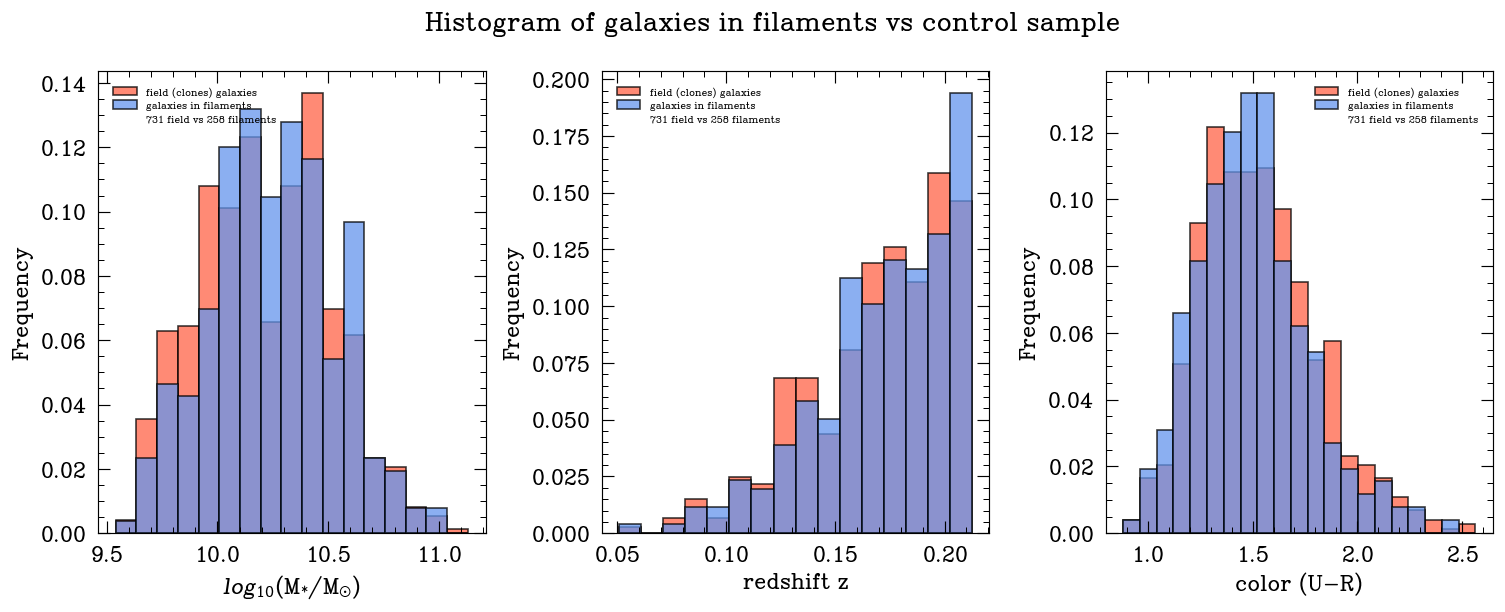

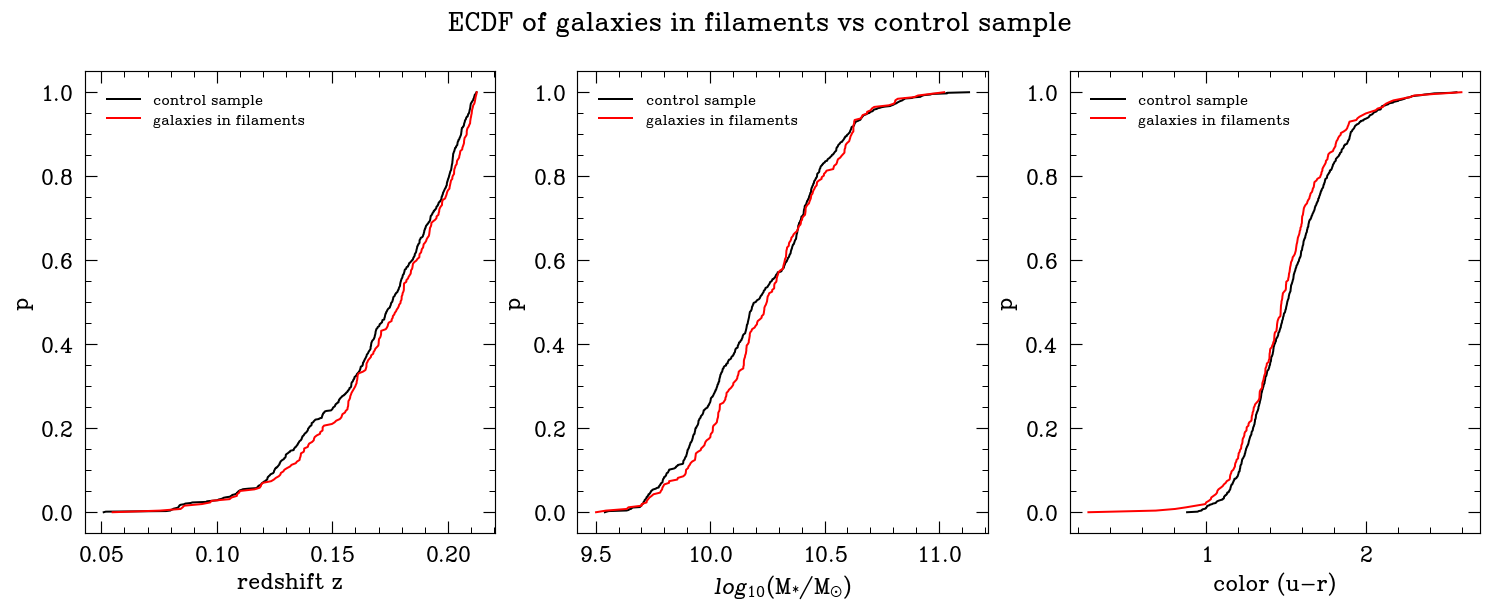

In [63]:
#Ploteamos histogramas para comaprar los clones encontrados de field galaxias para las fil galaxies
fig,axs=subplots(1,3,figsize=(15,5))

#logmstar
axs[0].hist(logmstar_field_SF_filclone,bins = histogram_bin_edges(logmstar_field_SF_filclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_field_SF_filclone))/len(logmstar_field_SF_filclone),label="field (clones) galaxies")
axs[0].hist(logmstar_fil_SF_clone,bins = histogram_bin_edges(logmstar_field_SF_filclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_fil_SF_clone))/len(logmstar_fil_SF_clone),label="galaxies in filaments")

axs[0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[0].set_ylabel("Frequency")
axs[0].plot([], [], " ", label=f"{len(logmstar_field_SF_filclone)} field vs {len(logmstar_fil_SF_clone)} filaments")
axs[0].legend(fontsize=7,loc="upper left")

#redshift
axs[1].hist(redshift_field_SF_filclone,bins = histogram_bin_edges(redshift_field_SF_filclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(redshift_field_SF_filclone))/len(redshift_field_SF_filclone),label="field (clones) galaxies")
axs[1].hist(redshift_fil_SF_clone,bins = histogram_bin_edges(redshift_field_SF_filclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(redshift_fil_SF_clone))/len(redshift_fil_SF_clone),label="galaxies in filaments")

axs[1].set_xlabel("redshift z")
axs[1].set_ylabel("Frequency")
axs[1].plot([], [], " ", label=f"{len(redshift_field_SF_filclone)} field vs {len(redshift_fil_SF_clone)} filaments")
axs[1].legend(fontsize=7,loc="upper left")

#colour
axs[2].hist(colorur_field_SF_filclone,bins = histogram_bin_edges(colorur_field_SF_filclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(colorur_field_SF_filclone))/len(colorur_field_SF_filclone),label="field (clones) galaxies")
axs[2].hist(colorur_fil_SF_clone,bins = histogram_bin_edges(colorur_field_SF_filclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(colorur_fil_SF_clone))/len(colorur_fil_SF_clone),label="galaxies in filaments")

axs[2].set_xlabel("color (U-R)")
axs[2].set_ylabel("Frequency")
axs[2].plot([], [], " ", label=f"{len(colorur_field_SF_filclone)} field vs {len(colorur_fil_SF_clone)} filaments")
axs[2].legend(fontsize=7,loc="upper right")

subplots_adjust(wspace=0.3)
suptitle("Histogram of galaxies in filaments vs control sample")
show()

#Ploteamos los ECDF para redshift, masa y color (alternativa a los histogramas para ver el comprotamiento de la dsitribución)
fig,axs=subplots(1,3,figsize=(15,5))

#redshift
sort_redshift_field_SF_filclone = sort(redshift_field_SF_filclone)
p_redshift_field_SF_filclone = 1. * arange(len(redshift_field_SF_filclone)) / (len(redshift_field_SF_filclone) - 1)

sort_redshift_fil_SF_clone = sort(redshift_fil_SF_clone)
p_redshift_fil_SF_clone = 1. * arange(len(redshift_fil_SF_clone)) / (len(redshift_fil_SF_clone) - 1)

#logmstar
sort_logmstar_field_SF_filclone = sort(logmstar_field_SF_filclone)
p_logmstar_field_SF_filclone = 1. * arange(len(logmstar_field_SF_filclone)) / (len(logmstar_field_SF_filclone) - 1)

sort_logmstar_fil_SF_clone = sort(logmstar_fil_SF_clone)
p_logmstar_fil_SF_clone = 1. * arange(len(logmstar_fil_SF_clone)) / (len(logmstar_fil_SF_clone) - 1)

#colorur
sort_colorur_field_SF_filclone = sort(colorur_field_SF_filclone)
p_colorur_field_SF_filclone = 1. * arange(len(colorur_field_SF_filclone)) / (len(colorur_field_SF_filclone) - 1)

sort_colorur_fil_SF_clone = sort(colorur_fil_SF_clone)
p_colorur_fil_SF_clone = 1. * arange(len(colorur_fil_SF_clone)) / (len(colorur_fil_SF_clone) - 1)

axs[0].plot(sort_redshift_field_SF_filclone,p_redshift_field_SF_filclone,color="black",label="control sample")
axs[0].plot(sort_redshift_fil_SF_clone,p_redshift_fil_SF_clone,color="red",label="galaxies in filaments")
axs[0].set_xlabel("redshift z")
axs[0].set_ylabel("p")
axs[0].legend(loc = "upper left", fontsize=10)

axs[1].plot(sort_logmstar_field_SF_filclone,p_logmstar_field_SF_filclone,color="black",label="control sample")
axs[1].plot(sort_logmstar_fil_SF_clone,p_logmstar_fil_SF_clone,color="red",label="galaxies in filaments")
axs[1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[1].set_ylabel("p")
axs[1].legend(loc = "upper left", fontsize=10)

axs[2].plot(sort_colorur_field_SF_filclone,p_colorur_field_SF_filclone,color="black",label="control sample")
axs[2].plot(sort_colorur_fil_SF_clone,p_colorur_fil_SF_clone,color="red",label="galaxies in filaments")
axs[2].set_xlabel("color (u-r)")
axs[2].set_ylabel("p")
axs[2].legend(loc = "upper left", fontsize=10)

suptitle("ECDF of galaxies in filaments vs control sample")
savefig(os.path.join("./Images","ECDF_filaments.pdf"),bbox_inches="tight") 
show()

##### Test de Kolmogorov-Smirnov y Test de Anderson-Darling

Por último, debemos comprobar si ambas muestras son compatibles. Para ello, utilizaremos el $\textit{test de Kolmogorov-Smirnov}$. Este test nos dice, dadas dos muestras de datos, si ambas muestras se pueden suponer extraidas de la misma población. Si obtenemos p-values mayores que $\alpha$ = 0.05, podremos concluir con que las dos muestras provienen de la misma población. 

Por otro lado, realizamos el $\textit{test de Anderson-Darling}$, mas sensibles en las colas de la ECDF, para validar mas profundamente nuestra muestra control.

In [64]:
alpha = 0.05 # Nivel de significancia

# Test de Kolmogorov-Smirnov redshift
print("Test de Kolmogorov-Smirnov:")

p_valor_redshift_ks = ks_2samp(redshift_fil_SF_clone, redshift_field_SF_filclone).pvalue

if p_valor_redshift_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")

# Test de Kolmogorov-Smirnov logmstar
p_valor_logmstar_ks = ks_2samp(logmstar_fil_SF_clone, logmstar_field_SF_filclone).pvalue

if p_valor_logmstar_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")

# Test de Kolmogorov-Smirnov colorur
p_valor_colorur_ks = ks_2samp(colorur_fil_SF_clone, colorur_field_SF_filclone).pvalue

if p_valor_colorur_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")

print()
print("Test de Anderson-Darling:")

# Test de Anderson-Darling redshift
p_valor_redshift_ad = anderson_ksamp([redshift_fil_SF_clone, redshift_field_SF_filclone]).pvalue

if p_valor_redshift_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")

# Test de Anderson-Darling logmstar
p_valor_logmstar_ad = anderson_ksamp([logmstar_fil_SF_clone, logmstar_field_SF_filclone]).pvalue

if p_valor_logmstar_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")

# Test de Anderson-Darling colorur
p_valor_colorur_ad = anderson_ksamp([colorur_fil_SF_clone, colorur_field_SF_filclone]).pvalue

if p_valor_colorur_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")

Test de Kolmogorov-Smirnov:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.5805341014009272)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.11047681138037685)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.17340121004722162)

Test de Anderson-Darling:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.2071682539430559)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.09265563091024012)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.08660209594443352)


### Control sample for tendril galaxies

Realizamos el mismo proceso pero para tendril galaxies

##### Clone search: tendril galaxies - field galaxies

In [65]:
#Seleccionamos aquellas SF Galaxias de las TENDRIL GALAXIES
logmstar_tendril_SF=[]
redshift_tendril_SF=[]
colorur_tendril_SF=[]
CATAID_tendril_SF=[]
SFR_tendril_SF = []
Z_tendril_SF = []

colorur_tendril=tendril["M_model_u"]-tendril["M_model_r"]

for i in range(len(tendril["GALAXY_TYPE"])):
    if tendril["GALAXY_TYPE"][i]=="SF" and tendril["logmstar"][i]!=-99:
        logmstar_tendril_SF.append(tendril["logmstar"][i])
        redshift_tendril_SF.append(tendril["Z_TONRY"][i])
        colorur_tendril_SF.append(colorur_tendril[i])
        CATAID_tendril_SF.append(tendril["CATAID_2"][i])
        SFR_tendril_SF.append(tendril["SFR"][i])
        Z_tendril_SF.append(tendril["METALLICITY"][i])
        

In [66]:
# Llamamos a los clones encontrados
logmstar_field_SF_tendrilclone = []
redshift_field_SF_tendrilclone = []
colorur_field_SF_tendrilclone = []
Z_field_SF_tendrilclone = []
SFR_field_SF_tendrilclone = []

for i in range(len(field["CATAID_2"])):
    if field["control_sample_tendril"][i]=="Yes":
        logmstar_field_SF_tendrilclone.append(field["logmstar"][i])
        redshift_field_SF_tendrilclone.append(field["Z_TONRY"][i])
        colorur_field_SF_tendrilclone.append(field["M_model_u"][i]-field["M_model_r"][i])
        Z_field_SF_tendrilclone.append(field["METALLICITY"][i])
        SFR_field_SF_tendrilclone.append(field["SFR"][i])

# Llamamos a los tendrils
logmstar_tendril_SF_clone = logmstar_tendril_SF
redshift_tendril_SF_clone = redshift_tendril_SF
colorur_tendril_SF_clone = colorur_tendril_SF 

##### Histogram and Empirical Cumulative Distribution Function

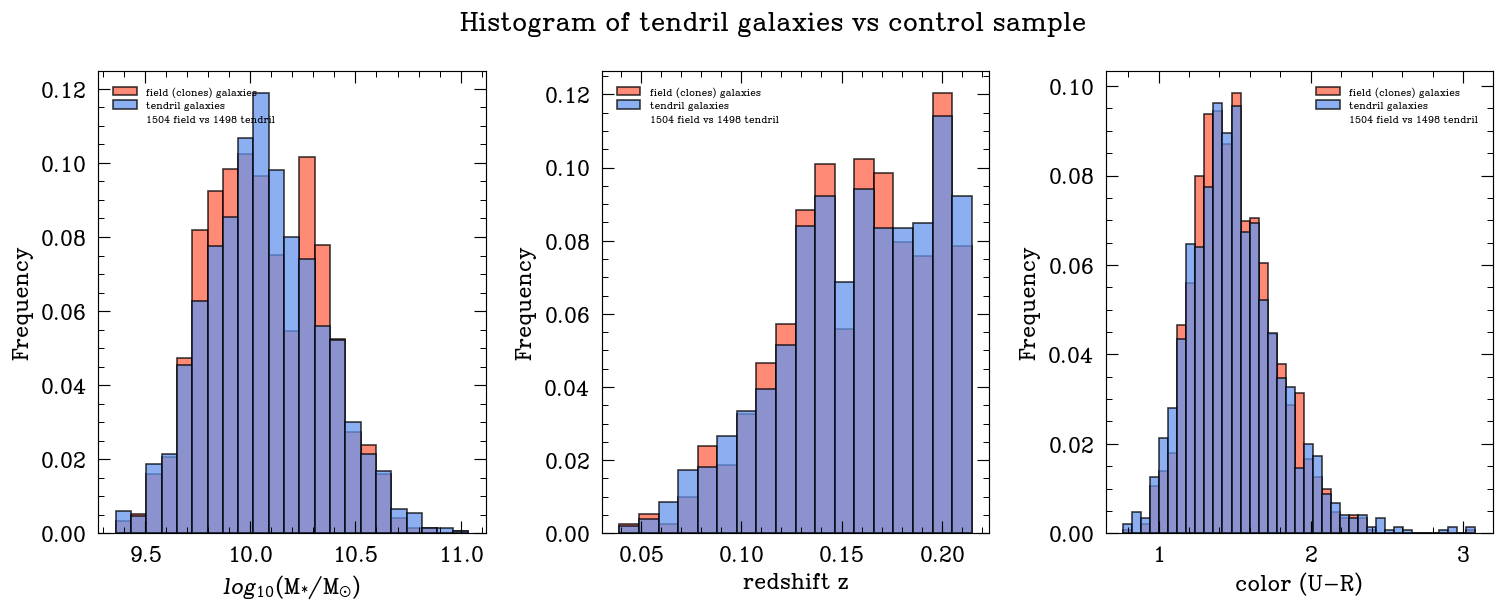

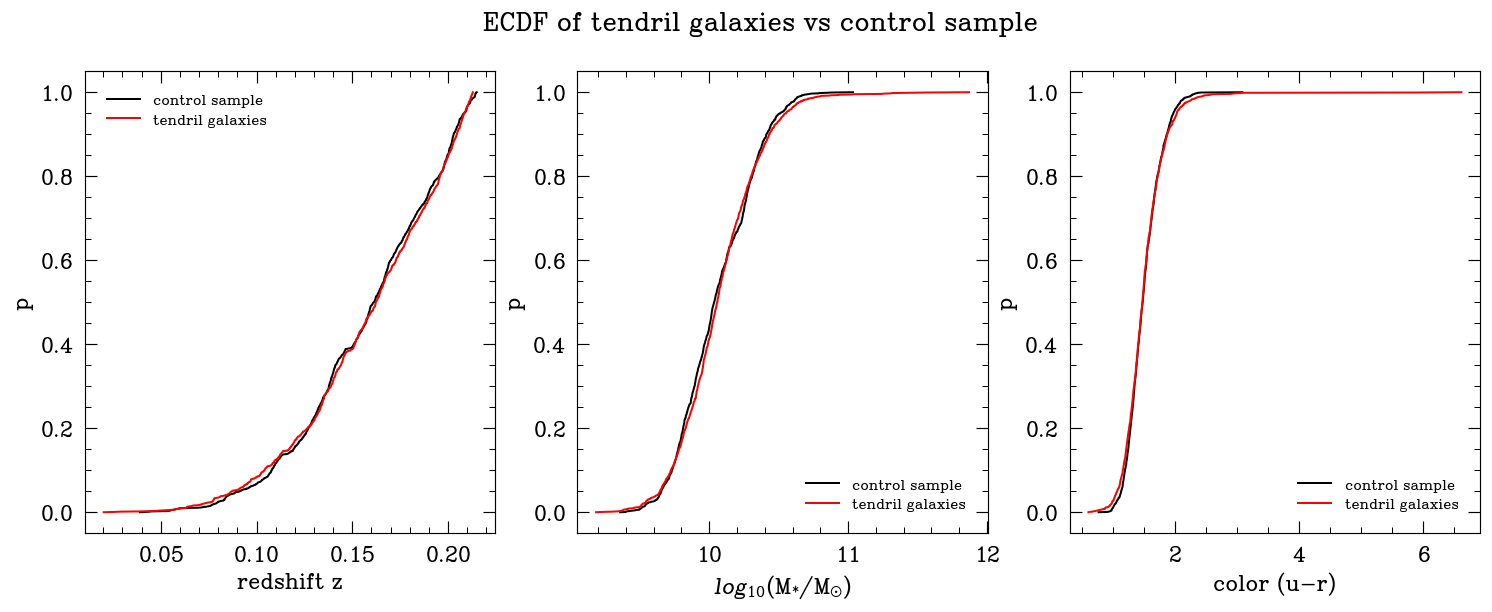

In [67]:
#Ploteamos histogramas para comaprar los clones encontrados de field galaxias para las tendril galaxies
fig,axs=subplots(1,3,figsize=(15,5))
bins=12

#logmstar
axs[0].hist(logmstar_field_SF_tendrilclone,bins = histogram_bin_edges(logmstar_field_SF_tendrilclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_field_SF_tendrilclone))/len(logmstar_field_SF_tendrilclone),label="field (clones) galaxies")
axs[0].hist(logmstar_tendril_SF_clone,bins = histogram_bin_edges(logmstar_field_SF_tendrilclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_tendril_SF_clone))/len(logmstar_tendril_SF_clone),label="tendril galaxies")

axs[0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[0].set_ylabel("Frequency")
axs[0].plot([], [], " ", label=f"{len(logmstar_field_SF_tendrilclone)} field vs {len(logmstar_tendril_SF_clone)} tendril")
axs[0].legend(fontsize=7,loc="upper left")

#redshift
axs[1].hist(redshift_field_SF_tendrilclone,bins = histogram_bin_edges(redshift_field_SF_tendrilclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(redshift_field_SF_tendrilclone))/len(redshift_field_SF_tendrilclone),label="field (clones) galaxies")
axs[1].hist(redshift_tendril_SF_clone,bins = histogram_bin_edges(redshift_field_SF_tendrilclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(redshift_tendril_SF_clone))/len(redshift_tendril_SF_clone),label="tendril galaxies")

axs[1].set_xlabel("redshift z")
axs[1].set_ylabel("Frequency")
axs[1].plot([], [], " ", label=f"{len(redshift_field_SF_tendrilclone)} field vs {len(redshift_tendril_SF_clone)} tendril")
axs[1].legend(fontsize=7,loc="upper left")

#colour
axs[2].hist(colorur_field_SF_tendrilclone,bins = histogram_bin_edges(colorur_field_SF_tendrilclone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(colorur_field_SF_tendrilclone))/len(colorur_field_SF_tendrilclone),label="field (clones) galaxies")
axs[2].hist(colorur_tendril_SF_clone,bins = histogram_bin_edges(colorur_field_SF_tendrilclone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(colorur_tendril_SF_clone))/len(colorur_tendril_SF_clone),label="tendril galaxies")

axs[2].set_xlabel("color (U-R)")
axs[2].set_ylabel("Frequency")
axs[2].plot([], [], " ", label=f"{len(colorur_field_SF_tendrilclone)} field vs {len(colorur_tendril_SF_clone)} tendril")
axs[2].legend(fontsize=7,loc="upper right")

subplots_adjust(wspace=0.3)
suptitle("Histogram of tendril galaxies vs control sample")
show()

#Ploteamos los ECDF para redshift, masa y color (alternativa a los histogramas para ver el comprotamiento de la dsitribución)
fig,axs=subplots(1,3,figsize=(15,5))

#redshift
sort_redshift_field_SF_tendrilclone = sort(redshift_field_SF_tendrilclone)
p_redshift_field_SF_tendrilclone = 1. * arange(len(redshift_field_SF_tendrilclone)) / (len(redshift_field_SF_tendrilclone) - 1)

sort_redshift_tendril_SF_clone = sort(redshift_tendril_SF_clone)
p_redshift_tendril_SF_clone = 1. * arange(len(redshift_tendril_SF_clone)) / (len(redshift_tendril_SF_clone) - 1)

#logmstar
sort_logmstar_field_SF_tendrilclone = sort(logmstar_field_SF_tendrilclone)
p_logmstar_field_SF_tendrilclone = 1. * arange(len(logmstar_field_SF_tendrilclone)) / (len(logmstar_field_SF_tendrilclone) - 1)

sort_logmstar_tendril_SF_clone = sort(logmstar_tendril_SF_clone)
p_logmstar_tendril_SF_clone = 1. * arange(len(logmstar_tendril_SF_clone)) / (len(logmstar_tendril_SF_clone) - 1)

#colorur
sort_colorur_field_SF_tendrilclone = sort(colorur_field_SF_tendrilclone)
p_colorur_field_SF_tendrilclone = 1. * arange(len(colorur_field_SF_tendrilclone)) / (len(colorur_field_SF_tendrilclone) - 1)

sort_colorur_tendril_SF_clone = sort(colorur_tendril_SF_clone)
p_colorur_tendril_SF_clone = 1. * arange(len(colorur_tendril_SF_clone)) / (len(colorur_tendril_SF_clone) - 1)

axs[0].plot(sort_redshift_field_SF_tendrilclone,p_redshift_field_SF_tendrilclone,color="black",label="control sample")
axs[0].plot(sort_redshift_tendril_SF_clone,p_redshift_tendril_SF_clone,color="red",label="tendril galaxies")
axs[0].set_xlabel("redshift z")
axs[0].set_ylabel("p")
axs[0].legend(loc = "upper left", fontsize=10)

axs[1].plot(sort_logmstar_field_SF_tendrilclone,p_logmstar_field_SF_tendrilclone,color="black",label="control sample")
axs[1].plot(sort_logmstar_tendril_SF_clone,p_logmstar_tendril_SF_clone,color="red",label="tendril galaxies")
axs[1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[1].set_ylabel("p")
axs[1].legend(loc = "lower right", fontsize=10)

axs[2].plot(sort_colorur_field_SF_tendrilclone,p_colorur_field_SF_tendrilclone,color="black",label="control sample")
axs[2].plot(sort_colorur_tendril_SF_clone,p_colorur_tendril_SF_clone,color="red",label="tendril galaxies")
axs[2].set_xlabel("color (u-r)")
axs[2].set_ylabel("p")
axs[2].legend(loc = "lower right", fontsize=10)

suptitle("ECDF of tendril galaxies vs control sample")
savefig(os.path.join("./Images","ECDF_tendril.pdf"),bbox_inches="tight") 
show()

##### Test de Kolmogorov-Smirnov y Test de Anderson-Darling

In [68]:
alpha = 0.05 # Nivel de significancia

# Test de Kolmogorov-Smirnov redshift
print("Test de Kolmogorov-Smirnov:")

p_valor_redshift_ks = ks_2samp(redshift_tendril_SF_clone, redshift_field_SF_tendrilclone).pvalue

if p_valor_redshift_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")

# Test de Kolmogorov-Smirnov logmstar
p_valor_logmstar_ks = ks_2samp(logmstar_tendril_SF_clone, logmstar_field_SF_tendrilclone).pvalue

if p_valor_logmstar_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")

# Test de Kolmogorov-Smirnov colorur
p_valor_colorur_ks = ks_2samp(colorur_tendril_SF_clone, colorur_field_SF_tendrilclone).pvalue

if p_valor_colorur_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")

print()
print("Test de Anderson-Darling:")

# Test de Anderson-Darling redshift
p_valor_redshift_ad = anderson_ksamp([redshift_tendril_SF_clone, redshift_field_SF_tendrilclone]).pvalue

if p_valor_redshift_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")

# Test de Anderson-Darling logmstar
p_valor_logmstar_ad = anderson_ksamp([logmstar_tendril_SF_clone, logmstar_field_SF_tendrilclone]).pvalue

if p_valor_logmstar_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")

# Test de Anderson-Darling colorur
p_valor_colorur_ad = anderson_ksamp([colorur_tendril_SF_clone, colorur_field_SF_tendrilclone]).pvalue

if p_valor_colorur_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")

Test de Kolmogorov-Smirnov:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.6775518321109276)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.08606148958046085)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.20454075946012462)

Test de Anderson-Darling:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.25)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.07433773955714984)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.055913054757242356)


### Control sample for void galaxies

Realizamos el mismo proceso pero para void galaxies

##### Clone search: void galaxies - field galaxies

In [69]:
#Seleccionamos aquellas SF Galaxias de las VOID GALAXIES
logmstar_void_SF=[]
redshift_void_SF=[]
colorur_void_SF=[]
CATAID_void_SF=[]
SFR_void_SF = []
Z_void_SF = []

colorur_void=void["M_model_u"]-void["M_model_r"]

for i in range(len(void["GALAXY_TYPE"])):
    if void["GALAXY_TYPE"][i]=="SF" and void["logmstar"][i]!=-99:
        logmstar_void_SF.append(void["logmstar"][i])
        redshift_void_SF.append(void["Z_TONRY"][i])
        colorur_void_SF.append(colorur_void[i])
        CATAID_void_SF.append(void["CATAID_2"][i])
        SFR_void_SF.append(void["SFR"][i])
        Z_void_SF.append(void["METALLICITY"][i])

In [70]:
# Llamamos a los clones encontrados
logmstar_field_SF_voidclone = []
redshift_field_SF_voidclone = []
colorur_field_SF_voidclone = []
Z_field_SF_voidclone = []
SFR_field_SF_voidclone = []

for i in range(len(field["CATAID_2"])):
    if field["control_sample_void"][i]=="Yes":
        logmstar_field_SF_voidclone.append(field["logmstar"][i])
        redshift_field_SF_voidclone.append(field["Z_TONRY"][i])
        colorur_field_SF_voidclone.append(field["M_model_u"][i]-field["M_model_r"][i])
        Z_field_SF_voidclone.append(field["METALLICITY"][i])
        SFR_field_SF_voidclone.append(field["SFR"][i])

# Llamamos a los voids
logmstar_void_SF_clone = logmstar_void_SF
redshift_void_SF_clone = redshift_void_SF
colorur_void_SF_clone = colorur_void_SF 

##### Histogram and Empirical Cumulative Distribution Function

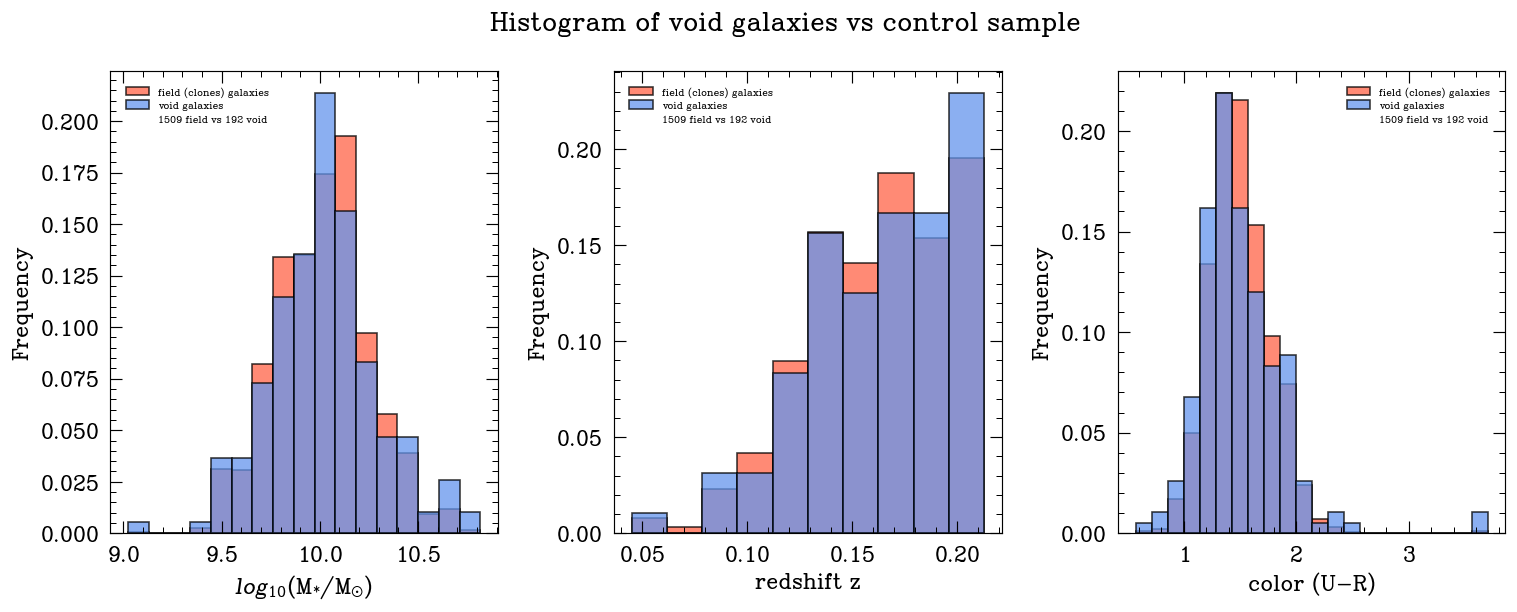

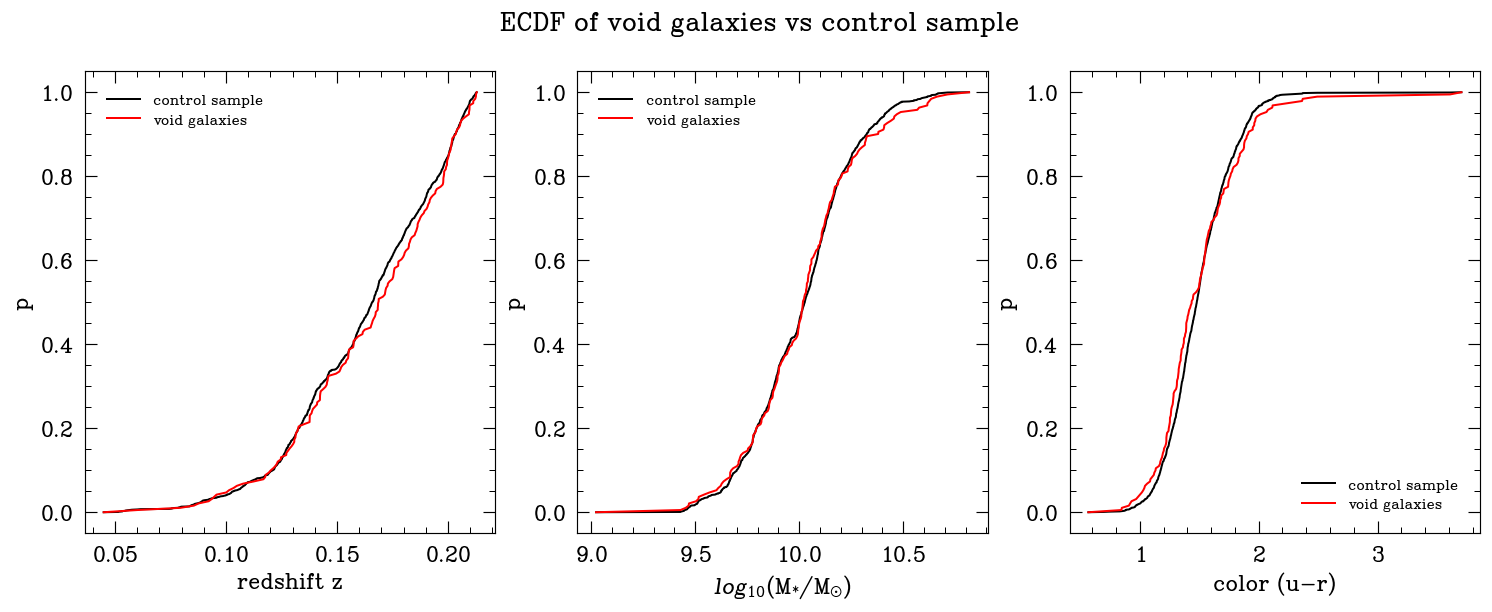

In [71]:
#Ploteamos histogramas para comaprar los clones encontrados de field galaxias para las void galaxies
fig,axs=subplots(1,3,figsize=(15,5))

#logmstar
axs[0].hist(logmstar_field_SF_voidclone,bins = histogram_bin_edges(logmstar_void_SF_clone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_field_SF_voidclone))/len(logmstar_field_SF_voidclone),label="field (clones) galaxies")
axs[0].hist(logmstar_void_SF_clone,bins = histogram_bin_edges(logmstar_void_SF_clone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(logmstar_void_SF_clone))/len(logmstar_void_SF_clone),label="void galaxies")

axs[0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[0].set_ylabel("Frequency")
axs[0].plot([], [], " ", label=f"{len(logmstar_field_SF_voidclone)} field vs {len(logmstar_void_SF_clone)} void")
axs[0].legend(fontsize=7,loc="upper left")

#redshift
axs[1].hist(redshift_field_SF_voidclone,bins = histogram_bin_edges(redshift_void_SF_clone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(redshift_field_SF_voidclone))/len(redshift_field_SF_voidclone),label="field (clones) galaxies")
axs[1].hist(redshift_void_SF_clone,bins = histogram_bin_edges(redshift_void_SF_clone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(redshift_void_SF_clone))/len(redshift_void_SF_clone),label="void galaxies")

axs[1].set_xlabel("redshift z")
axs[1].set_ylabel("Frequency")
axs[1].plot([], [], " ", label=f"{len(redshift_field_SF_voidclone)} field vs {len(redshift_void_SF_clone)} void")
axs[1].legend(fontsize=7,loc="upper left")

#colour
axs[2].hist(colorur_field_SF_voidclone,bins = histogram_bin_edges(colorur_void_SF_clone,bins="fd"),color="tomato",edgecolor="black",alpha=0.75,weights=ones(len(colorur_field_SF_voidclone))/len(colorur_field_SF_voidclone),label="field (clones) galaxies")
axs[2].hist(colorur_void_SF_clone,bins = histogram_bin_edges(colorur_void_SF_clone,bins="fd"),color="cornflowerblue",edgecolor="black",alpha=0.75,weights=ones(len(colorur_void_SF_clone))/len(colorur_void_SF_clone),label="void galaxies")

axs[2].set_xlabel("color (U-R)")
axs[2].set_ylabel("Frequency")
axs[2].plot([], [], " ", label=f"{len(colorur_field_SF_voidclone)} field vs {len(colorur_void_SF_clone)} void")
axs[2].legend(fontsize=7,loc="upper right")

subplots_adjust(wspace=0.3)
suptitle("Histogram of void galaxies vs control sample")
show()

#Ploteamos los ECDF para redshift, masa y color (alternativa a los histogramas para ver el comprotamiento de la dsitribución)
fig,axs=subplots(1,3,figsize=(15,5))

#redshift
sort_redshift_field_SF_voidclone = sort(redshift_field_SF_voidclone)
p_redshift_field_SF_voidclone = 1. * arange(len(redshift_field_SF_voidclone)) / (len(redshift_field_SF_voidclone) - 1)

sort_redshift_void_SF_clone = sort(redshift_void_SF_clone)
p_redshift_void_SF_clone = 1. * arange(len(redshift_void_SF_clone)) / (len(redshift_void_SF_clone) - 1)

#logmstar
sort_logmstar_field_SF_voidclone = sort(logmstar_field_SF_voidclone)
p_logmstar_field_SF_voidclone = 1. * arange(len(logmstar_field_SF_voidclone)) / (len(logmstar_field_SF_voidclone) - 1)

sort_logmstar_void_SF_clone = sort(logmstar_void_SF_clone)
p_logmstar_void_SF_clone = 1. * arange(len(logmstar_void_SF_clone)) / (len(logmstar_void_SF_clone) - 1)

#colorur
sort_colorur_field_SF_voidclone = sort(colorur_field_SF_voidclone)
p_colorur_field_SF_voidclone = 1. * arange(len(colorur_field_SF_voidclone)) / (len(colorur_field_SF_voidclone) - 1)

sort_colorur_void_SF_clone = sort(colorur_void_SF_clone)
p_colorur_void_SF_clone = 1. * arange(len(colorur_void_SF_clone)) / (len(colorur_void_SF_clone) - 1)

axs[0].plot(sort_redshift_field_SF_voidclone,p_redshift_field_SF_voidclone,color="black",label="control sample")
axs[0].plot(sort_redshift_void_SF_clone,p_redshift_void_SF_clone,color="red",label="void galaxies")
axs[0].set_xlabel("redshift z")
axs[0].set_ylabel("p")
axs[0].legend(loc = "upper left", fontsize=10)

axs[1].plot(sort_logmstar_field_SF_voidclone,p_logmstar_field_SF_voidclone,color="black",label="control sample")
axs[1].plot(sort_logmstar_void_SF_clone,p_logmstar_void_SF_clone,color="red",label="void galaxies")
axs[1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axs[1].set_ylabel("p")
axs[1].legend(loc = "upper left", fontsize=10)

axs[2].plot(sort_colorur_field_SF_voidclone,p_colorur_field_SF_voidclone,color="black",label="control sample")
axs[2].plot(sort_colorur_void_SF_clone,p_colorur_void_SF_clone,color="red",label="void galaxies")
axs[2].set_xlabel("color (u-r)")
axs[2].set_ylabel("p")
axs[2].legend(loc = "lower right", fontsize=10)

suptitle("ECDF of void galaxies vs control sample")
savefig(os.path.join("./Images","ECDF_void.pdf"),bbox_inches="tight") 
show()

##### Test de Kolmogorov-Smirnov y Test de Anderson-Darling

In [72]:
alpha = 0.05 # Nivel de significancia

# Test de Kolmogorov-Smirnov redshift
print("Test de Kolmogorov-Smirnov:")

p_valor_redshift_ks = ks_2samp(redshift_void_SF_clone, redshift_field_SF_voidclone).pvalue

if p_valor_redshift_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ks})")

# Test de Kolmogorov-Smirnov logmstar
p_valor_logmstar_ks = ks_2samp(logmstar_void_SF_clone, logmstar_field_SF_voidclone).pvalue

if p_valor_logmstar_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ks})")

# Test de Kolmogorov-Smirnov colorur
p_valor_colorur_ks = ks_2samp(colorur_void_SF_clone, colorur_field_SF_voidclone).pvalue

if p_valor_colorur_ks < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ks})")

print()
print("Test de Anderson-Darling:")

# Test de Anderson-Darling redshift
p_valor_redshift_ad = anderson_ksamp([redshift_void_SF_clone, redshift_field_SF_voidclone]).pvalue

if p_valor_redshift_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en redshift(p-valor: {p_valor_redshift_ad})")

# Test de Anderson-Darling logmstar
p_valor_logmstar_ad = anderson_ksamp([logmstar_void_SF_clone, logmstar_field_SF_voidclone]).pvalue

if p_valor_logmstar_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en logmstar(p-valor: {p_valor_logmstar_ad})")

# Test de Anderson-Darling colorur
p_valor_colorur_ad = anderson_ksamp([colorur_void_SF_clone, colorur_field_SF_voidclone]).pvalue

if p_valor_colorur_ad < alpha:
    print(f"Las poblaciones NO siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")
else:
    print(f"Las poblaciones siguen la misma distribución en colorur(p-valor: {p_valor_colorur_ad})")

Test de Kolmogorov-Smirnov:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.5869012207589719)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.8039753384842078)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.16530396730617372)

Test de Anderson-Darling:
Las poblaciones siguen la misma distribución en redshift(p-valor: 0.25)
Las poblaciones siguen la misma distribución en logmstar(p-valor: 0.25)
Las poblaciones siguen la misma distribución en colorur(p-valor: 0.06787807426510988)


Nótese que en todo este proceso, las vairables llamadas como (e.g) colorur_void_SF_clone hacen referencia a las void galaxies y las variables llamadas como colorur_field_SF_voidclone a las field galaxies encontradas que son parecidas a algunas de la muestra de vid galaxies. 

## 16. Scale Relations

A continuación vamos a realizar las principales relaciones de escala de interés con sus ajustes bayesianos.

### Without Outliers

Antes de plotear las relaciones de escala, vamos a deshacernos de las galaxias outliers para que los fits tengan mas senitdo. Para ello, trabajaremos con una máscara para quedarnos con un cierto rango de valores.

In [73]:
# Función que elimina outliers dados un dato, un límite iferior y otro superior
def without_outliers(data_x, data_y, inf_lim_x, sup_lim_x, inf_lim_y, sup_lim_y):
    
    array_data_x = array(data_x)
    array_data_y = array(data_y)
    
    mask = (array_data_x >= inf_lim_x) & (array_data_x <= sup_lim_x) & (array_data_y >= inf_lim_y) & (array_data_y <= sup_lim_y)

    return array_data_x[mask], array_data_y[mask]

### M-Z Relation

##### Filaments - Control Sample

Reprentamos la M-Z Relation para galaxias en filamentos y su muestra control.

Coeficientes GAMA:  5.6828601133544066
Coeficientes FILAMENTOS:  [5.69507156]
Coeficientes CONTROL SAMPLE:  [5.68595447]
Difference FILAMENTS - CONTROL SAMPLE:  [0.00911709]


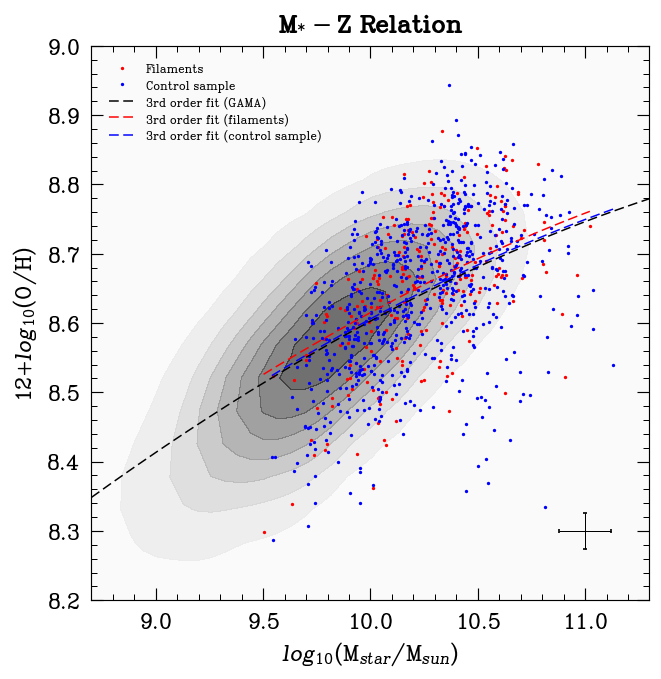

In [74]:
# Without Outliers
logmstar_fil_SF_woZ, Z_fil_SF_wo = without_outliers(logmstar_fil_SF, Z_fil_SF, 8, 11.7, 7.8, 9.1)
logmstar_field_SF_filclone_woZ, Z_field_SF_filclone_wo = without_outliers(logmstar_field_SF_filclone, Z_field_SF_filclone, 8, 11.7, 7.8, 9.1)
logmstar_SF_woZ, PPO4_SF_woZ = without_outliers(logmstar_SF, PPO4_SF, 8, 11.7, 7.8, 9.1)

# Ploteamos las relaciones Z para filamentos -  muestra control
plot(logmstar_fil_SF_woZ,Z_fil_SF_wo,".",color="red",markersize = 2, label = "Filaments") # filaments
plot(logmstar_field_SF_filclone_woZ,Z_field_SF_filclone_wo,".",color="blue",markersize = 2, label = "Control sample") # control sample
#plot(logmstar_SF_woZ,PPO4_SF_woZ,".",color="black",markersize=0.7, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8.7,11.3)
ylim(8.2,9)

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
p_Zfil_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ, 3) 
y_Zfit_all = polyval(p_Zfil_all,logmstar_SF_woZ)

# Pesos w
w_Zfil_all=[]
resid_Zfil_all=[]
for m in range(len(y_Zfit_all)):
    resid_Zfil_all.append((PPO4_SF_woZ)[m]-y_Zfit_all[m])
    w_Zfil_all.append(1/resid_Zfil_all[m]**2)

#Ajuste por polinomios con w
p_w_Zfil_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ,3, w = w_Zfil_all) 
y_fit_w_Zfil_all = polyval(p_w_Zfil_all,logmstar_SF_woZ) 

plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Zfil_all),"--",color="black",label="3rd order fit (GAMA)",linewidth = 0.9)

# AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
p_Zfil = polyfit(logmstar_fil_SF_woZ, Z_fil_SF_wo, 3) 
y_Zfit = polyval(p_Zfil,logmstar_fil_SF_woZ)

# Pesos w
w_Zfil=[]
resid_Zfil=[]
for m in range(len(y_Zfit)):
    resid_Zfil.append((Z_fil_SF_wo)[m]-y_Zfit[m])
    w_Zfil.append(1/resid_Zfil[m]**2)

#Ajuste por polinomios con w
p_w_Zfil = polyfit(logmstar_fil_SF_woZ, Z_fil_SF_wo,3, w = w_Zfil) 
y_fit_w_Zfil = polyval(p_w_Zfil,logmstar_fil_SF_woZ) 

#plot(sorted(logmstar_fil_SF_woZ),sorted(y_fit_w_Zfil),"--",color="red",label="3rd order fit (filaments)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
p_Zfilclone = polyfit(logmstar_field_SF_filclone_woZ, Z_field_SF_filclone_wo,3) 
y_Zfitclone = polyval(p_Zfilclone, logmstar_field_SF_filclone_woZ)

# Pesos w
w_Zfilclone=[]
resid_Zfilclone=[]
for m in range(len(y_Zfitclone)):
    resid_Zfilclone.append((Z_field_SF_filclone_wo)[m]-y_Zfitclone[m])
    w_Zfilclone.append(1/resid_Zfilclone[m]**2)

#Ajuste por polinomios con w
p_w_Zfilclone = polyfit(logmstar_field_SF_filclone_woZ, Z_field_SF_filclone_wo,3, w = w_Zfilclone) 
y_fit_w_Zfilclone = polyval(p_w_Zfilclone, logmstar_field_SF_filclone_woZ) 

#plot(sorted(logmstar_field_SF_filclone_woZ),sorted(y_fit_w_Zfilclone),"--",color="blue",label="3rd order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - FILAMENTOS ---------------------------------------------------------------------------
a,b,c = p_w_Zfil_all[0],p_w_Zfil_all[1],p_w_Zfil_all[2]
d_0_fil = p_w_Zfil[3]

#Modelo con a,b y c fijos
def model_fil(x_fil,d_fil):
    return a*x_fil**3+b*x_fil**2+c*x_fil+d_fil

#Ajuste con a,b y c fijos
coef_filZ, cov_filZ = curve_fit(model_fil, logmstar_fil_SF_woZ, Z_fil_SF_wo, p0 = [d_0_fil])

x_modeloZ_fil = linspace(min(logmstar_fil_SF_woZ),max(logmstar_fil_SF_woZ),100)
y_modeloZ_fil = model_fil(x_modeloZ_fil,coef_filZ[0])

plot(x_modeloZ_fil, y_modeloZ_fil,"--" ,color = "red",label = "3rd order fit (filaments)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a,b,c = p_w_Zfil_all[0],p_w_Zfil_all[1],p_w_Zfil_all[2]
d_0_filclone = p_w_Zfilclone[3]

#Modelo con a,b y c fijos
def model_filclone(x_filclone,d_filclone):
    return a*x_filclone**3+b*x_filclone**2+c*x_filclone+d_filclone

#Ajuste con a,b y c fijos
coef_filcloneZ, cov_filcloneZ = curve_fit(model_filclone, logmstar_field_SF_filclone_woZ, Z_field_SF_filclone_wo, p0 = [d_0_filclone])

x_modeloZ_filclone = linspace(min(logmstar_field_SF_filclone_woZ),max(logmstar_field_SF_filclone_woZ),100)
y_modeloZ_filclone = model_fil(x_modeloZ_filclone, coef_filcloneZ[0])

plot(x_modeloZ_filclone, y_modeloZ_filclone,"--" ,color = "blue",label = "3rd order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_Zfil_all[3])
print("Coeficientes FILAMENTOS: ",coef_filZ)
print("Coeficientes CONTROL SAMPLE: ",coef_filcloneZ)
print("Difference FILAMENTS - CONTROL SAMPLE: ", abs(coef_filZ-coef_filcloneZ))

errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error
legend(fontsize = 8)
show()

##### Tendrils - Control Sample

Reprentamos la M-Z Relation para tendrils y su muestra control.

Coeficientes GAMA:  5.6828601133544066
Coeficientes TENDRIL:  [5.68907801]
Coeficientes CONTROL SAMPLE:  [5.69741109]
Difference TENDRIL - CONTROL SAMPLE:  [0.00833309]


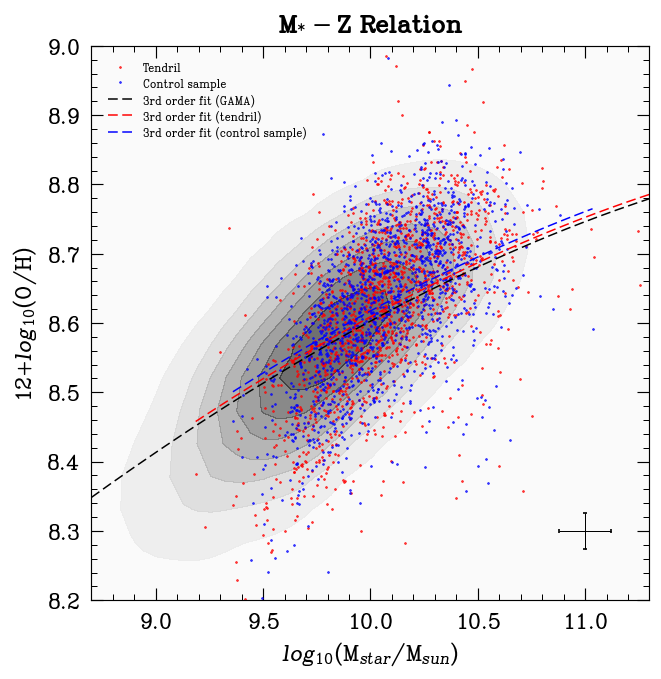

In [75]:
# Without Outliers
logmstar_tendril_SF_woZ, Z_tendril_SF_wo = without_outliers(logmstar_tendril_SF, Z_tendril_SF, 8, 11.7, 7.8, 9.1)
logmstar_field_SF_tendrilclone_woZ, Z_field_SF_tendrilclone_wo = without_outliers(logmstar_field_SF_tendrilclone, Z_field_SF_tendrilclone, 8, 11.7, 7.8, 9.1)
logmstar_SF_woZ, PPO4_SF_woZ = without_outliers(logmstar_SF, PPO4_SF, 8, 11.7, 7.8, 9.1)

# Ploteamos las relaciones Z para tendrilamentos -  muestra control
plot(logmstar_tendril_SF_woZ,Z_tendril_SF_wo,".",color="red",markersize = 1, label = "Tendril") # tendrilaments
plot(logmstar_field_SF_tendrilclone_woZ,Z_field_SF_tendrilclone_wo,".",color="blue",markersize = 1, label = "Control sample") # control sample
#plot(logmstar_SF_woZ,PPO4_SF_woZ,".",color="black",markersize=0.7, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8.7,11.3)
ylim(8.2,9)

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
p_Ztendril_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ, 3) 
y_Zfit_all = polyval(p_Ztendril_all,logmstar_SF_woZ)

# Pesos w
w_Ztendril_all=[]
resid_Ztendril_all=[]
for m in range(len(y_Zfit_all)):
    resid_Ztendril_all.append((PPO4_SF_woZ)[m]-y_Zfit_all[m])
    w_Ztendril_all.append(1/resid_Ztendril_all[m]**2)

#Ajuste por polinomios con w
p_w_Ztendril_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ,3, w = w_Ztendril_all) 
y_fit_w_Ztendril_all = polyval(p_w_Ztendril_all,logmstar_SF_woZ) 

plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Ztendril_all),"--",color="black",label="3rd order fit (GAMA)",linewidth = 0.9)

# AJUSTE tendrilAMENTOS --------------------------------------------------------------------------------------------------------------
p_Ztendril = polyfit(logmstar_tendril_SF_woZ, Z_tendril_SF_wo, 3) 
y_Zfit = polyval(p_Ztendril,logmstar_tendril_SF_woZ)

# Pesos w
w_Ztendril=[]
resid_Ztendril=[]
for m in range(len(y_Zfit)):
    resid_Ztendril.append((Z_tendril_SF_wo)[m]-y_Zfit[m])
    w_Ztendril.append(1/resid_Ztendril[m]**2)

#Ajuste por polinomios con w
p_w_Ztendril = polyfit(logmstar_tendril_SF_woZ, Z_tendril_SF_wo,3, w = w_Ztendril) 
y_fit_w_Ztendril = polyval(p_w_Ztendril,logmstar_tendril_SF_woZ) 

#plot(sorted(logmstar_tendril_SF_woZ),sorted(y_fit_w_Ztendril),"--",color="red",label="3rd order fit (tendrilaments)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
p_Ztendrilclone = polyfit(logmstar_field_SF_tendrilclone_woZ, Z_field_SF_tendrilclone_wo,3) 
y_Zfitclone = polyval(p_Ztendrilclone, logmstar_field_SF_tendrilclone_woZ)

# Pesos w
w_Ztendrilclone=[]
resid_Ztendrilclone=[]
for m in range(len(y_Zfitclone)):
    resid_Ztendrilclone.append((Z_field_SF_tendrilclone_wo)[m]-y_Zfitclone[m])
    w_Ztendrilclone.append(1/resid_Ztendrilclone[m]**2)

#Ajuste por polinomios con w
p_w_Ztendrilclone = polyfit(logmstar_field_SF_tendrilclone_woZ, Z_field_SF_tendrilclone_wo,3, w = w_Ztendrilclone) 
y_fit_w_Ztendrilclone = polyval(p_w_Ztendrilclone, logmstar_field_SF_tendrilclone_woZ) 

#plot(sorted(logmstar_field_SF_tendrilclone_woZ),sorted(y_fit_w_Ztendrilclone),"--",color="blue",label="3rd order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - tendrilAMENTOS ---------------------------------------------------------------------------
a,b,c = p_w_Ztendril_all[0],p_w_Ztendril_all[1],p_w_Ztendril_all[2]
d_0_tendril = p_w_Ztendril[3]

#Modelo con a,b y c fijos
def model_tendril(x_tendril,d_tendril):
    return a*x_tendril**3+b*x_tendril**2+c*x_tendril+d_tendril

#Ajuste con a,b y c fijos
coef_tendrilZ,cov_tendrilZ = curve_fit(model_tendril, logmstar_tendril_SF_woZ, Z_tendril_SF_wo, p0 = [d_0_tendril])

x_modeloZ_tendril = linspace(min(logmstar_tendril_SF_woZ),max(logmstar_tendril_SF_woZ),100)
y_modeloZ_tendril = model_tendril(x_modeloZ_tendril,coef_tendrilZ[0])

plot(x_modeloZ_tendril, y_modeloZ_tendril,"--" ,color = "red",label = "3rd order fit (tendril)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a,b,c = p_w_Ztendril_all[0],p_w_Ztendril_all[1],p_w_Ztendril_all[2]
d_0_tendrilclone = p_w_Ztendrilclone[3]

#Modelo con a,b y c fijos
def model_tendrilclone(x_tendrilclone,d_tendrilclone):
    return a*x_tendrilclone**3+b*x_tendrilclone**2+c*x_tendrilclone+d_tendrilclone

#Ajuste con a,b y c fijos
coef_tendrilcloneZ, cov_tendrilcloneZ = curve_fit(model_tendrilclone, logmstar_field_SF_tendrilclone_woZ, Z_field_SF_tendrilclone_wo, p0 = [d_0_tendrilclone])

x_modeloZ_tendrilclone = linspace(min(logmstar_field_SF_tendrilclone_woZ),max(logmstar_field_SF_tendrilclone_woZ),100)
y_modeloZ_tendrilclone = model_tendril(x_modeloZ_tendrilclone, coef_tendrilcloneZ[0])

plot(x_modeloZ_tendrilclone, y_modeloZ_tendrilclone,"--" ,color = "blue",label = "3rd order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_Ztendril_all[3])
print("Coeficientes TENDRIL: ",coef_tendrilZ)
print("Coeficientes CONTROL SAMPLE: ",coef_tendrilcloneZ)
print("Difference TENDRIL - CONTROL SAMPLE: ", abs(coef_tendrilZ-coef_tendrilcloneZ))

errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error
legend(fontsize = 7.5)
show()

##### Voids - Control Sample

Reprentamos la M-Z Relation para galaxias en voids y su muestra control.

Coeficientes GAMA:  5.6828601133544066
Coeficientes VOID:  [5.67902658]
Coeficientes CONTROL SAMPLE:  [5.69083058]
Difference VOID - CONTROL SAMPLE:  [0.01180401]


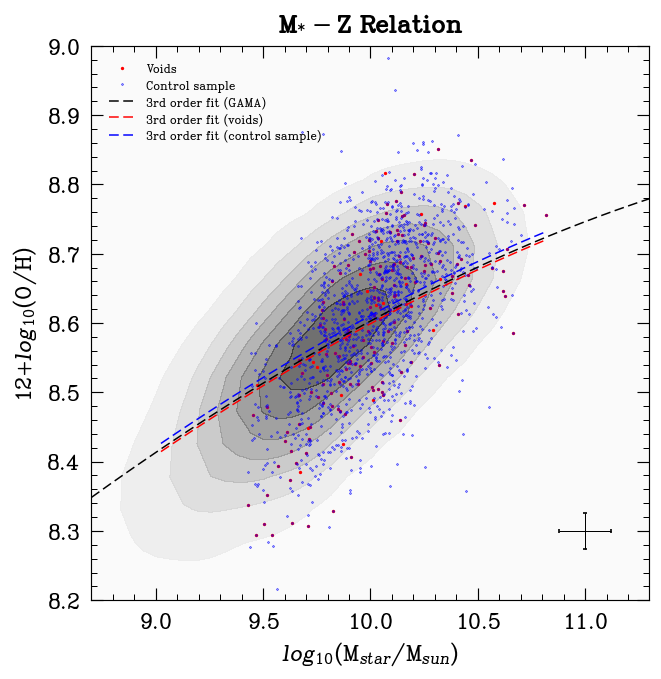

In [76]:
# Without Outliers
logmstar_void_SF_woZ, Z_void_SF_wo = without_outliers(logmstar_void_SF, Z_void_SF, 8, 11.7, 7.8, 9.1)
logmstar_field_SF_voidclone_woZ, Z_field_SF_voidclone_wo = without_outliers(logmstar_field_SF_voidclone, Z_field_SF_voidclone, 8, 11.7, 7.8, 9.1)
logmstar_SF_woZ, PPO4_SF_woZ = without_outliers(logmstar_SF, PPO4_SF, 8, 11.7, 7.8, 9.1)

# Ploteamos las relaciones Z para voidamentos -  muestra control
plot(logmstar_void_SF_woZ,Z_void_SF_wo,".",color="red",markersize = 2, label = "Voids") # voidaments
plot(logmstar_field_SF_voidclone_woZ,Z_field_SF_voidclone_wo,".",color="blue",markersize = 0.7, label = "Control sample") # control sample
#plot(logmstar_SF_woZ,PPO4_SF_woZ,".",color="black",markersize=0.7, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8.7,11.3)
ylim(8.2,9)

xlabel("$log_{10}$(M$_{star}$/M$_{sun}$)")
ylabel("12+$log_{10}$(O/H)")
title("M$_{*}-$Z Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
p_Zvoid_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ, 3) 
y_Zfit_all = polyval(p_Zvoid_all,logmstar_SF_woZ)

# Pesos w
w_Zvoid_all=[]
resid_Zvoid_all=[]
for m in range(len(y_Zfit_all)):
    resid_Zvoid_all.append((PPO4_SF_woZ)[m]-y_Zfit_all[m])
    w_Zvoid_all.append(1/resid_Zvoid_all[m]**2)

#Ajuste por polinomios con w
p_w_Zvoid_all = polyfit(logmstar_SF_woZ, PPO4_SF_woZ,3, w = w_Zvoid_all) 
y_fit_w_Zvoid_all = polyval(p_w_Zvoid_all,logmstar_SF_woZ) 

plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Zvoid_all),"--",color="black",label="3rd order fit (GAMA)",linewidth = 0.9)

# AJUSTE voidAMENTOS --------------------------------------------------------------------------------------------------------------
p_Zvoid = polyfit(logmstar_void_SF_woZ, Z_void_SF_wo, 3) 
y_Zfit = polyval(p_Zvoid,logmstar_void_SF_woZ)

# Pesos w
w_Zvoid=[]
resid_Zvoid=[]
for m in range(len(y_Zfit)):
    resid_Zvoid.append((Z_void_SF_wo)[m]-y_Zfit[m])
    w_Zvoid.append(1/resid_Zvoid[m]**2)

#Ajuste por polinomios con w
p_w_Zvoid = polyfit(logmstar_void_SF_woZ, Z_void_SF_wo,3, w = w_Zvoid) 
y_fit_w_Zvoid = polyval(p_w_Zvoid,logmstar_void_SF_woZ) 

#plot(sorted(logmstar_void_SF_woZ),sorted(y_fit_w_Zvoid),"--",color="red",label="3rd order fit (voidaments)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
p_Zvoidclone = polyfit(logmstar_field_SF_voidclone_woZ, Z_field_SF_voidclone_wo,3) 
y_Zfitclone = polyval(p_Zvoidclone, logmstar_field_SF_voidclone_woZ)

# Pesos w
w_Zvoidclone=[]
resid_Zvoidclone=[]
for m in range(len(y_Zfitclone)):
    resid_Zvoidclone.append((Z_field_SF_voidclone_wo)[m]-y_Zfitclone[m])
    w_Zvoidclone.append(1/resid_Zvoidclone[m]**2)

#Ajuste por polinomios con w
p_w_Zvoidclone = polyfit(logmstar_field_SF_voidclone_woZ, Z_field_SF_voidclone_wo,3, w = w_Zvoidclone) 
y_fit_w_Zvoidclone = polyval(p_w_Zvoidclone, logmstar_field_SF_voidclone_woZ) 

#plot(sorted(logmstar_field_SF_voidclone_woZ),sorted(y_fit_w_Zvoidclone),"--",color="blue",label="3rd order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - voidAMENTOS ---------------------------------------------------------------------------
a,b,c = p_w_Zvoid_all[0],p_w_Zvoid_all[1],p_w_Zvoid_all[2]
d_0_void = p_w_Zvoid[3]

#Modelo con a,b y c fijos
def model_void(x_void,d_void):
    return a*x_void**3+b*x_void**2+c*x_void+d_void

#Ajuste con a,b y c fijos
coef_voidZ,cov_voidZ = curve_fit(model_void, logmstar_void_SF_woZ, Z_void_SF_wo, p0 = [d_0_void])

x_modeloZ_void = linspace(min(logmstar_void_SF_woZ),max(logmstar_void_SF_woZ),100)
y_modeloZ_void = model_void(x_modeloZ_void,coef_voidZ[0])

plot(x_modeloZ_void, y_modeloZ_void,"--" ,color = "red",label = "3rd order fit (voids)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a,b,c = p_w_Zvoid_all[0],p_w_Zvoid_all[1],p_w_Zvoid_all[2]
d_0_voidclone = p_w_Zvoidclone[3]

#Modelo con a,b y c fijos
def model_voidclone(x_voidclone,d_voidclone):
    return a*x_voidclone**3+b*x_voidclone**2+c*x_voidclone+d_voidclone

#Ajuste con a,b y c fijos
coef_voidcloneZ, cov_voidcloneZ = curve_fit(model_voidclone, logmstar_field_SF_voidclone_woZ, Z_field_SF_voidclone_wo, p0 = [d_0_voidclone])

x_modeloZ_voidclone = linspace(min(logmstar_field_SF_voidclone_woZ),max(logmstar_field_SF_voidclone_woZ),100)
y_modeloZ_voidclone = model_void(x_modeloZ_voidclone, coef_voidcloneZ[0])

plot(x_modeloZ_voidclone, y_modeloZ_voidclone,"--" ,color = "blue",label = "3rd order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_Zvoid_all[3])
print("Coeficientes VOID: ",coef_voidZ)
print("Coeficientes CONTROL SAMPLE: ",coef_voidcloneZ)
print("Difference VOID - CONTROL SAMPLE: ", abs(coef_voidZ-coef_voidcloneZ))

errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1.2) #barras de error
legend(fontsize = 8)
show()

### M-SFR Relation

##### Filaments - Control Sample

Reprentamos la M-SFR Relation para galaxias en filamentos y su muestra control.

Coeficientes GAMA:  -7.137319749667084
Coeficientes FILAMENTOS:  [-6.97668828]
Coeficientes CONTROL SAMPLE:  [-7.12897875]
Difference FILAMENTS - CONTROL SAMPLE:  [0.15229047]


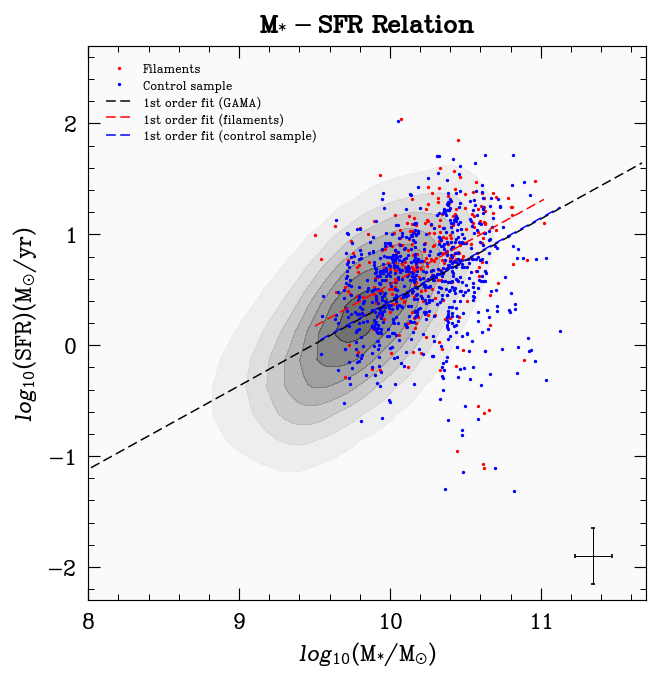

In [77]:
# Without Outliers
logmstar_fil_SF_woSFR, SFR_fil_SF_wo = without_outliers(logmstar_fil_SF, SFR_fil_SF, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_field_SF_filclone_woSFR, SFR_field_SF_filclone_wo = without_outliers(logmstar_field_SF_filclone, SFR_field_SF_filclone, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_SF_woSFR, SFR_SF_woSFR = without_outliers(logmstar_SF, SFR_SF, 8, 11.7, 10**(-2.2), 10**(2.2))

# Ploteamos las relaciones SFR para filamentos -  muestra control
plot(logmstar_fil_SF_woSFR,log10(SFR_fil_SF_wo),".",color="red",markersize = 2, label = "Filaments") # filaments
plot(logmstar_field_SF_filclone_woSFR,log10(SFR_field_SF_filclone_wo),".",color="blue",markersize = 2, label = "Control sample") # control sample
#plot(logmstar_SF_woSFR,log10(SFR_SF_woSFR),".",color="black",markersize = 1, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8,11.7)
ylim(-2.3,2.7)

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
title("M$_{*}-$SFR Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_SF_woSFR) == False)[0] #filtramos los datos para eliminar SFR = inf
SFR_SF_woSFR_isfinite = delete(SFR_SF_woSFR, inf_indices)
logmstar_SF_woSFR_isfinite = delete(logmstar_SF_woSFR, inf_indices)

p_SFRfil_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite), 1) 
y_SFRfit_all = polyval(p_SFRfil_all,logmstar_SF_woSFR_isfinite)

# Pesos w
w_SFRfil_all=[]
resid_SFRfil_all=[]
for m in range(len(y_SFRfit_all)):
    resid_SFRfil_all.append((log10(SFR_SF_woSFR_isfinite))[m]-y_SFRfit_all[m])
    w_SFRfil_all.append(1/resid_SFRfil_all[m]**2)

#Ajuste por polinomios con w
p_w_SFRfil_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite),1, w = w_SFRfil_all) 
y_fit_w_SFRfil_all = polyval(p_w_SFRfil_all,logmstar_SF_woSFR_isfinite) 

plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRfil_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)

# AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_fil_SF_wo) == False)[0] #filtramos los datos para eliminar SFR = inf
SFR_fil_SF_wo_isfinite = delete(SFR_fil_SF_wo, inf_indices)
logmstar_fil_SF_woSFR_isfinite = delete(logmstar_fil_SF_woSFR, inf_indices)

p_SFRfil = polyfit(logmstar_fil_SF_woSFR_isfinite, log10(SFR_fil_SF_wo_isfinite), 1) 
y_SFRfit = polyval(p_SFRfil,logmstar_fil_SF_woSFR_isfinite)

# Pesos w
w_SFRfil=[]
resid_SFRfil=[]
for m in range(len(y_SFRfit)):
    resid_SFRfil.append((log10(SFR_fil_SF_wo_isfinite))[m]-y_SFRfit[m])
    w_SFRfil.append(1/resid_SFRfil[m]**2)

#Ajuste por polinomios con w
p_w_SFRfil = polyfit(logmstar_fil_SF_woSFR_isfinite, log10(SFR_fil_SF_wo_isfinite),1, w = w_SFRfil) 
y_fit_w_SFRfil = polyval(p_w_SFRfil,logmstar_fil_SF_woSFR_isfinite) 

#plot(sorted(logmstar_fil_SF_woSFR_isfinite),sorted(y_fit_w_SFRfil),"--",color="red",label="1st order fit (filaments)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_field_SF_filclone_wo) == False)[0] #filtramos los datos para eliminar SFR = inf
SFR_field_SF_filclone_wo_isfinite = delete(SFR_field_SF_filclone_wo, inf_indices)
logmstar_field_SF_filclone_woSFR_isfinite = delete(logmstar_field_SF_filclone_woSFR, inf_indices)

p_SFRfilclone = polyfit(logmstar_field_SF_filclone_woSFR_isfinite, log10(SFR_field_SF_filclone_wo_isfinite),1) 
y_SFRfitclone = polyval(p_SFRfilclone, logmstar_field_SF_filclone_woSFR_isfinite)

# Pesos w
w_SFRfilclone=[]
resid_SFRfilclone=[]
for m in range(len(y_SFRfitclone)):
    resid_SFRfilclone.append((log10(SFR_field_SF_filclone_wo_isfinite))[m]-y_SFRfitclone[m])
    w_SFRfilclone.append(1/resid_SFRfilclone[m]**2)

#Ajuste por polinomios con w
p_w_SFRfilclone = polyfit(logmstar_field_SF_filclone_woSFR_isfinite, log10(SFR_field_SF_filclone_wo_isfinite),1, w = w_SFRfilclone) 
y_fit_w_SFRfilclone = polyval(p_w_SFRfilclone, logmstar_field_SF_filclone_woSFR_isfinite) 

#plot(sorted(logmstar_field_SF_filclone_woSFR_isfinite),sorted(y_fit_w_SFRfilclone),"--",color="blue",label="1st order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - FILAMENTOS ---------------------------------------------------------------------------
a = p_w_SFRfil_all[0]
d_0_fil = p_w_SFRfil[1]

#Modelo con a fijo
def model_fil(x_fil,d_fil):
    return a*x_fil+d_fil

#Ajuste con a,b y c fijos
coef_filSFR,cov_filSFR = curve_fit(model_fil, logmstar_fil_SF_woSFR_isfinite, log10(SFR_fil_SF_wo_isfinite), p0 = [d_0_fil])

x_modeloSFR_fil = linspace(min(logmstar_fil_SF_woSFR_isfinite),max(logmstar_fil_SF_woSFR_isfinite),100)
y_modeloSFR_fil = model_fil(x_modeloSFR_fil,coef_filSFR[0])

plot(x_modeloSFR_fil, y_modeloSFR_fil,"--" ,color = "red",label = "1st order fit (filaments)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a = p_w_SFRfil_all[0]
d_0_filclone = p_w_SFRfilclone[1]

#Modelo con a,b y c fijos
def model_filclone(x_filclone,d_filclone):
    return a*x_filclone+d_filclone

#Ajuste con a,b y c fijos
coef_filcloneSFR, cov_filcloneSFR = curve_fit(model_filclone, logmstar_field_SF_filclone_woSFR_isfinite, log10(SFR_field_SF_filclone_wo_isfinite), p0 = [d_0_filclone])

x_modeloSFR_filclone = linspace(min(logmstar_field_SF_filclone_woSFR_isfinite),max(logmstar_field_SF_filclone_woSFR_isfinite),100)
y_modeloSFR_filclone = model_fil(x_modeloSFR_filclone, coef_filcloneSFR[0])

plot(x_modeloSFR_filclone, y_modeloSFR_filclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_SFRfil_all[1])
print("Coeficientes FILAMENTOS: ",coef_filSFR)
print("Coeficientes CONTROL SAMPLE: ",coef_filcloneSFR)
print("Difference FILAMENTS - CONTROL SAMPLE: ", abs(coef_filSFR-coef_filcloneSFR))

errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
legend(fontsize = 8)
show()

##### Tendrils - Control Sample

Reprentamos la M-SFR Relation para tendrils y su muestra control.

Coeficientes GAMA:  -7.137319749667084
Coeficientes TENDRIL:  [-7.05904943]
Coeficientes CONTROL SAMPLE:  [-7.12497251]
Difference TENDRIL - CONTROL SAMPLE:  [0.06592308]


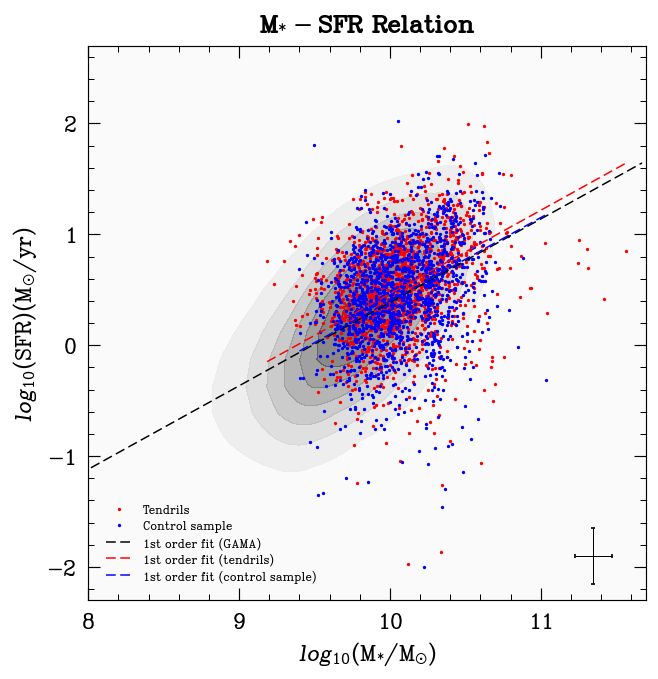

In [78]:
# Without Outliers
logmstar_tendril_SF_woSFR, SFR_tendril_SF_wo = without_outliers(logmstar_tendril_SF, SFR_tendril_SF, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_field_SF_tendrilclone_woSFR, SFR_field_SF_tendrilclone_wo = without_outliers(logmstar_field_SF_tendrilclone, SFR_field_SF_tendrilclone, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_SF_woSFR, SFR_SF_woSFR = without_outliers(logmstar_SF, SFR_SF, 8, 11.7, 10**(-2.2), 10**(2.2))

# Ploteamos las relaciones SFR para tendril -  muestra control
plot(logmstar_tendril_SF_woSFR,log10(SFR_tendril_SF_wo),".",color="red",markersize = 2, label = "Tendrils") # tendrils
plot(logmstar_field_SF_tendrilclone_woSFR,log10(SFR_field_SF_tendrilclone_wo),".",color="blue",markersize = 2, label = "Control sample") # control sample
#plot(logmstar_SF_woSFR,log10(SFR_SF_woSFR),".",color="black",markersize = 1, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8,11.7)
ylim(-2.3,2.7)

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
title("M$_{*}-$SFR Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_SF_woSFR) == False)[0] #tendrils los datos para eliminar SFR = inf
SFR_SF_woSFR_isfinite = delete(SFR_SF_woSFR, inf_indices)
logmstar_SF_woSFR_isfinite = delete(logmstar_SF_woSFR, inf_indices)

p_SFRtendril_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite), 1) 
y_SFRfit_all = polyval(p_SFRtendril_all,logmstar_SF_woSFR_isfinite)

# Pesos w
w_SFRtendril_all=[]
resid_SFRtendril_all=[]
for m in range(len(y_SFRfit_all)):
    resid_SFRtendril_all.append((log10(SFR_SF_woSFR_isfinite))[m]-y_SFRfit_all[m])
    w_SFRtendril_all.append(1/resid_SFRtendril_all[m]**2)

#Ajuste por polinomios con w
p_w_SFRtendril_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite),1, w = w_SFRtendril_all) 
y_fit_w_SFRtendril_all = polyval(p_w_SFRtendril_all,logmstar_SF_woSFR_isfinite) 

plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRtendril_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)

# AJUSTE TENDRIL --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_tendril_SF_wo) == False)[0] #tendrils los datos para eliminar SFR = inf
SFR_tendril_SF_wo_isfinite = delete(SFR_tendril_SF_wo, inf_indices)
logmstar_tendril_SF_woSFR_isfinite = delete(logmstar_tendril_SF_woSFR, inf_indices)

p_SFRtendril = polyfit(logmstar_tendril_SF_woSFR_isfinite, log10(SFR_tendril_SF_wo_isfinite), 1) 
y_SFRfit = polyval(p_SFRtendril,logmstar_tendril_SF_woSFR_isfinite)

# Pesos w
w_SFRtendril=[]
resid_SFRtendril=[]
for m in range(len(y_SFRfit)):
    resid_SFRtendril.append((log10(SFR_tendril_SF_wo_isfinite))[m]-y_SFRfit[m])
    w_SFRtendril.append(1/resid_SFRtendril[m]**2)

#Ajuste por polinomios con w
p_w_SFRtendril = polyfit(logmstar_tendril_SF_woSFR_isfinite, log10(SFR_tendril_SF_wo_isfinite),1, w = w_SFRtendril) 
y_fit_w_SFRtendril = polyval(p_w_SFRtendril,logmstar_tendril_SF_woSFR_isfinite) 

#plot(sorted(logmstar_tendril_SF_woSFR_isfinite),sorted(y_fit_w_SFRtendril),"--",color="red",label="1st order fit (tendrilaments)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_field_SF_tendrilclone_wo) == False)[0] #tendrils los datos para eliminar SFR = inf
SFR_field_SF_tendrilclone_wo_isfinite = delete(SFR_field_SF_tendrilclone_wo, inf_indices)
logmstar_field_SF_tendrilclone_woSFR_isfinite = delete(logmstar_field_SF_tendrilclone_woSFR, inf_indices)

p_SFRtendrilclone = polyfit(logmstar_field_SF_tendrilclone_woSFR_isfinite, log10(SFR_field_SF_tendrilclone_wo_isfinite),1) 
y_SFRfitclone = polyval(p_SFRtendrilclone, logmstar_field_SF_tendrilclone_woSFR_isfinite)

# Pesos w
w_SFRtendrilclone=[]
resid_SFRtendrilclone=[]
for m in range(len(y_SFRfitclone)):
    resid_SFRtendrilclone.append((log10(SFR_field_SF_tendrilclone_wo_isfinite))[m]-y_SFRfitclone[m])
    w_SFRtendrilclone.append(1/resid_SFRtendrilclone[m]**2)

#Ajuste por polinomios con w
p_w_SFRtendrilclone = polyfit(logmstar_field_SF_tendrilclone_woSFR_isfinite, log10(SFR_field_SF_tendrilclone_wo_isfinite),1, w = w_SFRtendrilclone) 
y_fit_w_SFRtendrilclone = polyval(p_w_SFRtendrilclone, logmstar_field_SF_tendrilclone_woSFR_isfinite) 

#plot(sorted(logmstar_field_SF_tendrilclone_woSFR_isfinite),sorted(y_fit_w_SFRtendrilclone),"--",color="blue",label="1st order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - tendrilAMENTOS ---------------------------------------------------------------------------
a = p_w_SFRtendril_all[0]
d_0_tendril = p_w_SFRtendril[1]

#Modelo con a fijo
def model_tendril(x_tendril,d_tendril):
    return a*x_tendril+d_tendril

#Ajuste con a,b y c fijos
coef_tendrilSFR,cov_tendrilSFR = curve_fit(model_tendril, logmstar_tendril_SF_woSFR_isfinite, log10(SFR_tendril_SF_wo_isfinite), p0 = [d_0_tendril])

x_modeloSFR_tendril = linspace(min(logmstar_tendril_SF_woSFR_isfinite),max(logmstar_tendril_SF_woSFR_isfinite),100)
y_modeloSFR_tendril = model_tendril(x_modeloSFR_tendril,coef_tendrilSFR[0])

plot(x_modeloSFR_tendril, y_modeloSFR_tendril,"--" ,color = "red",label = "1st order fit (tendrils)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a = p_w_SFRtendril_all[0]
d_0_tendrilclone = p_w_SFRtendrilclone[1]

#Modelo con a,b y c fijos
def model_tendrilclone(x_tendrilclone,d_tendrilclone):
    return a*x_tendrilclone+d_tendrilclone

#Ajuste con a,b y c fijos
coef_tendrilcloneSFR, cov_tendrilcloneSFR = curve_fit(model_tendrilclone, logmstar_field_SF_tendrilclone_woSFR_isfinite, log10(SFR_field_SF_tendrilclone_wo_isfinite), p0 = [d_0_tendrilclone])

x_modeloSFR_tendrilclone = linspace(min(logmstar_field_SF_tendrilclone_woSFR_isfinite),max(logmstar_field_SF_tendrilclone_woSFR_isfinite),100)
y_modeloSFR_tendrilclone = model_tendril(x_modeloSFR_tendrilclone, coef_tendrilcloneSFR[0])

plot(x_modeloSFR_tendrilclone, y_modeloSFR_tendrilclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_SFRtendril_all[1])
print("Coeficientes TENDRIL: ",coef_tendrilSFR)
print("Coeficientes CONTROL SAMPLE: ",coef_tendrilcloneSFR)
print("Difference TENDRIL - CONTROL SAMPLE: ", abs(coef_tendrilSFR-coef_tendrilcloneSFR))

errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
legend(fontsize = 8)
show()

##### Voids - Control Sample

Reprentamos la M-SFR Relation para voids y su muestra control.

Coeficientes GAMA:  -7.137319749667084
Coeficientes VOID:  [-7.02280519]
Coeficientes CONTROL SAMPLE:  [-7.1154352]
Difference VOIDS - CONTROL SAMPLE:  [0.09263001]


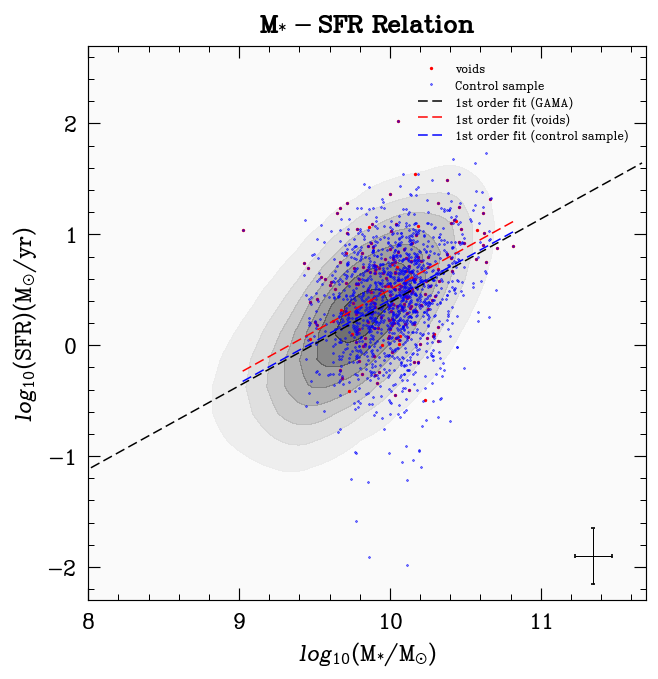

In [79]:
# Without Outliers
logmstar_void_SF_woSFR, SFR_void_SF_wo = without_outliers(logmstar_void_SF, SFR_void_SF, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_field_SF_voidclone_woSFR, SFR_field_SF_voidclone_wo = without_outliers(logmstar_field_SF_voidclone, SFR_field_SF_voidclone, 8, 11.7, 10**(-2.2), 10**(2.2))
logmstar_SF_woSFR, SFR_SF_woSFR = without_outliers(logmstar_SF, SFR_SF, 8, 11.7, 10**(-2.2), 10**(2.2))

# Ploteamos las relaciones SFR para void -  muestra control
plot(logmstar_void_SF_woSFR,log10(SFR_void_SF_wo),".",color="red",markersize = 2, label = "voids") # voids
plot(logmstar_field_SF_voidclone_woSFR,log10(SFR_field_SF_voidclone_wo),".",color="blue",markersize = 0.8, label = "Control sample") # control sample
#plot(logmstar_SF_woSFR,log10(SFR_SF_woSFR),".",color="black",markersize = 1, label = "GAMA") # GAMA (selected SF galaxies)
contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) # GAMA (selected SF galaxies)

xlim(8,11.7)
ylim(-2.3,2.7)

xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
title("M$_{*}-$SFR Relation",weight="bold")

# AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_SF_woSFR) == False)[0] #voids los datos para eliminar SFR = inf
SFR_SF_woSFR_isfinite = delete(SFR_SF_woSFR, inf_indices)
logmstar_SF_woSFR_isfinite = delete(logmstar_SF_woSFR, inf_indices)

p_SFRvoid_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite), 1) 
y_SFRfit_all = polyval(p_SFRvoid_all,logmstar_SF_woSFR_isfinite)

# Pesos w
w_SFRvoid_all=[]
resid_SFRvoid_all=[]
for m in range(len(y_SFRfit_all)):
    resid_SFRvoid_all.append((log10(SFR_SF_woSFR_isfinite))[m]-y_SFRfit_all[m])
    w_SFRvoid_all.append(1/resid_SFRvoid_all[m]**2)

#Ajuste por polinomios con w
p_w_SFRvoid_all = polyfit(logmstar_SF_woSFR_isfinite, log10(SFR_SF_woSFR_isfinite),1, w = w_SFRvoid_all) 
y_fit_w_SFRvoid_all = polyval(p_w_SFRvoid_all,logmstar_SF_woSFR_isfinite) 

plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRvoid_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)

# AJUSTE voidAMENTOS --------------------------------------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_void_SF_wo) == False)[0] #voids los datos para eliminar SFR = inf
SFR_void_SF_wo_isfinite = delete(SFR_void_SF_wo, inf_indices)
logmstar_void_SF_woSFR_isfinite = delete(logmstar_void_SF_woSFR, inf_indices)

p_SFRvoid = polyfit(logmstar_void_SF_woSFR_isfinite, log10(SFR_void_SF_wo_isfinite), 1) 
y_SFRfit = polyval(p_SFRvoid,logmstar_void_SF_woSFR_isfinite)

# Pesos w
w_SFRvoid=[]
resid_SFRvoid=[]
for m in range(len(y_SFRfit)):
    resid_SFRvoid.append((log10(SFR_void_SF_wo_isfinite))[m]-y_SFRfit[m])
    w_SFRvoid.append(1/resid_SFRvoid[m]**2)

#Ajuste por polinomios con w
p_w_SFRvoid = polyfit(logmstar_void_SF_woSFR_isfinite, log10(SFR_void_SF_wo_isfinite),1, w = w_SFRvoid) 
y_fit_w_SFRvoid = polyval(p_w_SFRvoid,logmstar_void_SF_woSFR_isfinite) 

#plot(sorted(logmstar_void_SF_woSFR_isfinite),sorted(y_fit_w_SFRvoid),"--",color="red",label="1st order fit (void)",linewidth=0.9)

# AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
inf_indices = where(isfinite(SFR_field_SF_voidclone_wo) == False)[0] #voids los datos para eliminar SFR = inf
SFR_field_SF_voidclone_wo_isfinite = delete(SFR_field_SF_voidclone_wo, inf_indices)
logmstar_field_SF_voidclone_woSFR_isfinite = delete(logmstar_field_SF_voidclone_woSFR, inf_indices)

p_SFRvoidclone = polyfit(logmstar_field_SF_voidclone_woSFR_isfinite, log10(SFR_field_SF_voidclone_wo_isfinite),1) 
y_SFRfitclone = polyval(p_SFRvoidclone, logmstar_field_SF_voidclone_woSFR_isfinite)

# Pesos w
w_SFRvoidclone=[]
resid_SFRvoidclone=[]
for m in range(len(y_SFRfitclone)):
    resid_SFRvoidclone.append((log10(SFR_field_SF_voidclone_wo_isfinite))[m]-y_SFRfitclone[m])
    w_SFRvoidclone.append(1/resid_SFRvoidclone[m]**2)

#Ajuste por polinomios con w
p_w_SFRvoidclone = polyfit(logmstar_field_SF_voidclone_woSFR_isfinite, log10(SFR_field_SF_voidclone_wo_isfinite),1, w = w_SFRvoidclone) 
y_fit_w_SFRvoidclone = polyval(p_w_SFRvoidclone, logmstar_field_SF_voidclone_woSFR_isfinite) 

#plot(sorted(logmstar_field_SF_voidclone_woSFR_isfinite),sorted(y_fit_w_SFRvoidclone),"--",color="blue",label="1st order fit (control sample)",linewidth=0.9)

#AJUSTE FIJANDO LOS COEFICEINTES - voidAMENTOS ---------------------------------------------------------------------------
a = p_w_SFRvoid_all[0]
d_0_void = p_w_SFRvoid[1]

#Modelo con a fijo
def model_void(x_void,d_void):
    return a*x_void+d_void

#Ajuste con a,b y c fijos
coef_voidSFR,cov_voidSFR = curve_fit(model_void, logmstar_void_SF_woSFR_isfinite, log10(SFR_void_SF_wo_isfinite), p0 = [d_0_void])

x_modeloSFR_void = linspace(min(logmstar_void_SF_woSFR_isfinite),max(logmstar_void_SF_woSFR_isfinite),100)
y_modeloSFR_void = model_void(x_modeloSFR_void,coef_voidSFR[0])

plot(x_modeloSFR_void, y_modeloSFR_void,"--" ,color = "red",label = "1st order fit (voids)",linewidth = 0.9) # fijos

#AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
a = p_w_SFRvoid_all[0]
d_0_voidclone = p_w_SFRvoidclone[1]

#Modelo con a,b y c fijos
def model_voidclone(x_voidclone,d_voidclone):
    return a*x_voidclone+d_voidclone

#Ajuste con a,b y c fijos
coef_voidcloneSFR, cov_voidcloneSFR = curve_fit(model_voidclone, logmstar_field_SF_voidclone_woSFR_isfinite, log10(SFR_field_SF_voidclone_wo_isfinite), p0 = [d_0_voidclone])

x_modeloSFR_voidclone = linspace(min(logmstar_field_SF_voidclone_woSFR_isfinite),max(logmstar_field_SF_voidclone_woSFR_isfinite),100)
y_modeloSFR_voidclone = model_void(x_modeloSFR_voidclone, coef_voidcloneSFR[0])

plot(x_modeloSFR_voidclone, y_modeloSFR_voidclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) # fijos

# IMPRIMIMOS COEFICEINTES AJUSTES --------------------------------------------------------------------------------------------
print("Coeficientes GAMA: ",p_w_SFRvoid_all[1])
print("Coeficientes VOID: ",coef_voidSFR)
print("Coeficientes CONTROL SAMPLE: ",coef_voidcloneSFR)
print("Difference VOIDS - CONTROL SAMPLE: ", abs(coef_voidSFR-coef_voidcloneSFR))

errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
legend(fontsize = 8)
show()

### Resume M-SFR/Z Relations

Resumimos los últimos plots de las M-Z y M-SFR Relations en uno sólo. 

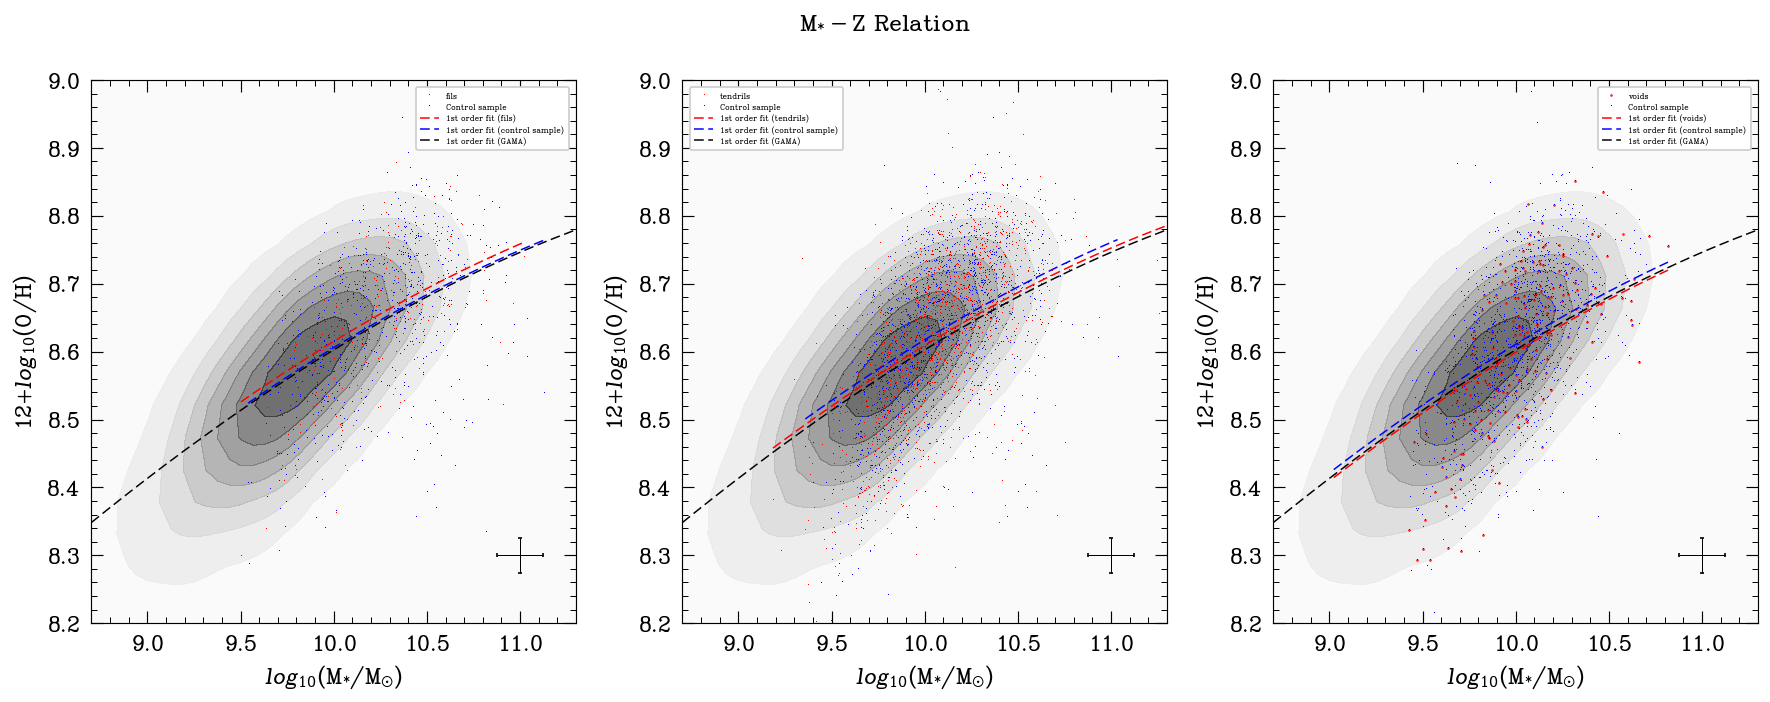

In [80]:
# M-Z RELATIONS
fig, axes = subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle("M$_{*}-$Z Relation", fontsize=16)

# FILAMENTS
axes[0].plot(logmstar_fil_SF_woZ,Z_fil_SF_wo,",",color="red",markersize = 50, label = "fils") 
axes[0].plot(logmstar_field_SF_filclone_woZ,Z_field_SF_filclone_wo,",",color="blue",markersize = 50, label = "Control sample") 
axes[0].contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) 
axes[0].plot(x_modeloZ_fil, y_modeloZ_fil,"--" ,color = "red",label = "1st order fit (fils)",linewidth = 0.9) 
axes[0].plot(x_modeloZ_filclone, y_modeloZ_filclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[0].plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Zfil_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[0].set_xlim(8.7,11.3)
axes[0].set_ylim(8.2,9)
axes[0].set_ylabel("12+$log_{10}$(O/H)")
axes[0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[0].errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[0].legend(fontsize = 5.5, frameon=True)

# TENDRILS
axes[1].plot(logmstar_tendril_SF_woZ,Z_tendril_SF_wo,",",color="red",markersize = 50, label = "tendrils") 
axes[1].plot(logmstar_field_SF_tendrilclone_woZ,Z_field_SF_tendrilclone_wo,",",color="blue",markersize = 50, label = "Control sample") 
axes[1].contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) 
axes[1].plot(x_modeloZ_tendril, y_modeloZ_tendril,"--" ,color = "red",label = "1st order fit (tendrils)",linewidth = 0.9) 
axes[1].plot(x_modeloZ_tendrilclone, y_modeloZ_tendrilclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[1].plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Ztendril_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[1].set_xlim(8.7,11.3)
axes[1].set_ylim(8.2,9)
axes[1].set_ylabel("12+$log_{10}$(O/H)")
axes[1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[1].errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[1].legend(fontsize = 5.5, frameon=True)

# VOIDS
axes[2].plot(logmstar_void_SF_woZ,Z_void_SF_wo,".",color="red",markersize = 1, label = "voids") 
axes[2].plot(logmstar_field_SF_voidclone_woZ,Z_field_SF_voidclone_wo,",",color="blue",markersize = 50, label = "Control sample") 
axes[2].contourf(xiZ,yiZ,ziZ.reshape(xiZ.shape),cmap="Greys", alpha = 0.6) 
axes[2].plot(x_modeloZ_void, y_modeloZ_void,"--" ,color = "red",label = "1st order fit (voids)",linewidth = 0.9) 
axes[2].plot(x_modeloZ_voidclone, y_modeloZ_voidclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[2].plot(sorted(logmstar_SF_woZ),sorted(y_fit_w_Zvoid_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[2].set_xlim(8.7,11.3)
axes[2].set_ylim(8.2,9)
axes[2].set_ylabel("12+$log_{10}$(O/H)")
axes[2].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[2].errorbar(11,8.3,xerr=median(dellogmstar_SF),yerr=0.0253745430738713,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[2].legend(fontsize = 5.5, frameon=True)

fig.tight_layout() #ajustar figuras
#savefig(os.path.join("./Images","M_Z_Relations.pdf"),bbox_inches="tight") 
show()

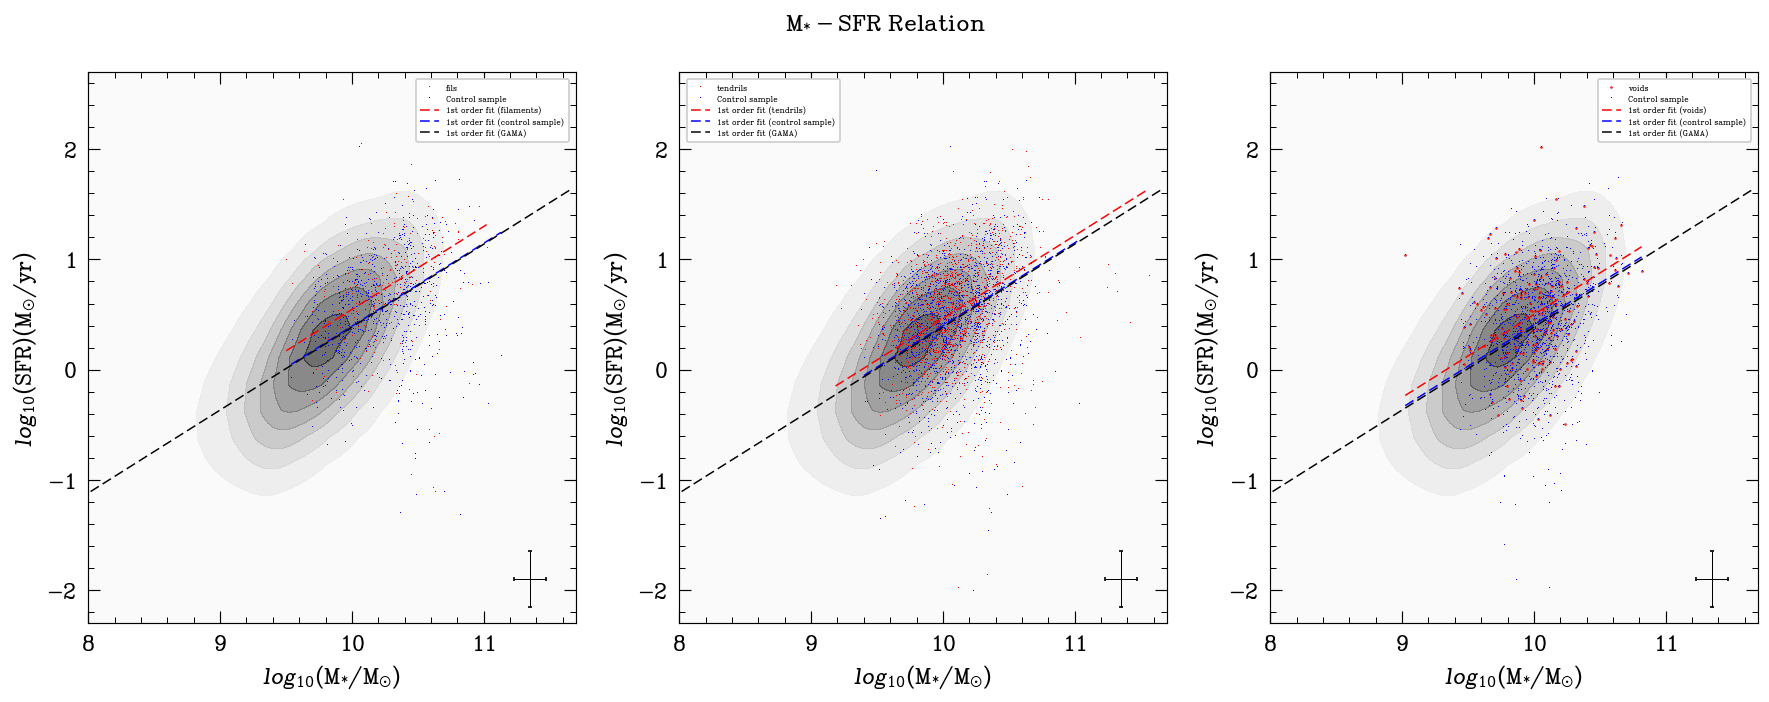

In [81]:
# M-SFR RELATIONS
fig, axes = subplots(nrows=1, ncols=3, figsize=(15, 6))
fig.suptitle("M$_{*}-$SFR Relation", fontsize=16)

# FILAMENTS
axes[0].plot(logmstar_fil_SF_woSFR,log10(SFR_fil_SF_wo),",",color="red",markersize = 50, label = "fils") 
axes[0].plot(logmstar_field_SF_filclone_woSFR,log10(SFR_field_SF_filclone_wo),",",color="blue",markersize = 50, label = "Control sample") 
axes[0].contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) 
axes[0].plot(x_modeloSFR_fil, y_modeloSFR_fil,"--" ,color = "red",label = "1st order fit (filaments)",linewidth = 0.9) 
axes[0].plot(x_modeloSFR_filclone, y_modeloSFR_filclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[0].plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRfil_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[0].set_xlim(8,11.7)
axes[0].set_ylim(-2.3,2.7)
axes[0].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[0].set_ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
axes[0].errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[0].legend(fontsize = 5.5, frameon=True)

# TENDRILS
axes[1].plot(logmstar_tendril_SF_woSFR,log10(SFR_tendril_SF_wo),",",color="red",markersize = 50, label = "tendrils") 
axes[1].plot(logmstar_field_SF_tendrilclone_woSFR,log10(SFR_field_SF_tendrilclone_wo),",",color="blue",markersize = 50, label = "Control sample") 
axes[1].contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) 
axes[1].plot(x_modeloSFR_tendril, y_modeloSFR_tendril,"--" ,color = "red",label = "1st order fit (tendrils)",linewidth = 0.9) 
axes[1].plot(x_modeloSFR_tendrilclone, y_modeloSFR_tendrilclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[1].plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRtendril_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[1].set_xlim(8,11.7)
axes[1].set_ylim(-2.3,2.7)
axes[1].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[1].set_ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
axes[1].errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[1].legend(fontsize = 5.5, loc='upper left',frameon=True)

# VOIDS
axes[2].plot(logmstar_void_SF_woSFR,log10(SFR_void_SF_wo),".",color="red",markersize = 1, label = "voids") 
axes[2].plot(logmstar_field_SF_voidclone_woSFR,log10(SFR_field_SF_voidclone_wo),",",color="blue",markersize = 50, label = "Control sample") 
axes[2].contourf(xiSFR,yiSFR,ziSFR.reshape(xiSFR.shape),cmap="Greys", alpha = 0.6) 
axes[2].plot(x_modeloSFR_void, y_modeloSFR_void,"--" ,color = "red",label = "1st order fit (voids)",linewidth = 0.9) 
axes[2].plot(x_modeloSFR_voidclone, y_modeloSFR_voidclone,"--" ,color = "blue",label = "1st order fit (control sample)",linewidth = 0.9) 
axes[2].plot(sorted(logmstar_SF_woSFR_isfinite),sorted(y_fit_w_SFRvoid_all),"--",color="black",label="1st order fit (GAMA)",linewidth = 0.9)
axes[2].set_xlim(8,11.7)
axes[2].set_ylim(-2.3,2.7)
axes[2].set_xlabel("$log_{10}$(M$_{*}$/M$_{\odot}$)")
axes[2].set_ylabel("$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)")
axes[2].errorbar(11.35,-1.9,xerr=median(dellogmstar_SF),yerr=0.252279720641123,color="black",elinewidth=0.6,capsize=1) #barras de error
axes[2].legend(fontsize = 5.5, frameon=True)

fig.tight_layout() #ajustar figuras
#savefig(os.path.join("./Images","SFR_Relations.pdf"),bbox_inches="tight") 
show()

## 17. Fundamental Plane

A continuación, vamos a plotear el Plano Fundamental. Esta relación de escala (no incluida en el anterior apartado) relaciona la masa estelar, con la SFR y la metalicidad Z. Esta relación a escala se ploteará para toda la muestra de GAMA, filamentos, tendrils y voids con sus muestras control. 

### Fundamental Plane for GAMA

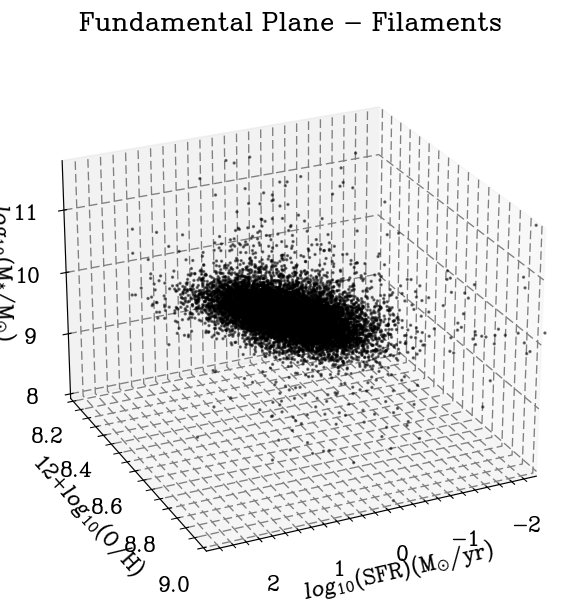

In [82]:
# Fundamental Plane
logsfr = log10(GAMA["SFR"])
metallicity = GAMA["METALLICITY"]
logmstar = GAMA["logmstar"]

fig = figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(logsfr, metallicity, logmstar,'.', s = 1, alpha = 0.5)

ax.set_title('Fundamental Plane - Filaments')
ax.set_xlabel('$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)')
ax.set_ylabel('12+$log_{10}$(O/H)')
ax.set_zlabel('$log_{10}$(M$_{*}$/M$_{\odot}$)')

ax.set_xlim(-2.3,2.7)
ax.set_ylim(8.2,9)
ax.set_zlim(8,11.7)

ax.view_init(25, 65)
show()

### Fundamental Plane for filaments

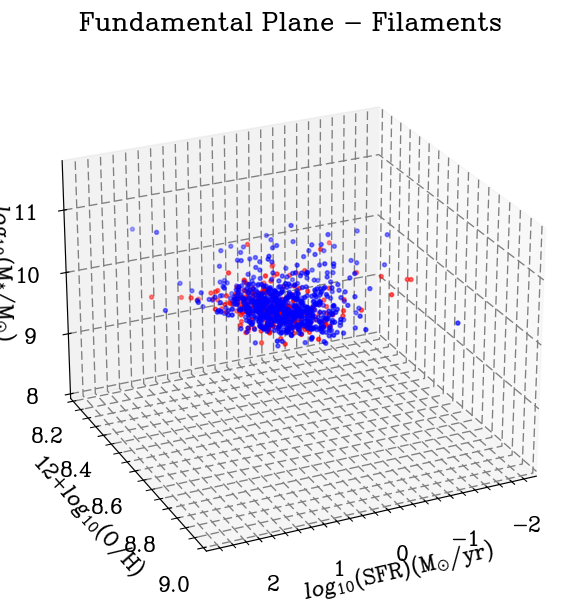

In [83]:
# Fundamental Plane
logsfr = log10(GAMA["SFR"])
logsfr_filclone = log10(SFR_field_SF_filclone)
logsfr_fil = log10(fil["SFR"])

metallicity = GAMA["METALLICITY"]
metallicity_filclone = Z_field_SF_filclone
metallicity_fil = fil["METALLICITY"]

logmstar = GAMA["logmstar"]
logmstar_filclone = logmstar_field_SF_filclone
logmstar_fil = fil["logmstar"]

fig = figure()
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(logsfr, metallicity, logmstar,'.', s = 1, alpha = 0.5)
ax.scatter(logsfr_fil, metallicity_fil, logmstar_fil,'.', s = 5, color = 'red')
ax.scatter(logsfr_filclone, metallicity_filclone, logmstar_filclone,'.', s = 5, color = 'blue')

ax.set_title('Fundamental Plane - Filaments')
ax.set_xlabel('$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)')
ax.set_ylabel('12+$log_{10}$(O/H)')
ax.set_zlabel('$log_{10}$(M$_{*}$/M$_{\odot}$)')

ax.set_xlim(-2.3,2.7)
ax.set_ylim(8.2,9)
ax.set_zlim(8,11.7)

ax.view_init(25, 65)
show()

### Fundamental Plane for tendrils

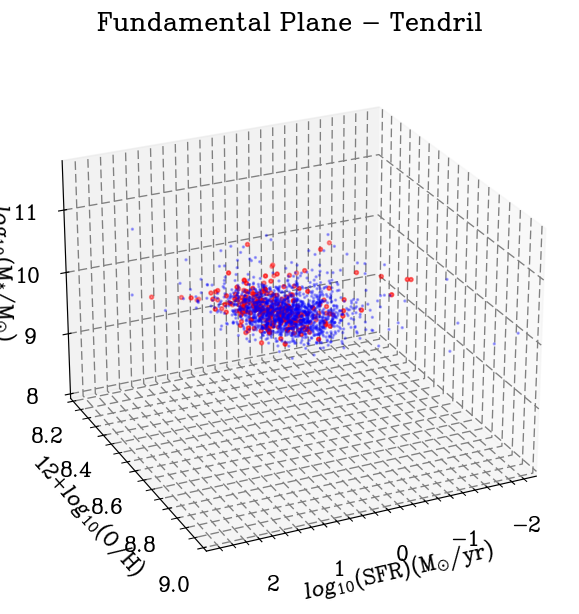

In [84]:
# Fundamental Plane
logsfr = log10(GAMA["SFR"])
logsfr_tendrilclone = log10(SFR_field_SF_tendrilclone)
logsfr_tendril = log10(fil["SFR"])

metallicity = GAMA["METALLICITY"]
metallicity_tendrilclone = Z_field_SF_tendrilclone
metallicity_tendril = fil["METALLICITY"]

logmstar = GAMA["logmstar"]
logmstar_tendrilclone = logmstar_field_SF_tendrilclone
logmstar_tendril = fil["logmstar"]

fig = figure()
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(logsfr, metallicity, logmstar,'.', s = 1, alpha = 0.5)
ax.scatter(logsfr_tendril, metallicity_tendril, logmstar_tendril,'.', s = 5, color = 'red')
ax.scatter(logsfr_tendrilclone, metallicity_tendrilclone, logmstar_tendrilclone,',', s = 1, color = 'blue', alpha = 0.3)

ax.set_title('Fundamental Plane - Tendril')
ax.set_xlabel('$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)')
ax.set_ylabel('12+$log_{10}$(O/H)')
ax.set_zlabel('$log_{10}$(M$_{*}$/M$_{\odot}$)')

ax.set_xlim(-2.3,2.7)
ax.set_ylim(8.2,9)
ax.set_zlim(8,11.7)

ax.view_init(25, 65)
show()

### Fundamental Plane for voids

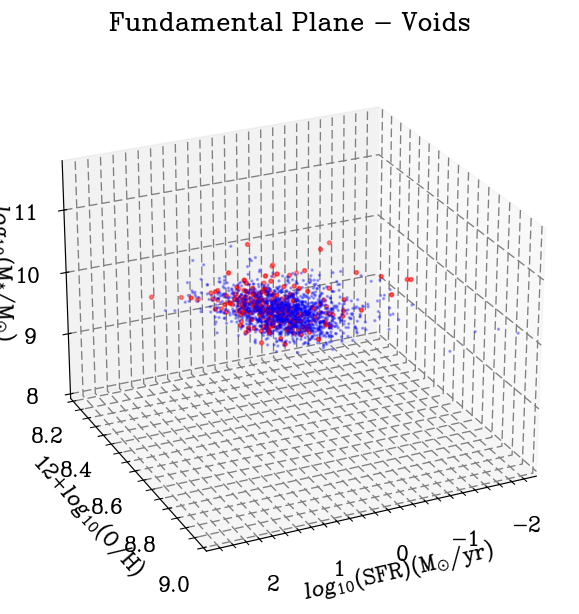

In [85]:
# Fundamental Plane
logsfr = log10(GAMA["SFR"])
logsfr_voidclone = log10(SFR_field_SF_voidclone)
logsfr_void = log10(fil["SFR"])

metallicity = GAMA["METALLICITY"]
metallicity_voidclone = Z_field_SF_voidclone
metallicity_void = fil["METALLICITY"]

logmstar = GAMA["logmstar"]
logmstar_voidclone = logmstar_field_SF_voidclone
logmstar_void = fil["logmstar"]

fig = figure()
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(logsfr, metallicity, logmstar,'.', s = 1, alpha = 0.5)
ax.scatter(logsfr_void, metallicity_void, logmstar_void,'.', s = 5, color = 'red')
ax.scatter(logsfr_voidclone, metallicity_voidclone, logmstar_voidclone,',', s = 1, color = 'blue', alpha = 0.3)

ax.set_title('Fundamental Plane - Voids')
ax.set_xlabel('$log_{10}(\mathrm{SFR})$(M$_{\odot}$/yr)')
ax.set_ylabel('12+$log_{10}$(O/H)')
ax.set_zlabel('$log_{10}$(M$_{*}$/M$_{\odot}$)')

ax.set_xlim(-2.3,2.7)
ax.set_ylim(8.2,9)
ax.set_zlim(8,11.7)

ax.view_init(25, 65)
show()

## 18. Bootstrap

En esta sección, se van a calcular los errores en las diferencias de los coeficientes de orden cero de los ajustes (convencionales - no bayesianos) representados y calculados en la sección _16. Scale Relations_. Para ello, emplearemos el método de bootstrap.

#### Bootstrap functions to calculate coefficients

Este método no admite el cálculo específico del error en los coeficientes de un ajuste por lo que tendremos que definirlo previamente para poder aplicarlo. Para ello, vamos a crear 4 funciones, un par para calcular los errores en el coeficiente para filamentos/tendrils/vois y sus muestras control para la M-Z Relation y lo mismo para la M-SFR Relation. 

In [86]:
# Definción que calcula el coeficiente de orden cero de la M-SFR Relation
def coefSFR_dif(var3,var4): # Primera varibale SFR (var3) y luego masa (var4)

    SFR_SF = log10(SFR_SF_woSFR)
    logmstar_SF = logmstar_SF_woSFR
    SFR_fil_SF = log10(var3)
    logmstar_fil_SF = var4
    SFR_field_SF_filclone = log10(SFR_field_SF_filclone_wo)
    logmstar_field_SF_filclone = logmstar_field_SF_filclone_woSFR
    
    # AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
    SFR_SF_isfinite = SFR_SF
    logmstar_SF_isfinite = logmstar_SF
    
    p_SFRfil_all = polyfit(logmstar_SF_isfinite, SFR_SF_isfinite, 1) 
    y_SFRfit_all = polyval(p_SFRfil_all,logmstar_SF_isfinite)
    
    # Pesos w
    w_SFRfil_all=[]
    resid_SFRfil_all=[]
    for m in range(len(y_SFRfit_all)):
        resid_SFRfil_all.append((SFR_SF_isfinite)[m]-y_SFRfit_all[m])
        w_SFRfil_all.append(1/resid_SFRfil_all[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfil_all = polyfit(logmstar_SF_isfinite, SFR_SF_isfinite,1, w = w_SFRfil_all) 
    y_fit_w_SFRfil_all = polyval(p_w_SFRfil_all,logmstar_SF_isfinite) 
    
    # AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
    SFR_fil_SF_isfinite = SFR_fil_SF
    logmstar_fil_SF_isfinite = logmstar_fil_SF
    
    p_SFRfil = polyfit(logmstar_fil_SF_isfinite, SFR_fil_SF_isfinite,1) 
    y_SFRfit = polyval(p_SFRfil,logmstar_fil_SF_isfinite)
    
    # Pesos w
    w_SFRfil=[]
    resid_SFRfil=[]
    for m in range(len(y_SFRfit)):
        resid_SFRfil.append((SFR_fil_SF_isfinite)[m]-y_SFRfit[m])
        w_SFRfil.append(1/resid_SFRfil[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfil = polyfit(logmstar_fil_SF_isfinite, SFR_fil_SF_isfinite,1, w = w_SFRfil) 
    y_fit_w_SFRfil = polyval(p_w_SFRfil,logmstar_fil_SF_isfinite) 
    
    # AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
    SFR_field_SF_filclone_isfinite = SFR_field_SF_filclone
    logmstar_field_SF_filclone_isfinite = logmstar_field_SF_filclone
    
    p_SFRfilclone = polyfit(logmstar_field_SF_filclone_isfinite, SFR_field_SF_filclone_isfinite,1) 
    y_SFRfitclone = polyval(p_SFRfilclone, logmstar_field_SF_filclone_isfinite)
    
    # Pesos w
    w_SFRfilclone=[]
    resid_SFRfilclone=[]
    for m in range(len(y_SFRfitclone)):
        resid_SFRfilclone.append((SFR_field_SF_filclone_isfinite)[m]-y_SFRfitclone[m])
        w_SFRfilclone.append(1/resid_SFRfilclone[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfilclone = polyfit(logmstar_field_SF_filclone_isfinite, SFR_field_SF_filclone_isfinite,1, w = w_SFRfilclone) 
    y_fit_w_SFRfilclone = polyval(p_w_SFRfilclone, logmstar_field_SF_filclone_isfinite) 
    
    #AJUSTE FIJANDO LOS COEFICEINTES - FILAMENTOS ---------------------------------------------------------------------------
    a = p_w_SFRfil_all[0]
    d_0_fil = p_w_SFRfil[1]
    
    #Modelo con a fijo
    def model_fil(x_fil,d_fil):
        return a*x_fil+d_fil
    
    #Ajuste con a,b y c fijos
    coef_fil,cov_fil = curve_fit(model_fil, logmstar_fil_SF_isfinite, SFR_fil_SF_isfinite, p0 = [d_0_fil])
    
    return coef_fil

In [87]:
# Definción que calcula el coeficiente de orden cero de la M-SFR Relation - clones
def coefSFR_dif_clone(var5,var6): # Primera varibale SFR (var5) y luego masa (var6)

    SFR_SF = log10(SFR_SF_woSFR)
    logmstar_SF = logmstar_SF_woSFR
    SFR_fil_SF = log10(SFR_fil_SF_wo)
    logmstar_fil_SF = logmstar_fil_SF_woSFR
    SFR_field_SF_filclone = log10(var5)
    logmstar_field_SF_filclone = var6
    
    # AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
    SFR_SF_isfinite = SFR_SF
    logmstar_SF_isfinite = logmstar_SF
    
    p_SFRfil_all = polyfit(logmstar_SF_isfinite, SFR_SF_isfinite, 1) 
    y_SFRfit_all = polyval(p_SFRfil_all,logmstar_SF_isfinite)
    
    # Pesos w
    w_SFRfil_all=[]
    resid_SFRfil_all=[]
    for m in range(len(y_SFRfit_all)):
        resid_SFRfil_all.append((SFR_SF_isfinite)[m]-y_SFRfit_all[m])
        w_SFRfil_all.append(1/resid_SFRfil_all[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfil_all = polyfit(logmstar_SF_isfinite, SFR_SF_isfinite,1, w = w_SFRfil_all) 
    y_fit_w_SFRfil_all = polyval(p_w_SFRfil_all,logmstar_SF_isfinite) 
    
    # AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
    SFR_fil_SF_isfinite = SFR_fil_SF
    logmstar_fil_SF_isfinite = logmstar_fil_SF
    
    p_SFRfil = polyfit(logmstar_fil_SF_isfinite, SFR_fil_SF_isfinite, 1) 
    y_SFRfit = polyval(p_SFRfil,logmstar_fil_SF_isfinite)
    
    # Pesos w
    w_SFRfil=[]
    resid_SFRfil=[]
    for m in range(len(y_SFRfit)):
        resid_SFRfil.append((SFR_fil_SF_isfinite)[m]-y_SFRfit[m])
        w_SFRfil.append(1/resid_SFRfil[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfil = polyfit(logmstar_fil_SF_isfinite, SFR_fil_SF_isfinite,1, w = w_SFRfil) 
    y_fit_w_SFRfil = polyval(p_w_SFRfil,logmstar_fil_SF_isfinite) 
    
    # AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
    SFR_field_SF_filclone_isfinite = SFR_field_SF_filclone
    logmstar_field_SF_filclone_isfinite = logmstar_field_SF_filclone
    
    p_SFRfilclone = polyfit(logmstar_field_SF_filclone_isfinite, SFR_field_SF_filclone_isfinite,1) 
    y_SFRfitclone = polyval(p_SFRfilclone, logmstar_field_SF_filclone_isfinite)
    
    # Pesos w
    w_SFRfilclone=[]
    resid_SFRfilclone=[]
    for m in range(len(y_SFRfitclone)):
        resid_SFRfilclone.append((SFR_field_SF_filclone_isfinite)[m]-y_SFRfitclone[m])
        w_SFRfilclone.append(1/resid_SFRfilclone[m]**2)
    
    #Ajuste por polinomios con w
    p_w_SFRfilclone = polyfit(logmstar_field_SF_filclone_isfinite, SFR_field_SF_filclone_isfinite,1, w = w_SFRfilclone) 
    y_fit_w_SFRfilclone = polyval(p_w_SFRfilclone, logmstar_field_SF_filclone_isfinite) 
    
    #AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
    a = p_w_SFRfil_all[0]
    d_0_filclone = p_w_SFRfilclone[1]
    
    #Modelo con a,b y c fijos
    def model_filclone(x_filclone,d_filclone):
        return a*x_filclone+d_filclone
    
    #Ajuste con a,b y c fijos
    coef_filclone, cov_filclone = curve_fit(model_filclone, logmstar_field_SF_filclone_isfinite,  SFR_field_SF_filclone_isfinite, p0 = [d_0_filclone])

    return coef_filclone

In [88]:
# Definción que calcula el coeficiente de orden cero de la M-Z Relation
def coefZ_dif(var3,var4): # Primera varibale Z (var3) y luego masa (var4)

    PPO4_SF = PPO4_SF_woZ
    logmstar_SF = logmstar_SF_woZ
    Z_fil_SF = var3
    logmstar_fil_SF = var4
    Z_field_SF_filclone = Z_field_SF_filclone_wo
    logmstar_field_SF_filclone = logmstar_field_SF_filclone_woZ
    
    # AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
    p_Zfil_all = polyfit(logmstar_SF, PPO4_SF, 3) 
    y_Zfit_all = polyval(p_Zfil_all,logmstar_SF)
    
    # Pesos w
    w_Zfil_all=[]
    resid_Zfil_all=[]
    for m in range(len(y_Zfit_all)):
        resid_Zfil_all.append((PPO4_SF)[m]-y_Zfit_all[m])
        w_Zfil_all.append(1/resid_Zfil_all[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfil_all = polyfit(logmstar_SF, PPO4_SF,3, w = w_Zfil_all) 
    y_fit_w_Zfil_all = polyval(p_w_Zfil_all,logmstar_SF) 
      
    # AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
    p_Zfil = polyfit(logmstar_fil_SF, Z_fil_SF, 3) 
    y_Zfit = polyval(p_Zfil,logmstar_fil_SF)
    
    # Pesos w
    w_Zfil=[]
    resid_Zfil=[]
    for m in range(len(y_Zfit)):
        resid_Zfil.append((Z_fil_SF)[m]-y_Zfit[m])
        w_Zfil.append(1/resid_Zfil[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfil = polyfit(logmstar_fil_SF, Z_fil_SF,3, w = w_Zfil) 
    y_fit_w_Zfil = polyval(p_w_Zfil,logmstar_fil_SF) 
     
    # AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
    p_Zfilclone = polyfit(logmstar_field_SF_filclone, Z_field_SF_filclone,3) 
    y_Zfitclone = polyval(p_Zfilclone, logmstar_field_SF_filclone)
    
    # Pesos w
    w_Zfilclone=[]
    resid_Zfilclone=[]
    for m in range(len(y_Zfitclone)):
        resid_Zfilclone.append((Z_field_SF_filclone)[m]-y_Zfitclone[m])
        w_Zfilclone.append(1/resid_Zfilclone[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfilclone = polyfit(logmstar_field_SF_filclone, Z_field_SF_filclone,3, w = w_Zfilclone) 
    y_fit_w_Zfilclone = polyval(p_w_Zfilclone, logmstar_field_SF_filclone) 
       
    #AJUSTE FIJANDO LOS COEFICEINTES - FILAMENTOS ---------------------------------------------------------------------------
    a,b,c = p_w_Zfil_all[0],p_w_Zfil_all[1],p_w_Zfil_all[2]
    d_0_fil = p_w_Zfil[3]
    
    #Modelo con a,b y c fijos
    def model_fil(x_fil,d_fil):
        return a*x_fil**3+b*x_fil**2+c*x_fil+d_fil
    
    #Ajuste con a,b y c fijos
    coef_filZ, cov_filZ = curve_fit(model_fil, logmstar_fil_SF, Z_fil_SF, p0 = [d_0_fil])
    
    x_modeloZ_fil = linspace(min(logmstar_fil_SF),max(logmstar_fil_SF),100)
    y_modeloZ_fil = model_fil(x_modeloZ_fil,coef_filZ[0])

    return coef_filZ

In [89]:
# Definción que calcula el coeficiente de orden cero de la M-Z Relation - clones
def coefZ_dif_clone(var5,var6): # Primera varibale Z (var5) y luego masa (var7)

    PPO4_SF = PPO4_SF_woZ
    logmstar_SF = logmstar_SF_woZ
    Z_fil_SF = Z_fil_SF_wo
    logmstar_fil_SF = logmstar_fil_SF_woZ
    Z_field_SF_filclone = var5
    logmstar_field_SF_filclone = var6
    
    # AJUSTE GAMA --------------------------------------------------------------------------------------------------------------
    p_Zfil_all = polyfit(logmstar_SF, PPO4_SF, 3) 
    y_Zfit_all = polyval(p_Zfil_all,logmstar_SF)
    
    # Pesos w
    w_Zfil_all=[]
    resid_Zfil_all=[]
    for m in range(len(y_Zfit_all)):
        resid_Zfil_all.append((PPO4_SF)[m]-y_Zfit_all[m])
        w_Zfil_all.append(1/resid_Zfil_all[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfil_all = polyfit(logmstar_SF, PPO4_SF,3, w = w_Zfil_all) 
    y_fit_w_Zfil_all = polyval(p_w_Zfil_all,logmstar_SF) 
      
    # AJUSTE FILAMENTOS --------------------------------------------------------------------------------------------------------------
    p_Zfil = polyfit(logmstar_fil_SF, Z_fil_SF, 3) 
    y_Zfit = polyval(p_Zfil,logmstar_fil_SF)
    
    # Pesos w
    w_Zfil=[]
    resid_Zfil=[]
    for m in range(len(y_Zfit)):
        resid_Zfil.append((Z_fil_SF)[m]-y_Zfit[m])
        w_Zfil.append(1/resid_Zfil[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfil = polyfit(logmstar_fil_SF, Z_fil_SF,3, w = w_Zfil) 
    y_fit_w_Zfil = polyval(p_w_Zfil,logmstar_fil_SF) 
     
    # AJUSTE CONTROL SAMPLE (FIELD GALAXIES - CLONES) ----------------------------------------------------------------------------------
    p_Zfilclone = polyfit(var6, var5,3) 
    y_Zfitclone = polyval(p_Zfilclone, var6)
    
    # Pesos w
    w_Zfilclone=[]
    resid_Zfilclone=[]
    for m in range(len(y_Zfitclone)):
        resid_Zfilclone.append((var5)[m]-y_Zfitclone[m])
        w_Zfilclone.append(1/resid_Zfilclone[m]**2)
    
    #Ajuste por polinomios con w
    p_w_Zfilclone = polyfit(var6, var5,3, w = w_Zfilclone) 
    y_fit_w_Zfilclone = polyval(p_w_Zfilclone, var6) 
       
    #AJUSTE FIJANDO LOS COEFICEINTES - CONTROL SAMPLE ---------------------------------------------------------------------------
    a,b,c = p_w_Zfil_all[0],p_w_Zfil_all[1],p_w_Zfil_all[2]
    d_0_filclone = p_w_Zfilclone[3]
    
    #Modelo con a,b y c fijos
    def model_filclone(x_filclone,d_filclone):
        return a*x_filclone**3+b*x_filclone**2+c*x_filclone+d_filclone
    
    #Ajuste con a,b y c fijos
    coef_filcloneZ, cov_filcloneZ = curve_fit(model_filclone, var6, var5, p0 = [d_0_filclone])

    return coef_filcloneZ

#### Bootstrap method

A continuación, una vez definidas las funciones que calculan los coeficientes de orden 0, es momento de hacer el bootstrap. En vez de utilizar el comando tradicional de bootstrap, lo programaremos por nosotros mismos. 

In [90]:
# Función bootstrap
def bootstrap(x, y, statistic, n_bootstrap):
    """
    Realiza bootstrap para calcular una estadística sobre los datos x e y.

    Parameters:
        x (list): Datos de la variable independiente.
        y (list): Datos de la variable dependiente.
        statistic (function): Función que calcula la estadística deseada.
                              Debe tomar dos argumentos (x, y).
        n_bootstrap (int): Número de muestras bootstrap a generar.

    Returns:
        numpy.ndarray: Arreglo con las estadísticas calculadas para cada muestra bootstrap.
    """
    
    n = len(x)
    bootstrap_statistics = zeros(n_bootstrap)
    for i in tqdm(range(n_bootstrap)):
        # Genera una muestra bootstrap de los índices con reemplazo
        indices = random.choice(n, size=n, replace=True)
        # Calcula la estadística deseada en base a la muestra bootstrap
        bootstrap_statistics[i] = statistic([x[j] for j in indices], [y[j] for j in indices])
    return bootstrap_statistics

In [101]:
# Realizamos bootstraps: M-Z and M-SFR Relation for filaments (coefficients zero order) 
bootstrap_coefZ_difF = bootstrap(Z_fil_SF_wo, logmstar_fil_SF_woZ, coefZ_dif, n_bootstrap = 4000)
print('coefZ_dif')
print('beta0 media:', mean(bootstrap_coefZ_difF))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_difF))

bootstrap_coefZ_dif_cloneF = bootstrap(Z_field_SF_filclone_wo, logmstar_field_SF_filclone_woZ, coefZ_dif_clone, n_bootstrap = 500)
print('')
print('coefZ_dif_clone')
print('beta0 media:', mean(bootstrap_coefZ_dif_cloneF))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_dif_cloneF))

bootstrap_coefSFR_difF = bootstrap(SFR_fil_SF_wo, logmstar_fil_SF_woSFR, coefSFR_dif, n_bootstrap = 500)
print('')
print('coefSFR_dif')
print('beta0 media:', mean(bootstrap_coefSFR_difF))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_difF))

bootstrap_coefSFR_dif_cloneF = bootstrap(SFR_field_SF_filclone_wo, logmstar_field_SF_filclone_woSFR, coefSFR_dif_clone, n_bootstrap = 500)
print('')
print('coefSFR_dif_clone')
print('beta0 media:', mean(bootstrap_coefSFR_dif_cloneF))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_dif_cloneF))

100%|███████████████████████████████████████| 4000/4000 [00:55<00:00, 72.59it/s]


coefZ_dif
beta0 media: 5.6951337764093
Desviación estándar de beta0: 0.005263149094160258


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 60.50it/s]



coefZ_dif_clone
beta0 media: 5.685695574150484
Desviación estándar de beta0: 0.0036367540046522203


100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 77.49it/s]



coefSFR_dif
beta0 media: -6.97556140366089
Desviación estándar de beta0: 0.028575839397573154


100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 71.64it/s]


coefSFR_dif_clone
beta0 media: -7.1286114408405385
Desviación estándar de beta0: 0.017874277707059617


In [92]:
# Realizamos bootstraps: M-Z and M-SFR Relation for tendrils (coefficients zero order) 
bootstrap_coefZ_difT = bootstrap(Z_tendril_SF_wo, logmstar_tendril_SF_woZ, coefZ_dif, n_bootstrap = 500)
print('coefZ_dif')
print('beta0 media:', mean(bootstrap_coefZ_difT))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_difT))

bootstrap_coefZ_dif_cloneT = bootstrap(Z_field_SF_tendrilclone_wo, logmstar_field_SF_tendrilclone_woZ, coefZ_dif_clone, n_bootstrap = 500)
print('')
print('coefZ_dif_clone')
print('beta0 media:', mean(bootstrap_coefZ_dif_cloneT))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_dif_cloneT))

bootstrap_coefSFR_difT = bootstrap(SFR_tendril_SF_wo, logmstar_tendril_SF_woSFR, coefSFR_dif, n_bootstrap = 500)
print('')
print('coefSFR_dif')
print('beta0 media:', mean(bootstrap_coefSFR_difT))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_difT))

bootstrap_coefSFR_dif_cloneT = bootstrap(SFR_field_SF_tendrilclone_wo, logmstar_field_SF_tendrilclone_woSFR, coefSFR_dif_clone, n_bootstrap = 500)
print('')
print('coefSFR_dif_clone')
print('beta0 media:', mean(bootstrap_coefSFR_dif_cloneT))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_dif_cloneT))

100%|█████████████████████████████████████████| 500/500 [00:12<00:00, 41.39it/s]


coefZ_dif
beta0 media: 5.68907107180842
Desviación estándar de beta0: 0.0025066348971138075


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 50.90it/s]



coefZ_dif_clone
beta0 media: 5.697478045708123
Desviación estándar de beta0: 0.002424833090118525


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 55.52it/s]



coefSFR_dif
beta0 media: -7.059499038858727
Desviación estándar de beta0: 0.011855169282075858


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 56.18it/s]


coefSFR_dif_clone
beta0 media: -7.124747094373595
Desviación estándar de beta0: 0.012115745145224316


In [93]:
# Realizamos bootstraps: M-Z and M-SFR Relation for voids (coefficients zero order) 
bootstrap_coefZ_difV = bootstrap(Z_void_SF_wo, logmstar_void_SF_woZ, coefZ_dif, n_bootstrap = 500)
print('coefZ_dif')
print('beta0 media:', mean(bootstrap_coefZ_difV))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_difV))

bootstrap_coefZ_dif_cloneV = bootstrap(Z_field_SF_voidclone_wo, logmstar_field_SF_voidclone_woZ, coefZ_dif_clone, n_bootstrap = 500)
print('')
print('coefZ_dif_clone')
print('beta0 media:', mean(bootstrap_coefZ_dif_cloneV))
print('Desviación estándar de beta0:', std(bootstrap_coefZ_dif_cloneV))

bootstrap_coefSFR_difV = bootstrap(SFR_void_SF_wo, logmstar_void_SF_woSFR, coefSFR_dif, n_bootstrap = 500)
print('')
print('coefSFR_dif')
print('beta0 media:', mean(bootstrap_coefSFR_difV))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_difV))

bootstrap_coefSFR_dif_cloneV = bootstrap(SFR_field_SF_voidclone_wo, logmstar_field_SF_voidclone_woSFR, coefSFR_dif_clone, n_bootstrap = 500)
print('')
print('coefSFR_dif_clone')
print('beta0 media:', mean(bootstrap_coefSFR_dif_cloneV))
print('Desviación estándar de beta0:', std(bootstrap_coefSFR_dif_cloneV))

100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 46.96it/s]


coefZ_dif
beta0 media: 5.679224207844845
Desviación estándar de beta0: 0.006878463560190843


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 50.66it/s]



coefZ_dif_clone
beta0 media: 5.690750302886318
Desviación estándar de beta0: 0.0024624151165076936


100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 63.42it/s]



coefSFR_dif
beta0 media: -7.021904037141881
Desviación estándar de beta0: 0.029612122987564507


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 56.66it/s]


coefSFR_dif_clone
beta0 media: -7.1147475583096975
Desviación estándar de beta0: 0.011007966462443449


### Bootstrap histograms

Representamos los histogramas de bootstraps para visualizar los remuestreos con sus medias y desviaciones típicas. Nótese que se está calculando los errores en los coeficientes de orden cero de los ajustes para filamentos/tendrils/voids junto a sus muestra control y no sus diferencias. El error en las diferencias es simplemente la rai cuadrada de los errores correspodneintes al cuadrado. Además, estamos fijando el error en GAMA. 

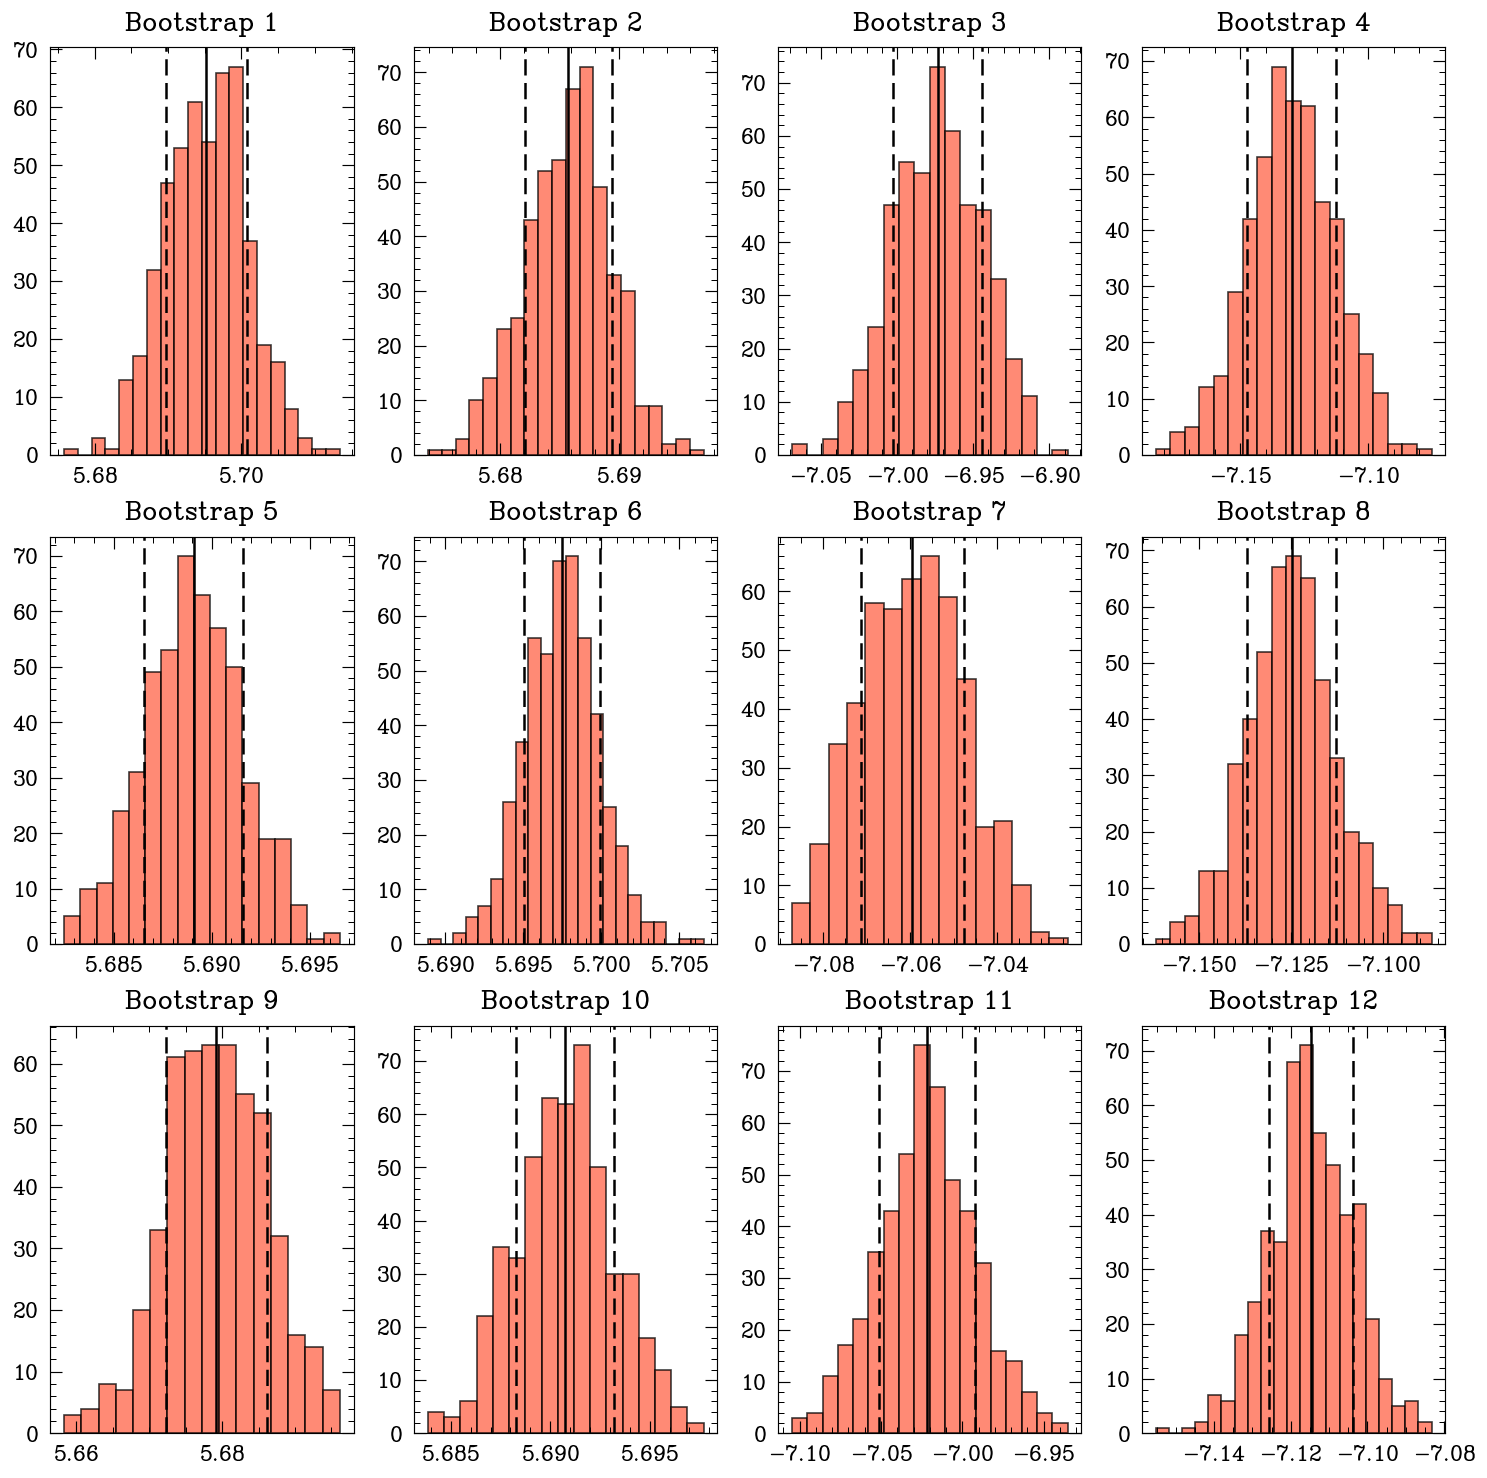

In [97]:
# Función para calcular media y std de los datos
def calc_error_bar(data):
    return mean(data), std(data)

# Bootstrap Histograms
fig, axes = subplots(3, 4, figsize=(15, 15))

bootstrap_list = [bootstrap_coefZ_difF, bootstrap_coefZ_dif_cloneF, bootstrap_coefSFR_difF, bootstrap_coefSFR_dif_cloneF,
                  bootstrap_coefZ_difT, bootstrap_coefZ_dif_cloneT, bootstrap_coefSFR_difT, bootstrap_coefSFR_dif_cloneT,
                  bootstrap_coefZ_difV, bootstrap_coefZ_dif_cloneV, bootstrap_coefSFR_difV, bootstrap_coefSFR_dif_cloneV,]

for i, ax in enumerate(axes.flatten()):
    data = bootstrap_list[i]
    media, std_dev = calc_error_bar(data)
    ax.hist(data, bins=histogram_bin_edges(data, bins="fd"), color="tomato", edgecolor="black", alpha=0.75)
    ax.axvline(media, color = 'black', linestyle = 'solid', linewidth = 1.5)  # Línea vertical para la media
    ax.axvline(media + std_dev, color = 'black', linestyle = 'dashed', linewidth = 1.5)  # Línea vertical para la std
    ax.axvline(media - std_dev, color = 'black', linestyle = 'dashed', linewidth = 1.5)  # Línea vertical para la std
    ax.set_title('Bootstrap {}'.format(i+1))

savefig(os.path.join("./Images","Histograms_Bootstrap.pdf"),bbox_inches="tight") 
show()

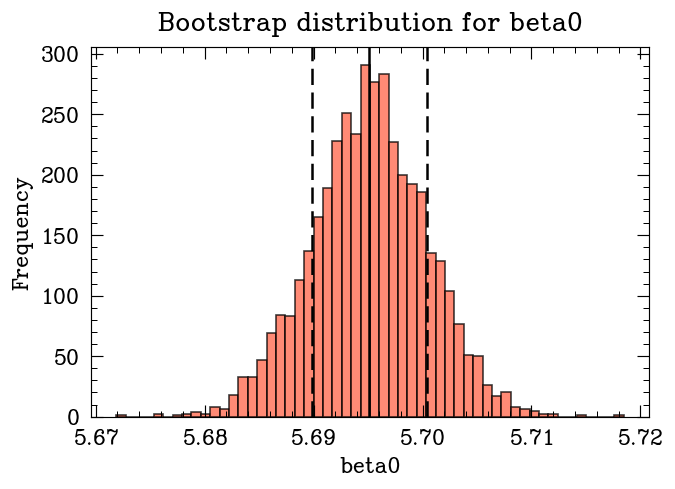

In [105]:
# Función para calcular media y std de los datos
def calc_error_bar(data):
    return mean(data), std(data)

# Bootstrap Histograms
fig, ax = subplots(figsize=(6, 4))  # Solo un histograma

bootstrap_list = [bootstrap_coefZ_difF, bootstrap_coefZ_dif_cloneF, bootstrap_coefSFR_difF, bootstrap_coefSFR_dif_cloneF,
                  bootstrap_coefZ_difT, bootstrap_coefZ_dif_cloneT, bootstrap_coefSFR_difT, bootstrap_coefSFR_dif_cloneT,
                  bootstrap_coefZ_difV, bootstrap_coefZ_dif_cloneV, bootstrap_coefSFR_difV, bootstrap_coefSFR_dif_cloneV,]

data = bootstrap_list[0]  # Tomar solo el primer conjunto de datos
media, std_dev = calc_error_bar(data)

ax.hist(data, bins=histogram_bin_edges(data, bins="fd"), color="tomato", edgecolor="black", alpha=0.75)
ax.axvline(media, color='black', linestyle='solid', linewidth=1.5)  # Línea vertical para la media
ax.axvline(media + std_dev, color='black', linestyle='dashed', linewidth=1.5)  # Línea vertical para la std
ax.axvline(media - std_dev, color='black', linestyle='dashed', linewidth=1.5)  # Línea vertical para la std
ax.set_title('Bootstrap distribution for beta0')
ax.set_xlabel('beta0')
ax.set_ylabel('Frequency')

savefig(os.path.join("./Images", "Histogram_Bootstrap2.pdf"), bbox_inches="tight")  # Guardar solo este histograma
show()

## 19. Coefficient plot

Vamos a hacer un plot como resumen del valor de las diferencias de los coeficientes con sus errores.

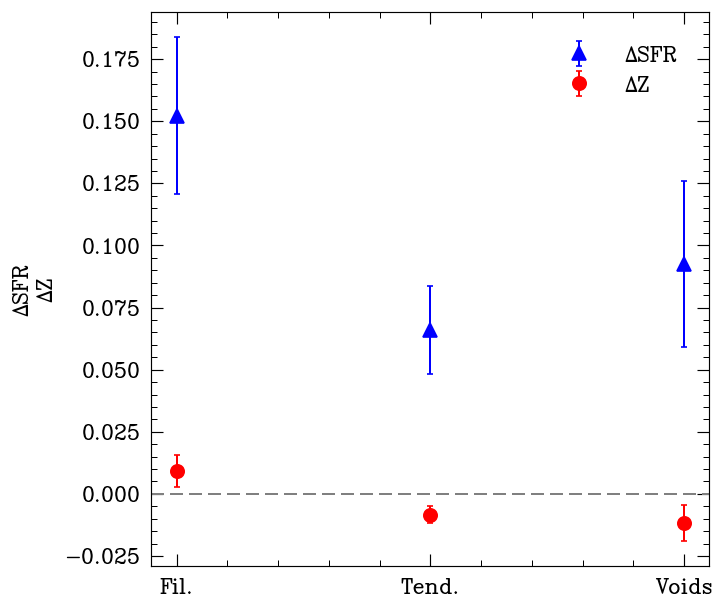

In [95]:
# Differences in coefficientes
galaxies = ['Fil.', 'Tend.', 'Voids']
coefSFR = [coef_filSFR[0] - coef_filcloneSFR[0], coef_tendrilSFR[0] - coef_tendrilcloneSFR[0], coef_voidSFR[0] - coef_voidcloneSFR[0]]
coefZ = [coef_filZ[0] - coef_filcloneZ[0], coef_tendrilZ[0] - coef_tendrilcloneZ[0], coef_voidZ[0] - coef_voidcloneZ[0]]

# Errors
errors_SFR = [float(sqrt(0.0271 ** 2 + 0.0162 ** 2)), 
              float(sqrt(0.0117 ** 2 + 0.0134 ** 2)),
              float(sqrt(0.0314 ** 2 + 0.0116 ** 2))]

errors_Z = [float(sqrt(0.0053 ** 2 + 0.0036 ** 2)), 
            float(sqrt(0.0025 ** 2 + 0.0025 ** 2)),
            float(sqrt(0.0068 ** 2 + 0.0024 ** 2))]

errorbar(galaxies, coefSFR, yerr=errors_SFR, fmt='^', color='blue', label='ΔSFR', markersize = 8)
errorbar(galaxies, coefZ, yerr=errors_Z, fmt='o', color='red', label='ΔZ',  markersize = 8)

ylabel('ΔSFR\nΔZ')
axhline(0, color='gray', linestyle='--')
legend()

#savefig(os.path.join("./Images","Coefficients.pdf"),bbox_inches="tight") 
show()

## Appendix A: Other control sample for tendrils

En este apéndice vamos a dejar guarda alguna muestra control de más para tendrils por si durante el TFM, al tribunal le es de interés conocer otras muestras control o para justificar la finalmente escogida.

Muestra control 2 para tendrils. Condiciones: 

1. difz_low = 0.016
2. divisor_z = 0.115
3. difz_high = 0.006

4. diflogmstar_low = 0.008
5. divisor_mass = 10.25 
6. diflogmstar_high = 0.1

7. difcolorur_low = 0.08
8. divisor_color = 1.25 
9. difcolorur_high = 0.068

10. limit_clones = 1 (para todo)